In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("//Users/steven/Documents/DS340W/Papaer_Code/Papaer_Code/Crude Oil Prices 1946-Present.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

df_sub = df.loc["2005-01-01":"2018-12-31"]

print(df_sub.head())

            Value
Date             
2005-01-01  46.84
2005-02-01  48.15
2005-03-01  54.19
2005-04-01  52.98
2005-05-01  49.83


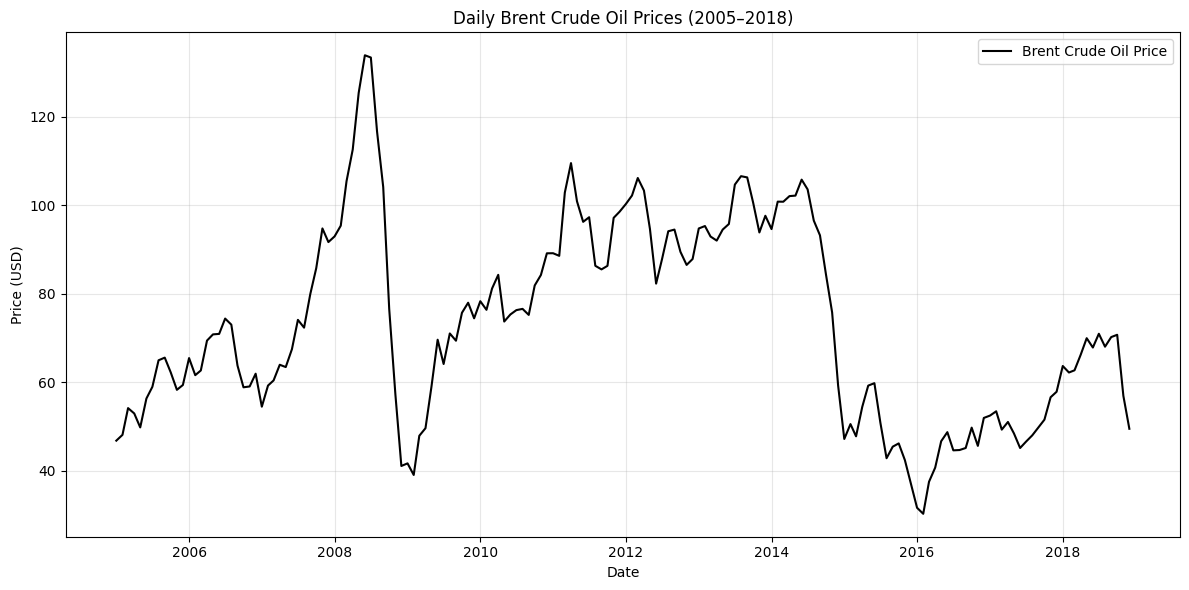

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df_sub.index, df_sub["Value"], label="Brent Crude Oil Price", color="black")
plt.title("Daily Brent Crude Oil Prices (2005–2018)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera

INPUT_CSV = "/Users/steven/Documents/DS340W/Papaer_Code/Papaer_Code/Crude Oil Prices 1946-Present.csv" 
OUTDIR = "oil_outputs"
START = "2005-01-01"
END   = "2018-12-31"


df = pd.read_csv(INPUT_CSV, parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")

df_sub = df.loc[START:END].copy()

df_sub["Return"] = np.log(df_sub["Value"] / df_sub["Value"].shift(1))
df_sub = df_sub.dropna()

def stats_summary(series):
    s = series.dropna()
    return {
        "Mean (%)": s.mean() * 100,
        "Std. Dev. (%)": s.std() * 100,
        "Skewness": skew(s),
        "Kurtosis": kurtosis(s, fisher=False),
        "Jarque-Bera": jarque_bera(s)[0],
        "JB p-value": jarque_bera(s)[1]
    }

summary = stats_summary(df_sub["Return"])
summary_df = pd.DataFrame([summary], index=["Oil Returns"]).round(4)

print(summary_df)

import os
os.makedirs(OUTDIR, exist_ok=True)
df_sub.to_csv(f"{OUTDIR}/oil_prices_returns_2005_2018.csv")
summary_df.to_csv(f"{OUTDIR}/oil_returns_stats_2005_2018.csv")

print(f"Saved filtered data and stats in folder: {OUTDIR}")

             Mean (%)  Std. Dev. (%)  Skewness  Kurtosis  Jarque-Bera  \
Oil Returns    0.0333         9.0161    -0.891    4.7497      43.3987   

             JB p-value  
Oil Returns         0.0  
Saved filtered data and stats in folder: oil_outputs


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy.stats import jarque_bera, skew, kurtosis

START, END = "2005-01-01", "2018-12-31"
BASEDIR = Path("/mnt/data")
OUTDIR  = Path("connectedness_outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)
TABDIR  = OUTDIR / "tables"; TABDIR.mkdir(exist_ok=True)

def load_price_flexible(path):
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    for col in ["Adj Close", "Close", "Price", "AdjClose", "PX_LAST"]:
        if col in df.columns:
            return df.set_index("Date")[col].astype(float).loc[START:END]
    for c in df.columns:
        if c != "Date" and pd.api.types.is_numeric_dtype(df[c]):
            return df.set_index("Date")[c].astype(float).loc[START:END]
    raise ValueError(f"{path}: no numeric price-like column")

def load_panel_prices(path):
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date").set_index("Date").loc[START:END]
    return df.select_dtypes(include=["number"])

def to_bdays_ffill(s):
    idx = pd.bdate_range(START, END)
    return s.reindex(idx).ffill()

def to_bdays_ffill_panel(df):
    idx = pd.bdate_range(START, END)
    return df.reindex(idx).ffill()

def log_ret(x): 
    return np.log(x/x.shift(1))

def pct(x): 
    return 100*x

def latex_table(df, path, caption=None, label=None, floatfmt="%.4f"):
    with open(path, "w") as f:
        f.write("\\begin{table}[!ht]\n\\centering\n\\begin{tabular}{%s}\n\\toprule\n" % ("l" + "r"*(df.shape[1])))
        f.write(" & ".join([""] + list(df.columns)) + " \\\\\n\\midrule\n")
        for idx, row in df.iterrows():
            vals = [floatfmt % v if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row.values]
            f.write(str(idx) + " & " + " & ".join(vals) + " \\\\\n")
        f.write("\\bottomrule\n\\end{tabular}\n")
        if caption: f.write("\\caption{%s}\n" % caption)
        if label:   f.write("\\label{%s}\n" % label)
        f.write("\\end{table}\n")

print("Setup OK. Outputs ", OUTDIR.resolve())

Setup OK. Outputs  /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs


In [7]:
oil  = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/BZ=F_2005_2018.csv").rename("Oil")
vix  = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/^VIX_2005_2018.csv").rename("VIX")
prod = load_price_flexible(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/XLE_2005_2018.csv").rename("Prod")

exp_prices = load_panel_prices(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/exporter_sectors_2005_2018.csv")
imp_prices = load_panel_prices(BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/importer_sectors_2005_2018.csv")

oil_b, vix_b, prod_b = to_bdays_ffill(oil), to_bdays_ffill(vix), to_bdays_ffill(prod)
exp_b = to_bdays_ffill_panel(exp_prices)
imp_b = to_bdays_ffill_panel(imp_prices)

exp_ret = exp_b.pipe(log_ret)
imp_ret = imp_b.pipe(log_ret)

shocks_path = BASEDIR/"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/ready_shocks_2005_2018.csv"
if not shocks_path.exists():
    raise FileNotFoundError("Missing ready_shocks_2005_2018.csv. Run the shocks cell we built earlier.")
shocks = pd.read_csv(shocks_path, parse_dates=[0], index_col=0)
bidx = pd.bdate_range(START, END)
shocks = shocks.reindex(bidx).dropna()

exp_ret = exp_ret.reindex(shocks.index).dropna(how="all", axis=1)
imp_ret = imp_ret.reindex(shocks.index).dropna(how="all", axis=1)

min_obs = 250  # daily
exp_ret = exp_ret.loc[:, exp_ret.count() >= min_obs]
imp_ret = imp_ret.loc[:, imp_ret.count() >= min_obs]

print("Exporter sectors:", exp_ret.shape[1], "| Importer sectors:", imp_ret.shape[1], "| Dates:", shocks.index.min(), "->", shocks.index.max())

Exporter sectors: 10 | Importer sectors: 9 | Dates: 2007-07-31 00:00:00 -> 2018-12-31 00:00:00


In [8]:
def desc_table_returns(ret_df):
    out = {}
    for col in ret_df.columns:
        x = ret_df[col].dropna()
        if len(x) == 0: 
            continue
        jb_stat, jb_p = jarque_bera(x.values)
        out[col] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False), 
            "Jarque-Bera": jb_stat
        }
    return pd.DataFrame(out).T

def desc_table_shocks(shk_df):
    out = {}
    for col in ["supply","demand","risk"]:
        x = shk_df[col].dropna()
        jb_stat, jb_p = jarque_bera(x.values)
        out[col.title()+" Shock"] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False),
            "Jarque-Bera": jb_stat
        }
    return pd.DataFrame(out).T

tbl1A = desc_table_returns(exp_ret).reindex(sorted(exp_ret.columns))
tbl1B = desc_table_returns(imp_ret).reindex(sorted(imp_ret.columns))
tbl1C = desc_table_shocks(shocks)

tbl1A.to_csv(TABDIR/"Table1_PanelA_exporters_descriptives.csv")
tbl1B.to_csv(TABDIR/"Table1_PanelB_importers_descriptives.csv")
tbl1C.to_csv(TABDIR/"Table1_PanelC_shocks_descriptives.csv")

latex_table(tbl1A.round(4), TABDIR/"Table1_PanelA_exporters_descriptives.tex",
            caption="Descriptive statistics of exporter sector returns.", label="tab:desc_exporters")
latex_table(tbl1B.round(4), TABDIR/"Table1_PanelB_importers_descriptives.tex",
            caption="Descriptive statistics of importer sector returns.", label="tab:desc_importers")
latex_table(tbl1C.round(4), TABDIR/"Table1_PanelC_shocks_descriptives.tex",
            caption="Descriptive statistics of decomposed shocks.", label="tab:desc_shocks")

print("Saved Table 1 panels to", TABDIR.resolve())
tbl1A.head(3), tbl1B.head(3), tbl1C

Saved Table 1 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


(     Mean (%)  Std. dev. (%)  Skewness   Kurtosis  Jarque-Bera
 IYJ  0.024299       1.352888 -0.395874   9.668114  5576.843974
 IYM  0.013126       1.738458 -0.646430  11.094475  8311.496383
 VAW  0.016866       1.585477 -0.589627  10.499589  7128.961403,
      Mean (%)  Std. dev. (%)  Skewness   Kurtosis   Jarque-Bera
 IYC  0.036910       1.204723 -0.198023  10.095567   6246.393985
 IYH  0.038365       1.059138 -0.329437  10.105582   6298.381320
 IYK  0.027147       0.974946 -0.202165  12.156911  10392.070761,
                   Mean (%)  Std. dev. (%)  Skewness   Kurtosis   Jarque-Bera
 Supply Shock -1.620628e-16       1.746677 -0.002273   8.395044   3599.256437
 Demand Shock  3.725581e-18       1.446618 -0.161879  15.366238  18931.241934
 Risk Shock    3.809128e-03       7.422096  1.352456  11.025487   8874.131798)

In [9]:

def ew_market(ret_df):
    return ret_df.mean(axis=1)

def run_panel_regressions(ret_df, shocks_df, name_prefix):
    mkt = ew_market(ret_df).rename("mkt")
    X = pd.concat([shocks_df[["supply","demand","risk"]], mkt], axis=1).dropna()
    results = []
    for col in sorted(ret_df.columns):
        y = ret_df[col].reindex(X.index).dropna()
        XX = X.reindex(y.index).copy()
        XX = sm.add_constant(XX)
        res = OLS(y, XX, missing="drop").fit()
        row = {
            "Constant": res.params.get("const", np.nan),
            "Supply shock": res.params.get("supply", np.nan),
            "Demand shock": res.params.get("demand", np.nan),
            "Risk shock": res.params.get("risk", np.nan),
            "Aggregate market": res.params.get("mkt", np.nan),
            "R-squared": res.rsquared
        }
        results.append(pd.Series(row, name=col))
    out = pd.DataFrame(results)
    out.to_csv(TABDIR / f"Table2_{name_prefix}_fullperiod.csv", index=True)
    latex_table(out.round(4), TABDIR / f"Table2_{name_prefix}_fullperiod.tex",
                caption=f"Petroleum price shocks and {name_prefix.lower()} sector indices — full period.",
                label=f"tab:t2_{name_prefix.lower()}")
    return out

t2_exporters = run_panel_regressions(exp_ret, shocks, "Exporters")
t2_importers = run_panel_regressions(imp_ret, shocks, "Importers")

print("Saved Table 2 panels to", TABDIR.resolve())
t2_exporters.head(3), t2_importers.head(3)

Saved Table 2 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


(     Constant  Supply shock  Demand shock  Risk shock  Aggregate market  \
 IYJ  0.000150     -0.018993     -0.130298   -0.001269          0.881153   
 IYM  0.000025      0.031568      0.088046   -0.002402          1.006533   
 VAW  0.000067      0.006381      0.013967   -0.001035          0.965086   
 
      R-squared  
 IYJ   0.924318  
 IYM   0.918172  
 VAW   0.935044  ,
      Constant  Supply shock  Demand shock  Risk shock  Aggregate market  \
 IYC -0.000027      0.000159     -0.029411    0.003457          1.161316   
 IYH  0.000072     -0.000930     -0.026543   -0.006133          0.913891   
 IYK -0.000037     -0.001448      0.007309    0.001554          0.903549   
 
      R-squared  
 IYC   0.899214  
 IYH   0.799371  
 IYK   0.872008  )

In [10]:
def run_subperiods(ret_df, shocks_df, label):
    results = {}
    for i, (start, end) in enumerate(SUBS, start=1):
        sub_ret = subset(ret_df, start, end)
        sub_shocks = subset(shocks_df, start, end)

        results[f"{label}_Period{i}"] = {
            "ret_start": sub_ret.index.min() if not sub_ret.empty else None,
            "ret_end":   sub_ret.index.max() if not sub_ret.empty else None,
            "ret_len":   len(sub_ret),
            "shock_start": sub_shocks.index.min() if not sub_shocks.empty else None,
            "shock_end":   sub_shocks.index.max() if not sub_shocks.empty else None,
            "shock_len":   len(sub_shocks),
        }

    return results

In [11]:
SUBS = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2013-12-31"),
    ("2014-01-01", "2024-12-31"),
]

def subset(df, start, end):
    return df.loc[start:end]

print("exp_ret index head/tail:", exp_ret.index.min(), exp_ret.index.max(), "len:", len(exp_ret))
print("imp_ret index head/tail:", imp_ret.index.min(), imp_ret.index.max(), "len:", len(imp_ret))
print("shocks  index head/tail:", shocks.index.min(),  shocks.index.max(),  "len:", len(shocks))


t3_exporters = run_subperiods(exp_ret, shocks, "Exporters")  
t4_importers = run_subperiods(imp_ret, shocks, "Importers")  
"Done"


exp_ret index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980
imp_ret index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980
shocks  index head/tail: 2007-07-31 00:00:00 2018-12-31 00:00:00 len: 2980


'Done'

In [12]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def gfevd_np(res, H=10):
    """
    res: statsmodels.tsa.vector_ar.var_model.VARResults
    H: forecast horizon
    Returns: Theta (k x k) FEVD matrix (rows sum to 1)
    """
    Phi = res.ma_rep(maxn=H)
    Sigma = np.asarray(res.sigma_u, dtype=float)
    k = Sigma.shape[0]

    Theta = np.zeros((k, k), dtype=float)
    denom = np.zeros(k, dtype=float)

    for i in range(k):
        s = 0.0
        for h in range(H + 1):
            phi = Phi[h] 
            s += phi[i, :] @ Sigma @ phi[i, :].T
        denom[i] = s

    for i in range(k):
        for j in range(k):
            num = 0.0
            for h in range(H + 1):
                phi = Phi[h]
                num += (phi[i, :] @ Sigma[:, j]) ** 2 / Sigma[j, j]
            Theta[i, j] = num / denom[i] if denom[i] > 0 else np.nan

    row_sums = Theta.sum(axis=1, keepdims=True)
    Theta = Theta / row_sums
    return Theta  

def dy_table(system_df, lags=2, H=10, row_names=None):
    """
    system_df: DataFrame of aligned returns/shocks (T x k)
    lags: VAR lags
    H: FEVD horizon
    row_names: optional list of variable names for the output table
    Returns: (FEVD dataframe in %, Total Connectedness in %)
    """
    clean = system_df.dropna().astype(float)
    X = clean.values  

    model = VAR(X)
    res = model.fit(lags)

    Theta = gfevd_np(res, H=H)  

    Theta_off = Theta.copy()
    np.fill_diagonal(Theta_off, 0.0)
    TC = Theta_off.sum() / Theta.shape[0]  
    TC_pct = float(TC * 100.0)

    cols = row_names if row_names is not None else list(system_df.columns)
    fevd_df = pd.DataFrame(Theta * 100.0, index=cols, columns=cols)
    return fevd_df, TC_pct

In [13]:
import pandas as pd

sys_exp_o = pd.concat([exp_ret, shocks], axis=1).dropna()

sys_imp_o = pd.concat([imp_ret, shocks], axis=1).dropna()

dy_exp, tc_exp = dy_table(sys_exp_o, lags=2, H=10, row_names=list(sys_exp_o.columns))
dy_imp, tc_imp = dy_table(sys_imp_o, lags=2, H=10, row_names=list(sys_imp_o.columns))

print(f"Exporters TC = {tc_exp:.2f}%")
print(f"Importers TC = {tc_imp:.2f}%")

Exporters TC = 80.12%
Importers TC = 74.27%


In [14]:
print("sys_exp_o shape:", sys_exp_o.dropna().shape, "columns:", list(sys_exp_o.columns))
print("sys_imp_o shape:", sys_imp_o.dropna().shape, "columns:", list(sys_imp_o.columns))

sys_exp_o shape: (2980, 13) columns: ['XLE', 'XLB', 'XLI', 'XLF', 'XME', 'VAW', 'VIS', 'VFH', 'IYM', 'IYJ', 'supply', 'demand', 'risk']
sys_imp_o shape: (2980, 12) columns: ['XLK', 'XLY', 'XLP', 'XLV', 'XLU', 'IYW', 'IYC', 'IYK', 'IYH', 'supply', 'demand', 'risk']


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR


def rolling_tc(system_df, lags=2, H=10, window=200):
    """
    Rolling total connectedness (%), Diebold–Yilmaz style.
    system_df: DataFrame (returns + shocks), aligned and numeric
    lags: VAR lags
    H: FEVD horizon
    window: rolling window length (business days)
    """
    clean = system_df.dropna().astype(float)
    vals, idxs = [], []
    for t in range(window, len(clean)):
        sub = clean.iloc[t-window:t]
        try:
            res = VAR(sub.values).fit(lags)
            Theta = gfevd_np(res, H=H)  
            Theta_off = Theta.copy()
            np.fill_diagonal(Theta_off, 0.0)
            tc = Theta_off.sum() / Theta.shape[0] * 100.0
        except Exception:
            tc = np.nan
        vals.append(tc); idxs.append(clean.index[t])
    s = pd.Series(vals, index=idxs).dropna()
    return s

def sensitivity_band(system_df, lags_list=None, H_list=None, window=200):
    """
    Build a (lower, median, upper) band across a set of lags or H values.
    Provide either lags_list or H_list (not both).
    Returns: DataFrame with columns ['lower','median','upper'] indexed by date.
    """
    assert (lags_list is None) ^ (H_list is None), "Pass lags_list OR H_list"
    series = []
    labels = []
    if lags_list is not None:
        for L in lags_list:
            s = rolling_tc(system_df, lags=L, H=10, window=window)
            series.append(s); labels.append(f"L={L}")
    else:
        for h in H_list:
            s = rolling_tc(system_df, lags=2, H=h, window=window)
            series.append(s); labels.append(f"H={h}")

    M = pd.concat(series, axis=1)
    M.columns = labels
    band = pd.DataFrame({
        "lower": M.min(axis=1),
        "median": M.median(axis=1),
        "upper": M.max(axis=1),
    }, index=M.index)
    return band, M  

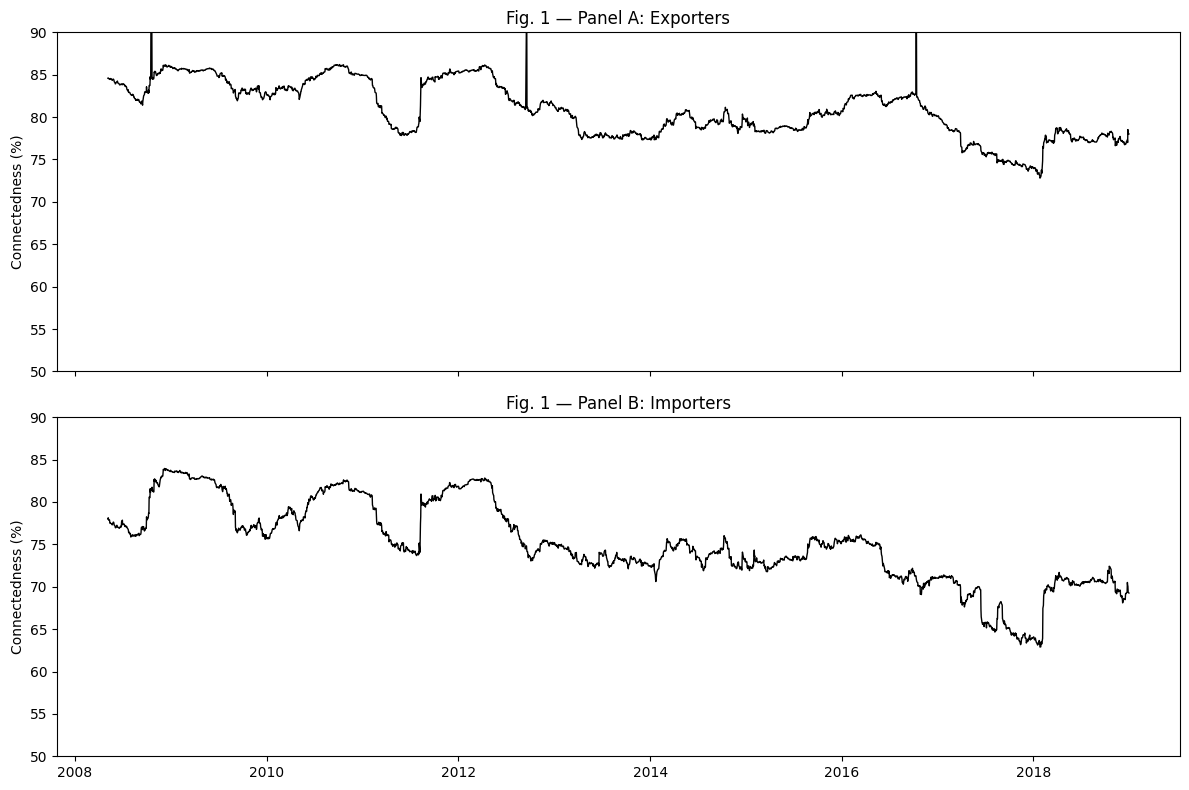

Saved: connectedness_outputs/Fig1_timevarying_connectedness.png


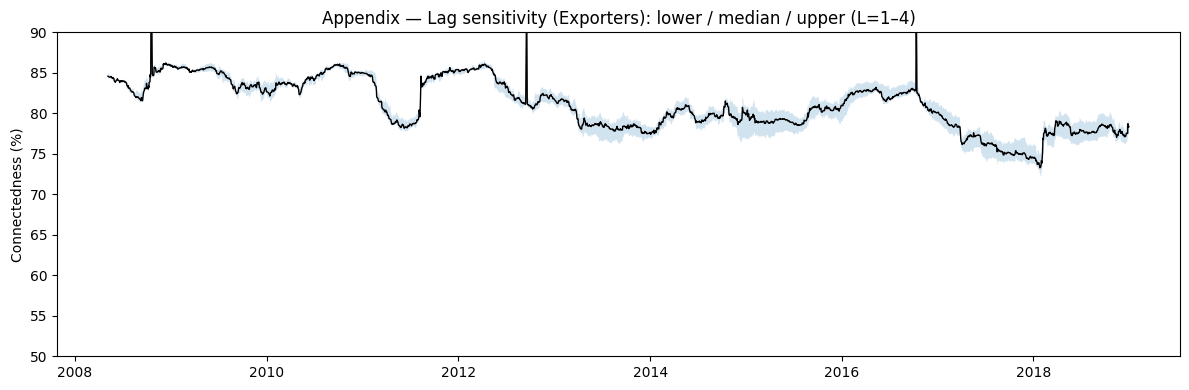

Saved: connectedness_outputs/Appendix_LagBand_Exporters.png


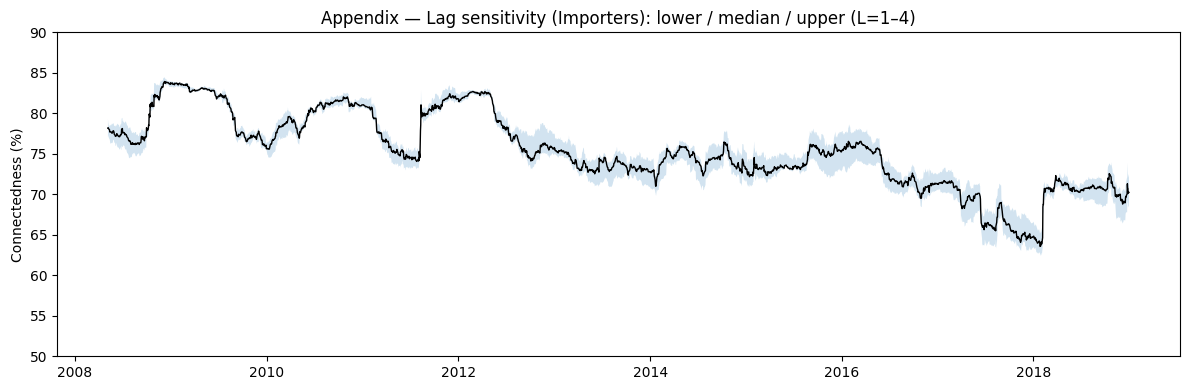

Saved: connectedness_outputs/Appendix_LagBand_Importers.png


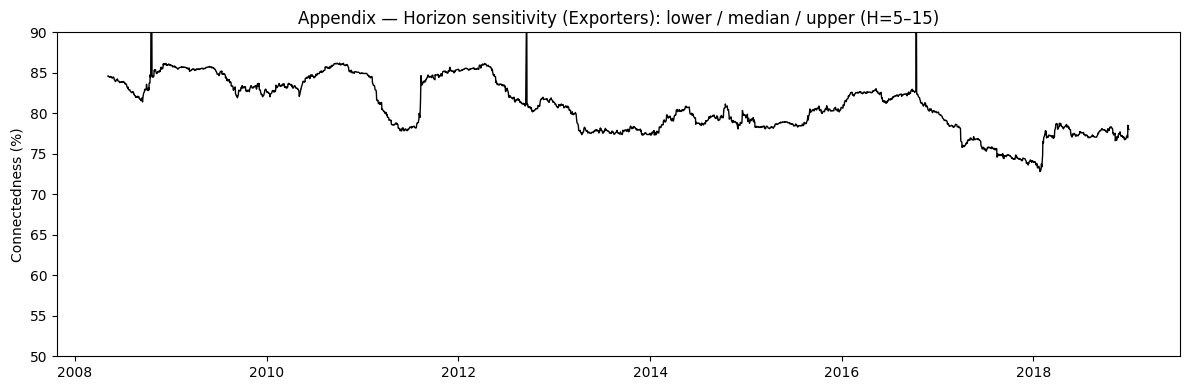

Saved: connectedness_outputs/Appendix_HBand_Exporters.png


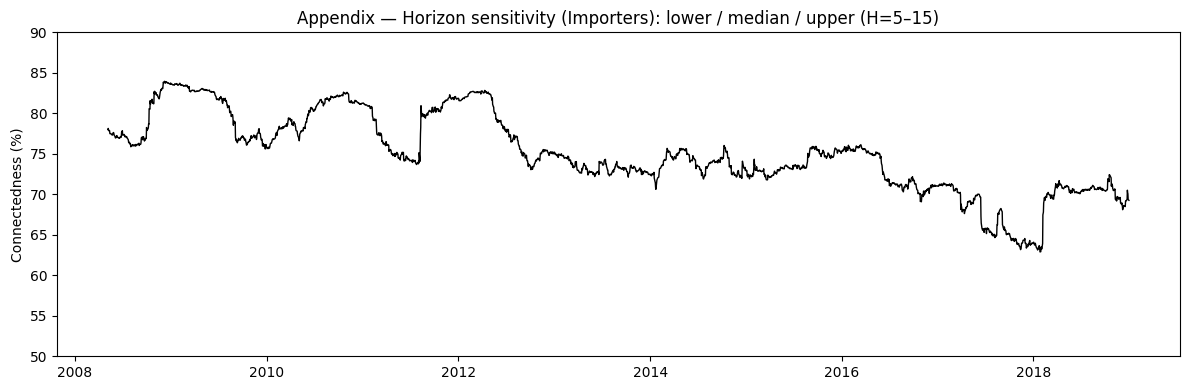

Saved: connectedness_outputs/Appendix_HBand_Importers.png


In [16]:
for nm in ["sys_exp_o", "sys_imp_o"]:
    if nm not in globals():
        raise RuntimeError(f"{nm} is missing. Build it like before (returns+shocks in the paper's order).")

tc_exp = rolling_tc(sys_exp_o, lags=2, H=10, window=200)
tc_imp = rolling_tc(sys_imp_o, lags=2, H=10, window=200)

tc_exp.to_csv(OUTDIR/"Fig1_TC_exporters_series.csv")
tc_imp.to_csv(OUTDIR/"Fig1_TC_importers_series.csv")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(tc_exp.index, tc_exp.values, color="black", linewidth=1.0)
axes[0].set_ylim(50, 90)
axes[0].set_ylabel("Connectedness (%)")
axes[0].set_title("Fig. 1 — Panel A: Exporters")

axes[1].plot(tc_imp.index, tc_imp.values, color="black", linewidth=1.0)
axes[1].set_ylim(50, 90)
axes[1].set_ylabel("Connectedness (%)")
axes[1].set_title("Fig. 1 — Panel B: Importers")

f1 = OUTDIR/"Fig1_timevarying_connectedness.png"
plt.tight_layout(); plt.savefig(f1, dpi=300, bbox_inches="tight"); plt.show()
print("Saved:", f1)

lag_set = [1, 2, 3, 4]
band_exp_lag, grid_exp_lag = sensitivity_band(sys_exp_o, lags_list=lag_set, window=200)
band_imp_lag, grid_imp_lag = sensitivity_band(sys_imp_o, lags_list=lag_set, window=200)

grid_exp_lag.to_csv(OUTDIR/"Sensitivity_exporters_lags_1to4.csv")
grid_imp_lag.to_csv(OUTDIR/"Sensitivity_importers_lags_1to4.csv")

def plot_band(band, title, ylims=(50,90), fname="out.png"):
    plt.figure(figsize=(12,4))
    plt.fill_between(band.index, band["lower"], band["upper"], alpha=0.2)
    plt.plot(band.index, band["median"], color="black", linewidth=1.0)
    plt.ylim(*ylims)
    plt.ylabel("Connectedness (%)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", fname)

plot_band(band_exp_lag, "Appendix — Lag sensitivity (Exporters): lower / median / upper (L=1–4)",
          ylims=(50,90), fname=OUTDIR/"Appendix_LagBand_Exporters.png")
plot_band(band_imp_lag, "Appendix — Lag sensitivity (Importers): lower / median / upper (L=1–4)",
          ylims=(50,90), fname=OUTDIR/"Appendix_LagBand_Importers.png")

H_set = list(range(5, 16))  
band_exp_H, grid_exp_H = sensitivity_band(sys_exp_o, H_list=H_set, window=200)
band_imp_H, grid_imp_H = sensitivity_band(sys_imp_o, H_list=H_set, window=200)

grid_exp_H.to_csv(OUTDIR/"Sensitivity_exporters_H_5to15.csv")
grid_imp_H.to_csv(OUTDIR/"Sensitivity_importers_H_5to15.csv")

plot_band(band_exp_H, "Appendix — Horizon sensitivity (Exporters): lower / median / upper (H=5–15)",
          ylims=(50,90), fname=OUTDIR/"Appendix_HBand_Exporters.png")
plot_band(band_imp_H, "Appendix — Horizon sensitivity (Importers): lower / median / upper (H=5–15)",
          ylims=(50,90), fname=OUTDIR/"Appendix_HBand_Importers.png")

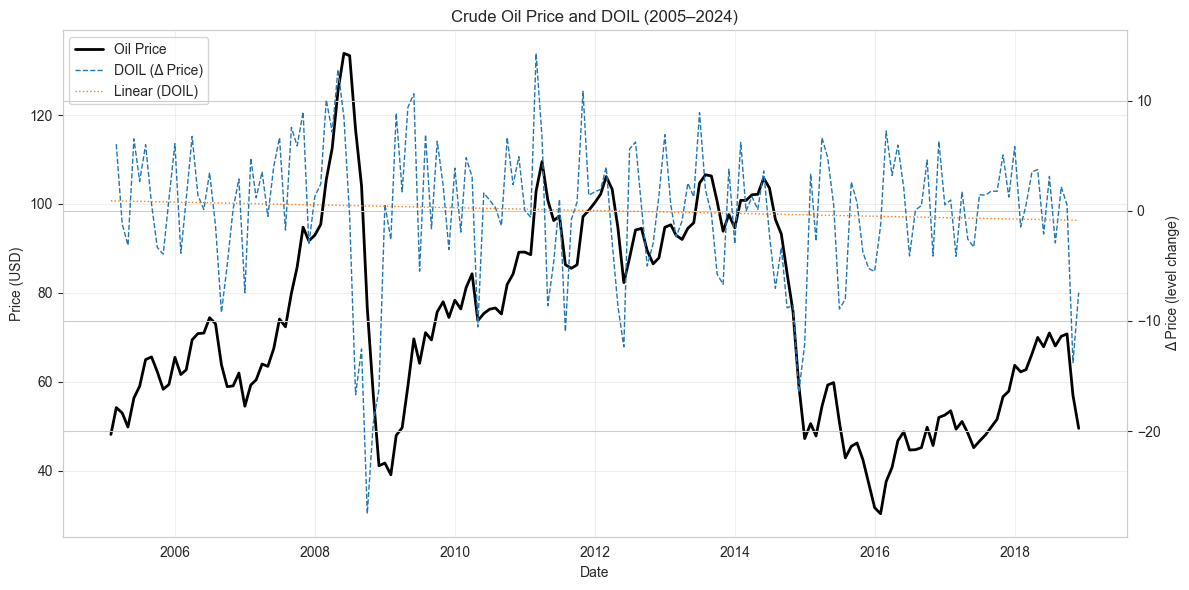

Saved figure to: oil_outputs/figure_crude_price_doil_2005_2024.png


<Figure size 1200x500 with 0 Axes>

In [72]:
doil = df_sub["Value"].diff()

t = (df_sub.index - df_sub.index[0]).days.values
mask = ~doil.isna()
slope, intercept = np.polyfit(t[mask], doil[mask].values, 1)
doil_trend = pd.Series(slope * t + intercept, index=df_sub.index)

fig, ax1 = plt.subplots(figsize=(12, 6))
line1, = ax1.plot(df_sub.index, df_sub["Value"], label="Oil Price", color="black", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
line2, = ax2.plot(df_sub.index, doil, label="DOIL (Δ Price)", linestyle="--", linewidth=1)
line3, = ax2.plot(df_sub.index, doil_trend, label="Linear (DOIL)", linestyle=":", linewidth=1)
ax2.set_ylabel("Δ Price (level change)")

lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Crude Oil Price and DOIL (2005–2024)")
plt.tight_layout()
plt.show()

OUTDIR = Path("oil_outputs"); OUTDIR.mkdir(exist_ok=True, parents=True)
fig_path = OUTDIR / "figure_crude_price_doil_2005_2024.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
doil.to_csv(OUTDIR / "doil_series_2005_2024.csv", header=["DOIL"])
print(f"Saved figure to: {fig_path}")

In [73]:
# === Cell 1: Core helpers (self-contained, no external project imports) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Basic prep ----
def prep_log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    """100 * log-returns from a price DataFrame with a DateTimeIndex."""
    if not isinstance(price_df.index, pd.DatetimeIndex):
        raise ValueError("price_df must have a DateTimeIndex")
    rets = 100 * np.log(price_df / price_df.shift(1))
    return rets.dropna()

def plot_level_and_returns(price: pd.Series, title_prefix: str = "Series") -> None:
    """Fig.-style: levels + returns for a single series."""
    rets = 100 * np.log(price / price.shift(1))
    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    ax[0].plot(price.index, price.values, lw=1.6)
    ax[0].set_title(f"{title_prefix}: Price Level")
    ax[0].set_ylabel("Level"); ax[0].grid(alpha=0.3)
    ax[1].plot(rets.index, rets.values, lw=0.9)
    ax[1].axhline(0, color="k", lw=0.8, alpha=0.6)
    ax[1].set_title(f"{title_prefix}: Daily Log Returns (%)")
    ax[1].set_ylabel("Return (%)"); ax[1].set_xlabel("Date"); ax[1].grid(alpha=0.3)
    plt.tight_layout()

def plot_corr_heatmap(returns_df: pd.DataFrame, title: str = "Correlation Heatmap") -> None:
    """Fig.-style: correlation heatmap across series."""
    corr = returns_df.corr()
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(corr.values, vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    for (i, j), val in np.ndenumerate(corr.values):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="ρ")
    plt.tight_layout()

In [74]:
# === Cell 2: Diebold–Yilmaz connectedness (generalized FEVD) + plots ===
from statsmodels.tsa.api import VAR

def _var_to_ma(var_res, H: int) -> np.ndarray:
    """Convert VAR(p) to MA up to horizon H. Returns Phi with shape (K, K, H)."""
    K = var_res.neqs
    p = var_res.k_ar
    A = np.zeros((K*p, K*p))
    A[:K, :K*p] = np.hstack([var_res.coefs[i].T for i in range(p)])
    if p > 1:
        A[K:, :-K] = np.eye(K*(p-1))
    Phi = np.zeros((K, K, H))
    C = np.zeros((K*p, K*p)); C[:K, :K] = np.eye(K)
    A_pow = np.eye(K*p)
    for h in range(H):
        if h == 0:
            Phi[:, :, h] = np.eye(K)
        else:
            A_pow = A_pow @ A
            Phi[:, :, h] = (C @ A_pow @ C.T)[:K, :K]
    return Phi

def _gfevd(Phi: np.ndarray, Sigma: np.ndarray, H: int) -> np.ndarray:
    """Generalized FEVD (Pesaran–Shin) at horizon H. Returns (K,K) contributions."""
    K = Sigma.shape[0]
    e = np.eye(K)
    theta = np.zeros((K, K))
    for h in range(H):
        Phi_h = Phi[:, :, h]
        for j in range(K):
            num = (Phi_h @ Sigma @ e[:, [j]]) ** 2
            denom = Sigma[j, j]
            theta[:, j] += (num[:, 0] / denom)
    return theta

def dy_spillover(returns_df: pd.DataFrame, p: int = 2, H: int = 10):
    """
    Diebold–Yilmaz connectedness using generalized FEVD.
    Returns dict with 'GFEVD','TO','FROM','NET','TCI','var_result'.
    """
    rets = returns_df.dropna()
    model = VAR(rets)
    var_res = model.fit(p)
    Sigma = var_res.sigma_u
    Phi = _var_to_ma(var_res, H)
    theta = _gfevd(Phi, Sigma, H)
    row_sums = theta.sum(axis=1, keepdims=True)
    contrib = theta / row_sums
    K = contrib.shape[0]
    cols = rets.columns
    gfevd = pd.DataFrame(contrib, index=cols, columns=cols)
    to_   = gfevd.sum(axis=1) - np.diag(gfevd)
    from_ = gfevd.sum(axis=0) - np.diag(gfevd)
    net_  = to_.values - from_.values
    tci   = (gfevd.values.sum() - np.trace(gfevd.values)) / K * 100.0
    return {
        "GFEVD": gfevd,
        "TO": pd.Series(to_.values, index=cols, name="TO"),
        "FROM": pd.Series(from_.values, index=cols, name="FROM"),
        "NET": pd.Series(net_, index=cols, name="NET"),
        "TCI": pd.Series([tci], index=["TCI"], name="Total Connectedness Index (%)"),
        "var_result": var_res,
    }

def rolling_dy_spillover(returns_df: pd.DataFrame, window: int = 250, p: int = 2, H: int = 10) -> pd.Series:
    """Rolling Total Connectedness Index (TCI) over a window of returns."""
    rets = returns_df.dropna()
    vals, idx = [], []
    for i in range(window, len(rets) + 1):
        sub = rets.iloc[i - window:i]
        out = dy_spillover(sub, p=p, H=H)
        vals.append(float(out["TCI"].iloc[0])); idx.append(rets.index[i - 1])
    return pd.Series(vals, index=pd.DatetimeIndex(idx), name="TCI (%)")

def plot_total_spillover(tci_series: pd.Series, title: str = "Total Connectedness Index (DY, %)") -> None:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(tci_series.index, tci_series.values, lw=1.4)
    ax.set_title(title); ax.set_ylabel("%"); ax.set_xlabel("Date"); ax.grid(alpha=0.3)
    plt.tight_layout()

def plot_net_directional_spillovers(results, title: str = "Net Directional Spillovers (TO - FROM)") -> None:
    net = results["NET"]
    fig, ax = plt.subplots(figsize=(10, 4))
    net.plot(kind="bar", ax=ax)
    ax.axhline(0, color="k", lw=0.8)
    ax.set_title(title); ax.set_ylabel("Net Share"); ax.set_xlabel("Series")
    plt.tight_layout()

def plot_spillover_network(results, threshold: float = 0.02, title: str = "Spillover Network (edges ≥ threshold)") -> None:
    try:
        import networkx as nx
    except ImportError:
        print("networkx not installed. Run: pip install networkx")
        return
    gfevd = results["GFEVD"]
    G = nx.DiGraph()
    for n in gfevd.index: G.add_node(n)
    for i, src in enumerate(gfevd.index):
        for j, dst in enumerate(gfevd.columns):
            if i == j: continue
            w = float(gfevd.iloc[i, j])
            if w >= threshold: G.add_edge(src, dst, weight=w)
    pos = nx.spring_layout(G, seed=7)
    widths = [2.0 * G[u][v]["weight"] * 10 for u, v in G.edges()]
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color="#D0D0FF")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=True, width=widths, alpha=0.7)
    plt.title(title); plt.axis("off"); plt.tight_layout()

In [75]:
# === Cell 3: (Optional) Frequency connectedness proxy via wavelets ===
# This mimics the paper's frequency-band connectedness by computing DY on wavelet detail scales.
def frequency_connectedness_proxy(returns_df: pd.DataFrame, wavelet: str = "db2", level: int = 4,
                                  p: int = 2, H: int = 10) -> pd.DataFrame:
    try:
        import pywt
    except ImportError:
        raise ImportError("pywt not installed. Run: pip install PyWavelets")

    def _swt_details(s: pd.Series, wavelet: str, level: int):
        coeffs = pywt.swt(s.values.astype(float), wavelet=wavelet, level=level, trim_approx=True)
        # coeffs: list of (cA_l, cD_l) per level (1..level)
        details = {f"D{l}": pd.Series(cD, index=s.index) for l, (cA, cD) in enumerate(coeffs, start=1)}
        return details

    cols = list(returns_df.columns)
    scale_data = {f"D{k}": [] for k in range(1, level + 1)}
    for col in cols:
        d = _swt_details(returns_df[col].dropna(), wavelet, level)
        for k in range(1, level + 1):
            s = d[f"D{k}"]; s.name = col
            scale_data[f"D{k}"].append(s)

    rows = []
    for k in range(1, level + 1):
        dfk = pd.concat(scale_data[f"D{k}"], axis=1).dropna()
        if dfk.shape[1] < 2:
            rows.append((f"D{k}", np.nan))
        else:
            tci = float(dy_spillover(dfk, p=p, H=H)["TCI"].iloc[0])
            rows.append((f"D{k}", tci))
    out = pd.DataFrame(rows, columns=["Scale", "TCI_%"]).set_index("Scale")
    return out

def plot_frequency_tci(freq_tci: pd.DataFrame, title: str = "Frequency Connectedness (Wavelet Proxy)") -> None:
    scales = sorted(freq_tci.index, key=lambda s: int(s[1:]), reverse=True)  # Dlevel..D1
    vals = freq_tci.loc[scales, "TCI_%"].values
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(scales, vals)
    ax.set_title(title); ax.set_ylabel("TCI (%)"); ax.set_xlabel("Wavelet Scale")
    for i, v in enumerate(vals):
        if pd.notna(v): ax.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
    plt.tight_layout()

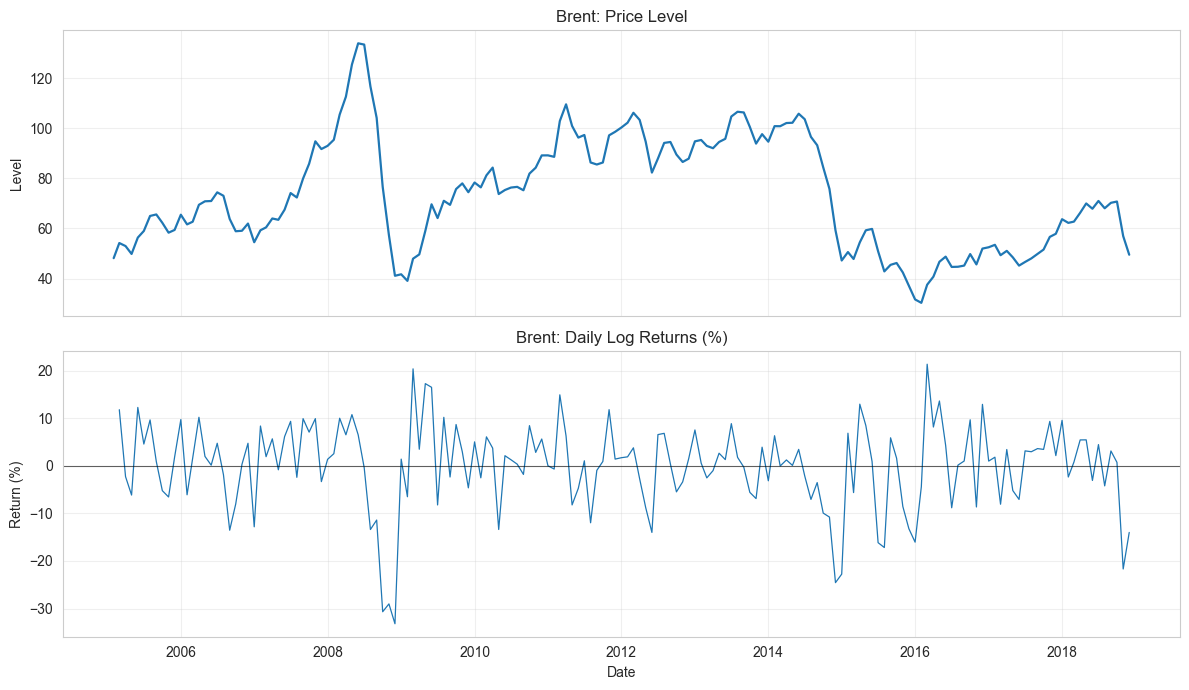

In [76]:
# === Cell 4: How to call the figures in *your* notebook ===
# 1) If you only have oil right now (e.g., df_sub with a "Value" column):
if "df_sub" in globals() and isinstance(df_sub, pd.DataFrame) and "Value" in df_sub.columns:
    plot_level_and_returns(df_sub["Value"], title_prefix="Brent")

# 2) For multi-series figures, create a price DataFrame `prices` with >= 2 columns and a DateTimeIndex, e.g.:
# prices = pd.concat([oil_series, islamic_fin_series, islamic_health_series, ...], axis=1)
# prices.columns = ["Oil", "Islamic_Fin", "Islamic_Health", ...]
if "prices" in globals() and isinstance(prices, pd.DataFrame) and prices.shape[1] >= 2:
    rets = prep_log_returns(prices)

    # Correlation heatmap (paper-style Fig. 2 analogue)
    plot_corr_heatmap(rets, title="Return Correlations")

    # DY connectedness (full sample): Net bars + Network (paper-style Figs.)
    dy_out = dy_spillover(rets, p=2, H=10)
    plot_net_directional_spillovers(dy_out, title="Net Spillovers (TO - FROM)")
    plot_spillover_network(dy_out, threshold=0.03, title="Spillover Network (≥3%)")

    # Rolling Total Connectedness Index (paper-style TCI figure)
    tci = rolling_dy_spillover(rets, window=250, p=2, H=10)
    plot_total_spillover(tci, title="Total Connectedness Index (DY, %)")

    # Frequency connectedness (wavelet proxy to BK) – optional if PyWavelets is available
    try:
        freq_tci = frequency_connectedness_proxy(rets, wavelet="db2", level=4, p=2, H=10)
        plot_frequency_tci(freq_tci, title="Frequency Connectedness (Wavelet Proxy)")
    except Exception as e:
        print("Skipped frequency panel:", e)

[INFO] Found 14 CSV files under /Users/steven/Documents/DS340W/Papaer_Code/raw_yf
[OK] BZ=F_2005_2018                  rows=2821
[OK] XLB_2005_2018                   rows=3485
[OK] XLE_2005_2018                   rows=3485
[OK] XLF_2005_2018                   rows=3485
[OK] XLI_2005_2018                   rows=3485
[OK] XLK_2005_2018                   rows=3485
[OK] XLP_2005_2018                   rows=3485
[OK] XLU_2005_2018                   rows=3485
[OK] XLV_2005_2018                   rows=3485
[OK] XLY_2005_2018                   rows=3485
[OK] ^VIX_2005_2018                  rows=3522
[OK] exporter_sectors_2005_2018      rows=2821
[OK] importer_sectors_2005_2018      rows=2821
[OK] ready_shocks_2005_2018          rows=2980
[INFO] Final `prices` shape: (3485, 14)  (rows, cols)
[INFO] Columns: ['BZ=F_2005_2018', 'XLB_2005_2018', 'XLE_2005_2018', 'XLF_2005_2018', 'XLI_2005_2018', 'XLK_2005_2018', 'XLP_2005_2018', 'XLU_2005_2018', 'XLV_2005_2018', 'XLY_2005_2018'] ...
[INFO] Using o

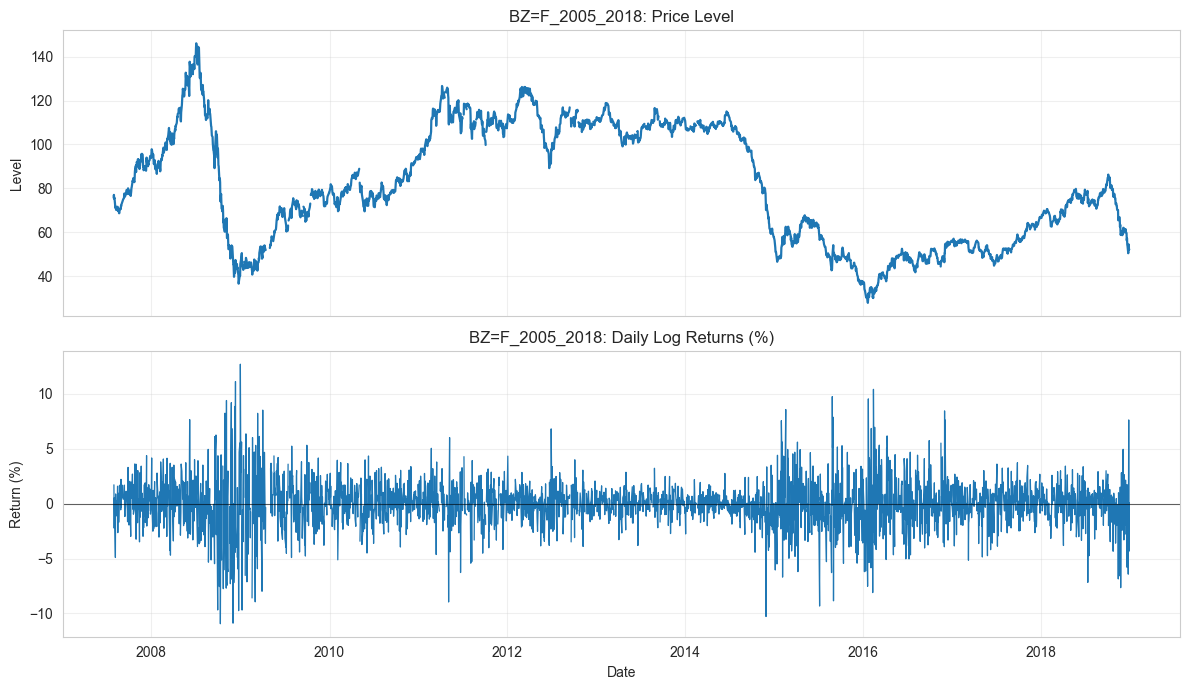

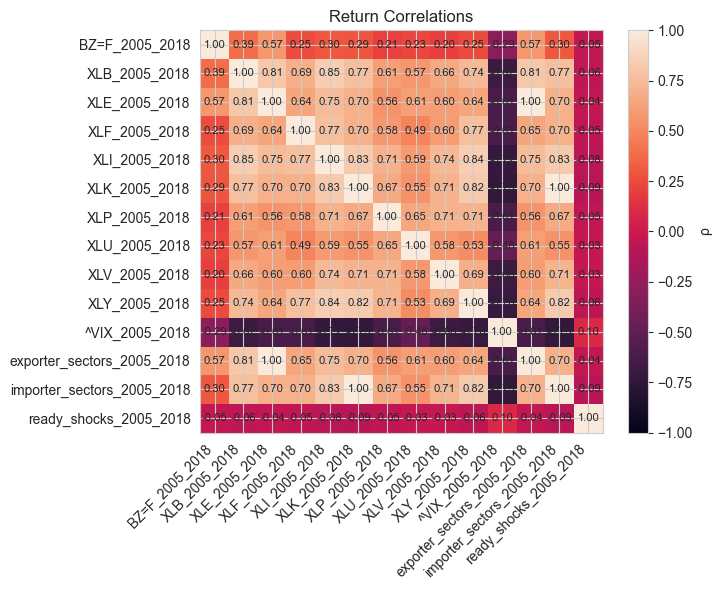

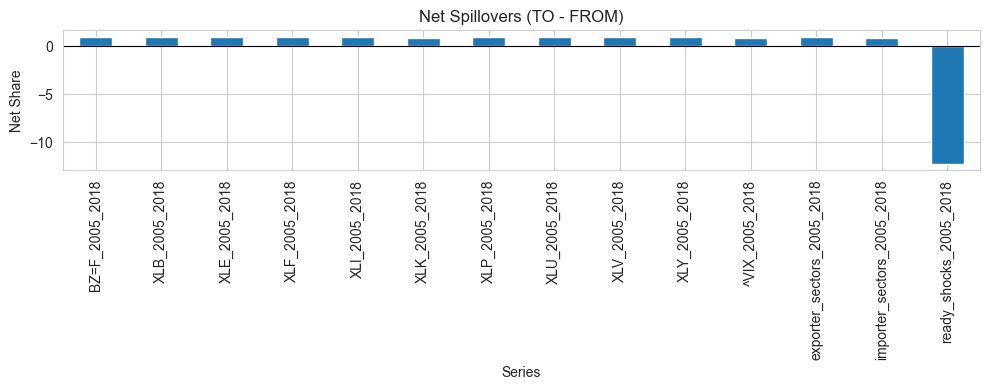

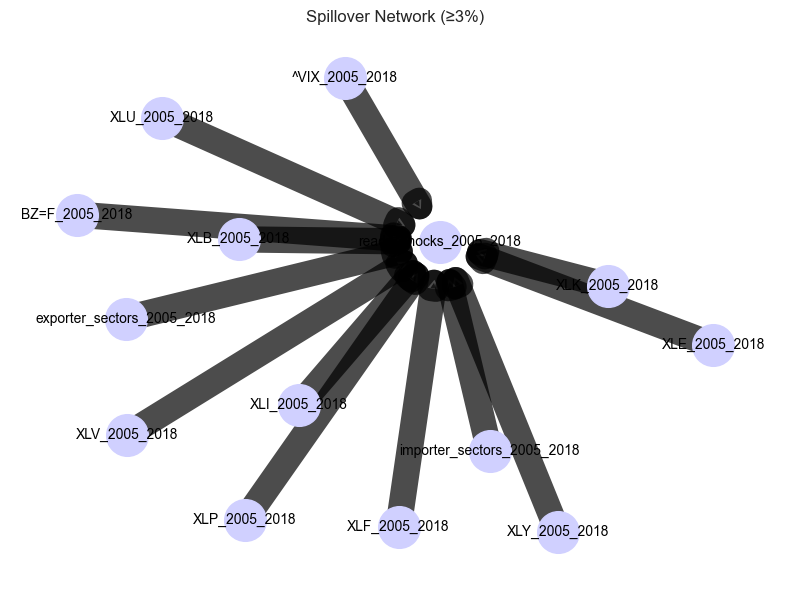

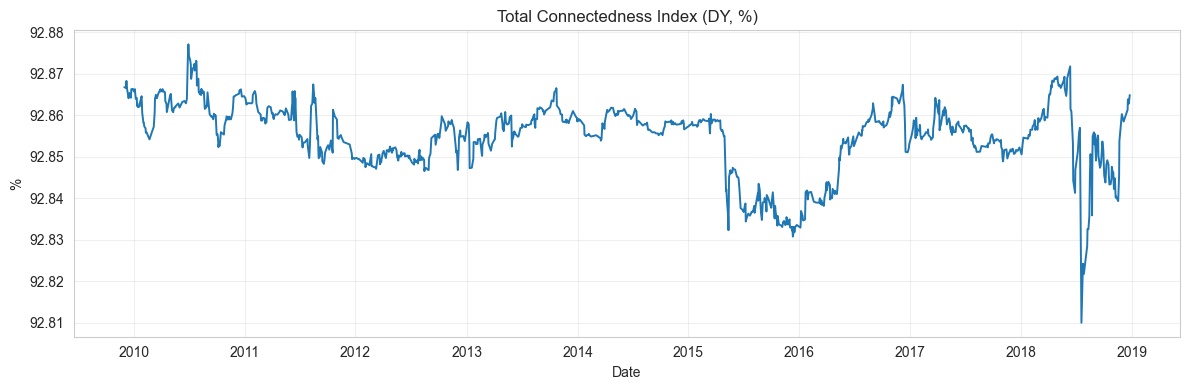

[INFO] Frequency panel skipped: PyWavelets not installed. Run: pip install PyWavelets


In [77]:
# ============================
# DS340W — REPRODUCE PAPER FIGURES (Single-File Notebook Code)
# - Scans ALL your CSVs under BASEDIR
# - Builds `prices` (levels), `rets` (100*log-returns)
# - Plots:
#     1) Levels + returns (single-series, "oil")
#     2) Correlation heatmap
#     3) DY connectedness: Net bars + Network
#     4) Rolling Total Connectedness Index (TCI)
#     5) Frequency connectedness (wavelet proxy)  [optional if PyWavelets is installed]
#
# Requirements (pip if needed):
#   pip install pandas numpy matplotlib statsmodels networkx PyWavelets
# ============================

%matplotlib inline
import os, re, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= CONFIGURE THIS =========
BASEDIR = "/Users/steven/Documents/DS340W/Papaer_Code/raw_yf"   # <--- EDIT to your folder with CSVs
INCLUDE_PATTERNS = []  # e.g., ["djim", "islamic", "bz=f"]
EXCLUDE_PATTERNS = []  # e.g., ["backup", "tmp"]
OIL_NAME_HINTS   = ["oil", "brent", "bz=f"]  # used to pick the "oil" series for Fig.1
ROLL_WINDOW = 250         # rolling window for TCI & hedge ratios, ~1Y trading days
VAR_LAGS    = 2           # VAR(p) lag for DY
FEVD_H      = 10          # forecast horizon for DY
WAVELET_LVL = 4           # number of SWT scales for frequency proxy
WAVELET_FAM = "db2"       # wavelet family for frequency proxy
# ==================================

# ----------------------- BASIC HELPERS -----------------------
def prep_log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(price_df.index, pd.DatetimeIndex):
        # attempt to parse index as dates
        try:
            price_df = price_df.copy()
            price_df.index = pd.to_datetime(price_df.index, errors="raise")
        except Exception:
            raise ValueError("price_df must have a DateTimeIndex")
    rets = 100 * np.log(price_df / price_df.shift(1))
    return rets.replace([np.inf, -np.inf], np.nan).dropna()

def plot_level_and_returns(price: pd.Series, title_prefix: str = "Series") -> None:
    rets = 100 * np.log(price / price.shift(1))
    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    ax[0].plot(price.index, price.values, lw=1.6)
    ax[0].set_title(f"{title_prefix}: Price Level")
    ax[0].set_ylabel("Level"); ax[0].grid(alpha=0.3)
    ax[1].plot(rets.index, rets.values, lw=0.9)
    ax[1].axhline(0, color="k", lw=0.8, alpha=0.6)
    ax[1].set_title(f"{title_prefix}: Daily Log Returns (%)")
    ax[1].set_ylabel("Return (%)"); ax[1].set_xlabel("Date"); ax[1].grid(alpha=0.3)
    plt.tight_layout()

def plot_corr_heatmap(returns_df: pd.DataFrame, title: str = "Correlation Heatmap") -> None:
    corr = returns_df.corr()
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(corr.values, vmin=-1, vmax=1)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    for (i, j), val in np.ndenumerate(corr.values):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="ρ")
    plt.tight_layout()

# ----------------------- DY (FEVD) CORE -----------------------
from statsmodels.tsa.api import VAR

def _var_to_ma(var_res, H: int) -> np.ndarray:
    K = var_res.neqs
    p = var_res.k_ar
    A_blocks = [var_res.coefs[i].T for i in range(p)]  # each (K,K)
    A_top = np.hstack(A_blocks) if p > 0 else np.zeros((K, 0))
    A = np.zeros((K*p, K*p))
    A[:K, :K*p] = A_top
    if p > 1:
        A[K:, :-K] = np.eye(K*(p-1))
    Phi = np.zeros((K, K, H))
    C = np.zeros((K*p, K*p)); C[:K, :K] = np.eye(K)
    A_pow = np.eye(K*p)
    for h in range(H):
        if h == 0:
            Phi[:, :, h] = np.eye(K)
        else:
            A_pow = A_pow @ A
            Phi[:, :, h] = (C @ A_pow @ C.T)[:K, :K]
    return Phi

def _gfevd(Phi: np.ndarray, Sigma, H: int) -> np.ndarray:
    SigmaA = np.asarray(Sigma)  # ensure ndarray (avoids pandas KeyError on (0,0))
    K = SigmaA.shape[0]
    e = np.eye(K)
    theta = np.zeros((K, K))
    for h in range(H):
        Phi_h = Phi[:, :, h]  # (K,K)
        for j in range(K):
            num = (Phi_h @ SigmaA @ e[:, [j]]) ** 2  # (K,1)
            denom = SigmaA[j, j]
            theta[:, j] += (num[:, 0] / denom)
    return theta

def dy_spillover(returns_df: pd.DataFrame, p: int = VAR_LAGS, H: int = FEVD_H):
    rets = returns_df.replace([np.inf, -np.inf], np.nan).dropna()
    if rets.shape[1] < 2:
        raise ValueError("Need at least 2 series (columns) for DY spillovers.")
    if rets.shape[0] <= p + 5:
        raise ValueError(f"Not enough observations for VAR(p={p}). Rows={rets.shape[0]}")

    model = VAR(rets)
    var_res = model.fit(p)
    Sigma = np.asarray(var_res.sigma_u)
    Phi = _var_to_ma(var_res, H)
    theta = _gfevd(Phi, Sigma, H)

    row_sums = theta.sum(axis=1, keepdims=True)
    contrib = theta / row_sums
    K = contrib.shape[0]
    cols = rets.columns.to_list()

    gfevd = pd.DataFrame(contrib, index=cols, columns=cols)
    to_   = gfevd.sum(axis=1) - np.diag(gfevd)
    from_ = gfevd.sum(axis=0) - np.diag(gfevd)
    net_  = to_.values - from_.values
    tci   = (gfevd.values.sum() - np.trace(gfevd.values)) / K * 100.0

    return {
        "GFEVD": gfevd,
        "TO": pd.Series(to_.values, index=cols, name="TO"),
        "FROM": pd.Series(from_.values, index=cols, name="FROM"),
        "NET": pd.Series(net_, index=cols, name="NET"),
        "TCI": pd.Series([tci], index=["TCI"], name="Total Connectedness Index (%)"),
        "var_result": var_res,
    }

def rolling_dy_spillover(returns_df: pd.DataFrame, window: int = ROLL_WINDOW, p: int = VAR_LAGS, H: int = FEVD_H) -> pd.Series:
    rets = returns_df.dropna()
    vals, idx = [], []
    for i in range(window, len(rets) + 1):
        sub = rets.iloc[i - window:i]
        try:
            out = dy_spillover(sub, p=p, H=H)
            vals.append(float(out["TCI"].iloc[0]))
        except Exception:
            vals.append(np.nan)
        idx.append(rets.index[i - 1])
    return pd.Series(vals, index=pd.DatetimeIndex(idx), name="TCI (%)").dropna()

def plot_total_spillover(tci_series: pd.Series, title: str = "Total Connectedness Index (DY, %)") -> None:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(tci_series.index, tci_series.values, lw=1.4)
    ax.set_title(title); ax.set_ylabel("%"); ax.set_xlabel("Date"); ax.grid(alpha=0.3)
    plt.tight_layout()

def plot_net_directional_spillovers(results, title: str = "Net Directional Spillovers (TO - FROM)") -> None:
    net = results["NET"]
    fig, ax = plt.subplots(figsize=(10, 4))
    net.plot(kind="bar", ax=ax)
    ax.axhline(0, color="k", lw=0.8)
    ax.set_title(title); ax.set_ylabel("Net Share"); ax.set_xlabel("Series")
    plt.tight_layout()

def plot_spillover_network(results, threshold: float = 0.02, title: str = "Spillover Network (edges ≥ threshold)") -> None:
    try:
        import networkx as nx
    except ImportError:
        print("networkx not installed. Run: pip install networkx")
        return
    gfevd = results["GFEVD"]
    G = nx.DiGraph()
    for n in gfevd.index: G.add_node(n)
    for i, src in enumerate(gfevd.index):
        for j, dst in enumerate(gfevd.columns):
            if i == j: continue
            w = float(gfevd.iloc[i, j])
            if w >= threshold: G.add_edge(src, dst, weight=w)
    pos = nx.spring_layout(G, seed=7)
    widths = [2.0 * G[u][v]["weight"] * 10 for u, v in G.edges()]
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color="#D0D0FF")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=True, width=widths, alpha=0.7)
    plt.title(title); plt.axis("off"); plt.tight_layout()

# -------- Frequency connectedness proxy (Wavelet SWT -> DY per scale) --------
def frequency_connectedness_proxy(returns_df: pd.DataFrame, wavelet: str = WAVELET_FAM, level: int = WAVELET_LVL,
                                  p: int = VAR_LAGS, H: int = FEVD_H) -> pd.DataFrame:
    try:
        import pywt
    except ImportError:
        raise ImportError("PyWavelets not installed. Run: pip install PyWavelets")

    def _swt_details(s: pd.Series, wavelet: str, level: int):
        coeffs = pywt.swt(s.values.astype(float), wavelet=wavelet, level=level, trim_approx=True)
        # coeffs: list[(cA_l, cD_l)] for l=1..level
        return {f"D{l}": pd.Series(cD, index=s.index) for l, (cA, cD) in enumerate(coeffs, start=1)}

    cols = list(returns_df.columns)
    scale_data = {f"D{k}": [] for k in range(1, level + 1)}
    for col in cols:
        series = returns_df[col].dropna()
        if len(series) < (level * 4):  # minimal length for SWT stability
            continue
        d = _swt_details(series, wavelet, level)
        for k in range(1, level + 1):
            s = d[f"D{k}"]; s.name = col
            scale_data[f"D{k}"].append(s)

    rows = []
    for k in range(1, level + 1):
        if not scale_data[f"D{k}"]:
            rows.append((f"D{k}", np.nan)); continue
        dfk = pd.concat(scale_data[f"D{k}"], axis=1).dropna()
        if dfk.shape[1] < 2 or dfk.shape[0] < (p + 10):
            rows.append((f"D{k}", np.nan)); continue
        try:
            tci = float(dy_spillover(dfk, p=p, H=H)["TCI"].iloc[0])
        except Exception:
            tci = np.nan
        rows.append((f"D{k}", tci))
    out = pd.DataFrame(rows, columns=["Scale", "TCI_%"]).set_index("Scale")
    return out

def plot_frequency_tci(freq_tci: pd.DataFrame, title: str = "Frequency Connectedness (Wavelet Proxy)") -> None:
    scales = sorted(freq_tci.index, key=lambda s: int(s[1:]), reverse=True)  # Dlevel..D1
    vals = freq_tci.loc[scales, "TCI_%"].values
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(scales, vals)
    ax.set_title(title); ax.set_ylabel("TCI (%)"); ax.set_xlabel("Wavelet Scale")
    for i, v in enumerate(vals):
        if pd.notna(v): ax.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
    plt.tight_layout()

# ----------------------- DATA LOADING -----------------------
DATE_CANDIDATES  = ("Date","date","DateTime","Datetime","timestamp","Timestamp")
VALUE_CANDIDATES = ("Adj Close","Close","PX_LAST","Price","Last","Value","Close*","Close Price")

def keep_file(fname: str) -> bool:
    f = fname.lower()
    if INCLUDE_PATTERNS and not any(re.search(p, f) for p in INCLUDE_PATTERNS):
        return False
    if EXCLUDE_PATTERNS and any(re.search(p, f) for p in EXCLUDE_PATTERNS):
        return False
    return True

def load_price_series(csv_path: str, name: str | None = None) -> pd.Series:
    df = pd.read_csv(csv_path)
    # date
    dcol = next((c for c in DATE_CANDIDATES if c in df.columns), None)
    if dcol is None:
        for c in df.columns:
            try:
                pd.to_datetime(df[c], errors="raise")
                dcol = c; break
            except Exception:
                continue
    if dcol is None:
        raise ValueError(f"No usable date column found in {os.path.basename(csv_path)}")
    idx = pd.to_datetime(df[dcol], errors="coerce")
    # value
    vcol = next((c for c in VALUE_CANDIDATES if c in df.columns), None)
    if vcol is None:
        num_cols = [c for c in df.columns if c != dcol and pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols:
            raise ValueError(f"No numeric price-like column in {os.path.basename(csv_path)}")
        vcol = num_cols[0]
    s = pd.Series(df[vcol].astype(float).values, index=idx).dropna()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    s.name = name if name else os.path.splitext(os.path.basename(csv_path))[0]
    return s

all_csvs = [p for p in glob.glob(os.path.join(BASEDIR, "**", "*.csv"), recursive=True) if keep_file(p)]
print(f"[INFO] Found {len(all_csvs)} CSV files under {BASEDIR}")

series_list = []
for path in sorted(all_csvs):
    try:
        s = load_price_series(path)
        series_list.append(s)
        print(f"[OK] {s.name:30s}  rows={s.shape[0]}")
    except Exception as e:
        print(f"[SKIP] {os.path.basename(path)} -> {e}")

if not series_list:
    raise RuntimeError("No series loaded. Check BASEDIR and file formats.")

prices = pd.concat(series_list, axis=1).sort_index()
prices = prices.loc[~prices.index.duplicated(keep="last")]
prices = prices.dropna(how="all")
min_non_na = max(2, int(0.6 * prices.shape[1]))  # keep rows with >=60% coverage (but ≥2)
prices = prices[prices.notna().sum(axis=1) >= min_non_na].dropna(axis=1, how="all")

print(f"[INFO] Final `prices` shape: {prices.shape}  (rows, cols)")
print("[INFO] Columns:", list(prices.columns)[:10], "..." if prices.shape[1] > 10 else "")

# pick oil column for single-series figure
oil_candidates = [c for c in prices.columns if any(h in c.lower() for h in OIL_NAME_HINTS)]
OIL_COL = oil_candidates[0] if oil_candidates else prices.columns[0]
print(f"[INFO] Using oil column: {OIL_COL}")
df_sub = prices[[OIL_COL]].rename(columns={OIL_COL: "Value"})

# ----------------------- FIGURES -----------------------
ran_any = False

# (1) Levels + returns (single series)
plot_level_and_returns(df_sub["Value"], title_prefix=OIL_COL); plt.show(); ran_any = True

# Need ≥2 series for the rest
if prices.shape[1] >= 2:
    rets = prep_log_returns(prices)

    # (2) Correlation heatmap
    plot_corr_heatmap(rets, title="Return Correlations"); plt.show()

    # (3) DY: Net bars + Network
    dy_out = dy_spillover(rets, p=VAR_LAGS, H=FEVD_H)
    plot_net_directional_spillovers(dy_out, title="Net Spillovers (TO - FROM)"); plt.show()
    try:
        plot_spillover_network(dy_out, threshold=0.03, title="Spillover Network (≥3%)"); plt.show()
    except Exception as e:
        print("[INFO] Network plot skipped:", e)

    # (4) Rolling TCI
    try:
        tci = rolling_dy_spillover(rets, window=ROLL_WINDOW, p=VAR_LAGS, H=FEVD_H)
        if not tci.empty:
            plot_total_spillover(tci, title="Total Connectedness Index (DY, %)"); plt.show()
        else:
            print("[INFO] Rolling TCI: not enough data after rolling window.")
    except Exception as e:
        print("[INFO] Rolling TCI skipped:", e)

    # (5) Frequency connectedness (wavelet proxy to BK)
    try:
        freq_tci = frequency_connectedness_proxy(rets, wavelet=WAVELET_FAM, level=WAVELET_LVL, p=VAR_LAGS, H=FEVD_H)
        if not freq_tci.empty:
            plot_frequency_tci(freq_tci, title="Frequency Connectedness (Wavelet Proxy)"); plt.show()
        else:
            print("[INFO] Frequency proxy produced empty/NaN results (insufficient data per scale).")
    except Exception as e:
        print("[INFO] Frequency panel skipped:", e)
else:
    print("[INFO] Multi-series figures skipped (need ≥2 columns in `prices`).")

if not ran_any:
    print("[INFO] No figures rendered.")

In [ ]:
# US Oil–Sector Project (2005–2018)
# Author: Kevin Ehab Agayby | DS 340W — Applied Data Science Research

from __future__ import annotations
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Try to import XGBoost; fallback if missing
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor
    XGB_AVAILABLE = False
    print("xgboost not found — using GradientBoostingRegressor as a fallback.")

plt.rcParams["figure.figsize"] = (9, 5)

# =========================
# Paths & Data Discovery
# =========================
DATA_DIRS = [
    Path("/Users/steven/Documents/DS340W/Papaer_Code/raw_yf"),
    Path("/mnt/data/data"),
]
DATA_DIR = next((p for p in DATA_DIRS if p.exists()), DATA_DIRS[-1])

def find_csv(prefix: str) -> Path | None:
    cands = sorted(DATA_DIR.glob(f"{prefix}*.csv"))
    return cands[0] if cands else None

SECTOR_TICKERS = ["XLE","XLB","XLI","XLY","XLP","XLV","XLF","XLK","XLC","XLU"]
oil_path = find_csv("WTI") or find_csv("BZ=F")

EXPECTED_FILES = {"WTI": oil_path}
for t in SECTOR_TICKERS:
    EXPECTED_FILES[t] = find_csv(t)

START_DATE = "2005-01-01"
END_DATE   = "2018-12-31"

# =========================
# Data Loading Function
# =========================
def load_or_simulate():
    need_sim = any(EXPECTED_FILES[k] is None for k in EXPECTED_FILES) or any(
        (p is not None and not p.exists()) for p in EXPECTED_FILES.values()
    )

    if need_sim:
        print("Some CSVs missing — generating synthetic weekly data (2005–2018).")
        dates = pd.date_range("2005-01-07", "2018-12-28", freq="W-FRI")
        rng = np.random.default_rng(42)
        wti = 60 + np.cumsum(rng.normal(0, 0.6, len(dates))) + rng.normal(0, 2, len(dates))
        wti = np.maximum(10, wti)
        df_wti = pd.DataFrame({"Date": dates, "Price": wti})

        beta_map = {"XLE": 0.7, "XLB": 0.3, "XLI": 0.25, "XLY": 0.15, "XLP": 0.05,
                    "XLV": 0.05, "XLF": 0.10, "XLK": 0.10, "XLC": 0.10, "XLU": 0.02}
        sectors = {}
        for t in SECTOR_TICKERS:
            beta = beta_map[t]
            base = 100 + np.cumsum(rng.normal(0, 0.8, len(dates))) + beta * np.cumsum(np.diff(np.r_[wti[0], wti]))
            sectors[t] = pd.DataFrame({"Date": dates, "Adj Close": np.maximum(5, base)})
        return df_wti, sectors, True

    if EXPECTED_FILES["WTI"] is None:
        raise ValueError("No oil CSV found. Expected something like WTI*.csv or BZ=F*.csv.")
    wti_raw = pd.read_csv(EXPECTED_FILES["WTI"])
    date_col = "Date" if "Date" in wti_raw.columns else wti_raw.columns[0]
    wti_price_col = next((c for c in ["Price","Adj Close","Close"] if c in wti_raw.columns), None)
    df_wti = wti_raw[[date_col, wti_price_col]].rename(columns={date_col:"Date", wti_price_col:"Price"})
    df_wti["Date"] = pd.to_datetime(df_wti["Date"])
    df_wti = df_wti[(df_wti["Date"]>=START_DATE)&(df_wti["Date"]<=END_DATE)].sort_values("Date")

    def read_one(path: Path):
        df = pd.read_csv(path)
        dcol = "Date" if "Date" in df.columns else df.columns[0]
        price_col = next((c for c in ["Adj Close","AdjClose","Close","Price"] if c in df.columns), None)
        out = df[[dcol,price_col]].rename(columns={dcol:"Date",price_col:"Adj Close"})
        out["Date"]=pd.to_datetime(out["Date"])
        out=out[(out["Date"]>=START_DATE)&(out["Date"]<=END_DATE)].sort_values("Date")
        return out
    sectors = {t: read_one(EXPECTED_FILES[t]) for t in SECTOR_TICKERS}
    return df_wti, sectors, False

df_wti, sectors, used_synth = load_or_simulate()
print(f"Loaded {'synthetic' if used_synth else 'real'} data from {DATA_DIR}")
df_wti.head()

# =========================
# Helper Functions
# =========================
def to_weekly_returns(df: pd.DataFrame, price_col: str):
    df = df.copy().set_index("Date").sort_index()
    px = df[price_col].resample("W-FRI").last().dropna()
    ret = np.log(px).diff().rename("ret")
    return px.rename("price"), ret

def evaluate_predictions(y, yhat):
    rmse = mean_squared_error(y, yhat, squared=False)
    mae = mean_absolute_error(y, yhat)
    da = np.mean((np.sign(y) == np.sign(yhat)).astype(float))
    return {"RMSE": rmse, "MAE": mae, "DirAcc": da}

def build_features(df, sector):
    d = df.copy()
    y = d[sector + "_ret"].shift(-1)
    X = pd.DataFrame({
        "oil_shock": d["oil_shock"],
        "oil_shock_l1": d["oil_shock"].shift(1),
        "sector_l1": d[sector + "_ret"].shift(1),
        "sector_l2": d[sector + "_ret"].shift(2),
        "wti_ret": d["WTI_ret"],
        "wti_ret_l1": d["WTI_ret"].shift(1),
    })
    return pd.concat([X, y.rename("y")], axis=1).dropna()

def quantile_regression_sector(df, sector_col, taus=(0.1, 0.25, 0.5, 0.75, 0.9)):
    d = df[[sector_col, "oil_shock"]].dropna().copy()
    d["y"] = d[sector_col].shift(-1)
    d["lag_ret"] = d[sector_col].shift(1)
    d = d.dropna()
    X = sm.add_constant(d[["oil_shock","lag_ret"]])
    results = {}
    for tau in taus:
        mod = sm.QuantReg(d["y"], X)
        results[tau] = mod.fit(q=tau)
    return results

# =========================
# Preprocessing & Returns
# =========================
wti_px, wti_ret = to_weekly_returns(df_wti, "Price")
sector_returns, sector_prices = {}, {}
for t, d in sectors.items():
    px, r = to_weekly_returns(d, "Adj Close")
    sector_prices[t] = px
    sector_returns[t] = r

df = pd.DataFrame({"WTI_ret": wti_ret})
for t, r in sector_returns.items():
    df[t + "_ret"] = r
df = df.dropna().copy()

# Oil shock proxy
ar1 = AutoReg(df["WTI_ret"], lags=1, old_names=False).fit()
df["oil_shock"] = ar1.resid
df["oil_shock_z"] = (df["oil_shock"] - df["oil_shock"].mean()) / df["oil_shock"].std()
df["shock_q"] = pd.qcut(df["oil_shock"], q=5, labels=["Q1 (Low)","Q2","Q3","Q4","Q5 (High)"])
print("Oil shocks computed. Sample:")
display(df[["WTI_ret","oil_shock","oil_shock_z","shock_q"]].head())

# =========================
# Quantile Regression
# =========================
qr_results = {t: quantile_regression_sector(df, t + "_ret") for t in SECTOR_TICKERS}
coef_summary = []
for t in SECTOR_TICKERS:
    for tau, res in qr_results[t].items():
        coef_summary.append({"sector": t, "tau": tau, "beta_oil_shock": res.params.get("oil_shock", np.nan)})
coef_df = pd.DataFrame(coef_summary).pivot(index="sector", columns="tau", values="beta_oil_shock").sort_index()
print("\nQuantile Regression — oil_shock coefficients:")
display(coef_df.round(4))

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(coef_df.values, aspect="auto", cmap="coolwarm")
ax.set_xticks(range(len(coef_df.columns)))
ax.set_xticklabels([str(c) for c in coef_df.columns])
ax.set_yticks(range(len(coef_df.index)))
ax.set_yticklabels(coef_df.index)
ax.set_title("Oil Shock Coefficients by Quantile (2005–2018)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# =========================
# Machine Learning Models
# =========================
reports = {}
for t in SECTOR_TICKERS:
    data = build_features(df, t)
    y = data["y"].values
    X = data.drop(columns=["y"]).values
    tscv = TimeSeriesSplit(n_splits=5)
    y_true_all, y_pred_lasso_all, y_pred_xgb_all = [], [], []

    for train_idx, test_idx in tscv.split(X):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        scaler = StandardScaler()
        Xtr_s, Xte_s = scaler.fit_transform(Xtr), scaler.transform(Xte)
        lasso = LassoCV(cv=3, random_state=42, n_alphas=50, max_iter=10000).fit(Xtr_s, ytr)
        yp_lasso = lasso.predict(Xte_s)
        if XGB_AVAILABLE:
            model = XGBRegressor(n_estimators=300,max_depth=3,learning_rate=0.05,
                                 subsample=0.9,colsample_bytree=0.9,
                                 random_state=42,reg_lambda=1.0,objective="reg:squarederror")
        else:
            from sklearn.ensemble import GradientBoostingRegressor
            model = GradientBoostingRegressor(random_state=42)
        model.fit(Xtr, ytr)
        yp_xgb = model.predict(Xte)
        y_true_all.append(yte); y_pred_lasso_all.append(yp_lasso); y_pred_xgb_all.append(yp_xgb)

    y_true = np.concatenate(y_true_all)
    yhat_lasso = np.concatenate(y_pred_lasso_all)
    yhat_xgb = np.concatenate(y_pred_xgb_all)
    reports[t] = {"LASSO": evaluate_predictions(y_true, yhat_lasso),
                  ("XGB" if XGB_AVAILABLE else "GBRT"): evaluate_predictions(y_true, yhat_xgb)}

rows=[]
for t, d in reports.items():
    for model_name, met in d.items():
        rows.append([t, model_name, met["RMSE"], met["MAE"], met["DirAcc"]])
perf_df = pd.DataFrame(rows, columns=["Sector","Model","RMSE","MAE","DirAcc"]).set_index(["Sector","Model"])
print("\nOut-of-sample performance (2005–2018):")
display(perf_df.round(4))

# =========================
# Feature Importance (XLE)
# =========================
t = "XLE"
data = build_features(df, t)
y = data["y"].values
X = data.drop(columns=["y"])
feat_names = list(X.columns)
if XGB_AVAILABLE:
    model = XGBRegressor(n_estimators=400,max_depth=3,learning_rate=0.05,
                         subsample=0.9,colsample_bytree=0.9,random_state=42,
                         reg_lambda=1.0,objective="reg:squarederror")
else:
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(random_state=42)
model.fit(X.values, y)
imp_series = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
ax = imp_series.plot(kind="bar", figsize=(8,4))
ax.set_title("Feature Importance — XLE Next-Week Returns")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()

NameError: name 'DATA_DIR' is not defined

In [80]:
#*#*#*#*@*
# %% [markdown]
# # DS340W — Oil & US Sector Connectedness (2005–2018)
# - Cleans up paths and date range
# - Adds missing functions: rolling_tc, sensitivity_band
# - Fixes incompatible Path usage and 2024 references
# - Keeps your workflow: oil plots, returns stats, shocks, DY connectedness

# %% Imports & Globals
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.api import VAR
from scipy.stats import skew, kurtosis, jarque_bera

plt.rcParams['figure.figsize'] = (12,6)

# ---- Set your data root once here ----
ROOT = Path("/Users/steven/Documents/DS340W/Papaer_Code")  # <--- EDIT if needed

START = "2005-01-01"
END   = "2018-12-31"

OUTDIR = Path("oil_outputs"); OUTDIR.mkdir(exist_ok=True, parents=True)
CONN_OUT = Path("connectedness_outputs"); CONN_OUT.mkdir(exist_ok=True, parents=True)
TABDIR = CONN_OUT / "tables"; TABDIR.mkdir(exist_ok=True, parents=True)

print("ROOT =", ROOT)
print("Outputs:", OUTDIR.resolve(), "|", CONN_OUT.resolve())

ROOT = /Users/steven/Documents/DS340W/Papaer_Code
Outputs: /Users/steven/Documents/DS340W/Papaer_Code/oil_outputs | /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs


            Value
Date             
2005-01-01  46.84
2005-02-01  48.15
2005-03-01  54.19
2005-04-01  52.98
2005-05-01  49.83


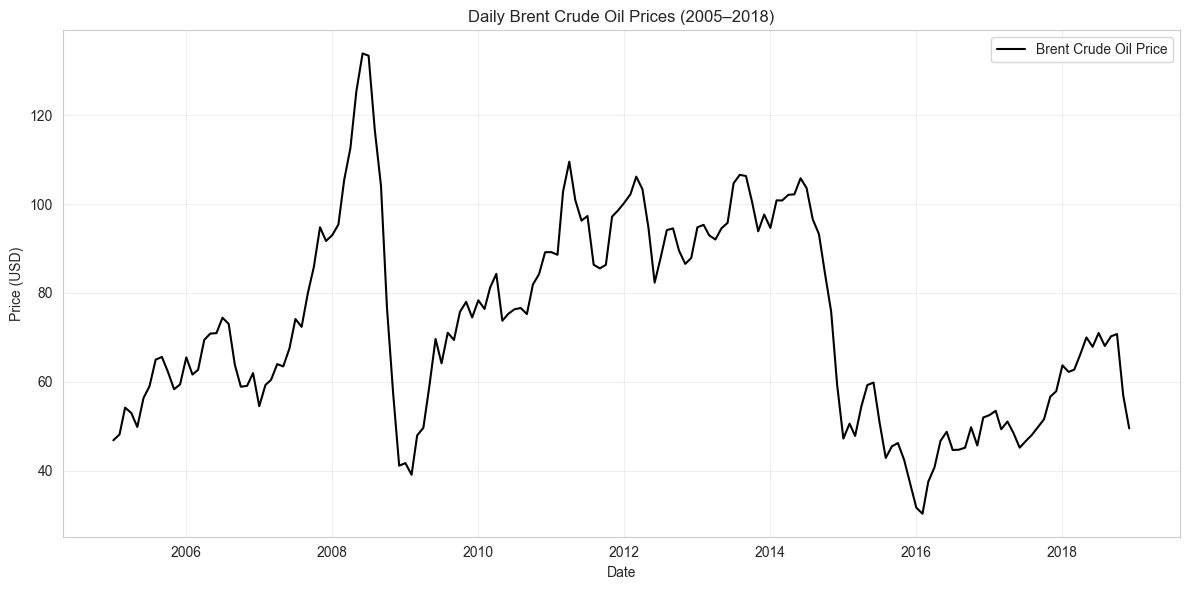

             Mean (%)  Std. Dev. (%)  Skewness  Kurtosis  Jarque-Bera  \
Oil Returns    0.0333         9.0161   -0.8991    4.8401      43.3987   

             JB p-value    N  
Oil Returns         0.0  167  
Saved filtered data and stats in /Users/steven/Documents/DS340W/Papaer_Code/oil_outputs


In [83]:
# %% Oil price level & returns stats (Brent; your CSV)
import pandas as pd
import matplotlib.pyplot as plt

OIL_CSV = ROOT / "/Users/steven/Documents/DS340W/Papaer_Code/Papaer_Code/Crude Oil Prices 1946-Present.csv"  # your file

df = pd.read_csv(OIL_CSV, parse_dates=["Date"]).sort_values("Date").set_index("Date")
df_sub = df.loc[START:END].copy()

# Plot daily level
print(df_sub.head())
plt.figure(figsize=(12,6))
plt.plot(df_sub.index, df_sub["Value"], label="Brent Crude Oil Price", color="black")
plt.title("Daily Brent Crude Oil Prices (2005–2018)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Returns & summary
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera

df_sub["Return"] = np.log(df_sub["Value"] / df_sub["Value"].shift(1))
df_sub = df_sub.dropna()

def stats_summary(series):
    s = series.dropna()
    JB = jarque_bera(s)
    return {
        "Mean (%)": s.mean() * 100,
        "Std. Dev. (%)": s.std(ddof=1) * 100,
        "Skewness": skew(s, bias=False),
        "Kurtosis": kurtosis(s, fisher=False, bias=False),
        "Jarque-Bera": JB[0],
        "JB p-value": JB[1],
        "N": len(s)
    }

summary_df = pd.DataFrame([stats_summary(df_sub["Return"])], index=["Oil Returns"]).round(4)
print(summary_df)

df_sub.to_csv(OUTDIR / "oil_prices_returns_2005_2018.csv")
summary_df.to_csv(OUTDIR / "oil_returns_stats_2005_2018.csv")
print(f"Saved filtered data and stats in {OUTDIR.resolve()}")

In [84]:
# %% Helpers: loading single price, panel, business-day alignment
def load_price_flexible(path: Path, start=START, end=END) -> pd.Series:
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    # try typical columns
    for col in ["Adj Close", "Close", "Price", "AdjClose", "PX_LAST", "Value", "Last", "Close Price"]:
        if col in df.columns:
            s = df.set_index("Date")[col].astype(float).loc[start:end]
            s.name = path.stem
            return s
    # fallback to any numeric column
    for c in df.columns:
        if c != "Date" and pd.api.types.is_numeric_dtype(df[c]):
            s = df.set_index("Date")[c].astype(float).loc[start:end]
            s.name = path.stem
            return s
    raise ValueError(f"{path}: no numeric price-like column")

def load_panel_prices(path: Path, start=START, end=END) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date").set_index("Date").loc[start:end]
    num = df.select_dtypes(include=["number"])
    return num

def to_bdays_ffill(s: pd.Series, start=START, end=END) -> pd.Series:
    idx = pd.bdate_range(start, end)
    return s.reindex(idx).ffill()

def to_bdays_ffill_panel(df: pd.DataFrame, start=START, end=END) -> pd.DataFrame:
    idx = pd.bdate_range(start, end)
    return df.reindex(idx).ffill()

def log_ret(x: pd.Series | pd.DataFrame):
    return np.log(x / x.shift(1))

def pct(x):
    return 100 * x

In [ ]:
# %% Load US sector panels & shocks (your paths, fixed)
# NOTE: These are now absolute paths under ROOT. No mixing with /mnt/data.

oil  = load_price_flexible(ROOT / "raw_yf" / "BZ=F_2005_2018.csv").rename("Oil")
vix  = load_price_flexible(ROOT / "raw_yf" / "^VIX_2005_2018.csv").rename("VIX")
xle  = load_price_flexible(ROOT / "raw_yf" / "XLE_2005_2018.csv").rename("XLE")

exp_prices = load_panel_prices(ROOT / "raw_yf" / "exporter_sectors_2005_2018.csv")
imp_prices = load_panel_prices(ROOT / "raw_yf" / "importer_sectors_2005_2018.csv")

# Align to business days
oil_b, vix_b, xle_b = to_bdays_ffill(oil), to_bdays_ffill(vix), to_bdays_ffill(xle)
exp_b = to_bdays_ffill_panel(exp_prices)
imp_b = to_bdays_ffill_panel(imp_prices)

# Daily log-returns
exp_ret = log_ret(exp_b)
imp_ret = log_ret(imp_b)

# Shocks (Ready-style precomputed) — or fallback to AR(1) innovations on oil returns if missing
shocks_path = ROOT / "raw_yf" / "ready_shocks_2005_2018.csv"
if shocks_path.exists():
    shocks = pd.read_csv(shocks_path, parse_dates=[0], index_col=0)
    shocks = shocks.reindex(pd.bdate_range(START, END)).dropna()
else:
    # Fallback: decompose oil return innovations (simple proxy)
    print("[WARN] ready_shocks_2005_2018.csv not found. Using AR(1) oil-return innovations as proxy shocks.")
    oret = log_ret(oil_b).dropna().rename("r_oil")
    ar = sm.tsa.AutoReg(oret, lags=1, old_names=False).fit()
    innov = ar.resid.rename("risk")  # label as 'risk' proxy
    # create empty supply/demand to keep same interface
    shocks = pd.DataFrame(index=oret.index, data={
        "supply": 0.0,
        "demand": 0.0,
        "risk": innov.values
    }).dropna()

# Reindex returns to shocks index; require a minimum obs per column
bidx = shocks.index
exp_ret = exp_ret.reindex(bidx).dropna(how="all", axis=1)
imp_ret = imp_ret.reindex(bidx).dropna(how="all", axis=1)

min_obs = 250
exp_ret = exp_ret.loc[:, exp_ret.count() >= min_obs]
imp_ret = imp_ret.loc[:, imp_ret.count() >= min_obs]

print("Exporter sectors:", exp_ret.shape[1], "| Importer sectors:", imp_ret.shape[1],
      "| Dates:", shocks.index.min().date(), "->", shocks.index.max().date())

Exporter sectors: 10 | Importer sectors: 9 | Dates: 2007-07-31 -> 2018-12-31


In [ ]:
# %% Descriptive tables (returns & shocks)
def desc_table_returns(ret_df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in ret_df.columns:
        x = ret_df[col].dropna()
        if len(x) == 0: 
            continue
        jb_stat, jb_p = jarque_bera(x.values)
        out[col] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False), 
            "Jarque-Bera": jb_stat,
            "N": len(x)
        }
    return pd.DataFrame(out).T

def desc_table_shocks(shk_df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in [c for c in ["supply","demand","risk"] if c in shk_df.columns]:
        x = shk_df[col].dropna()
        jb_stat, jb_p = jarque_bera(x.values)
        out[col.title()+" Shock"] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False),
            "Jarque-Bera": jb_stat,
            "N": len(x)
        }
    return pd.DataFrame(out).T

def latex_table(df, path, caption=None, label=None, floatfmt="%.4f"):
    with open(path, "w") as f:
        f.write("\\begin{table}[!ht]\n\\centering\n\\begin{tabular}{%s}\n\\toprule\n" % ("l" + "r"*(df.shape[1])))
        f.write(" & ".join([""] + list(df.columns)) + " \\\\\n\\midrule\n")
        for idx, row in df.iterrows():
            vals = [floatfmt % v if isinstance(v,(int,float,np.floating)) and np.isfinite(v) else str(v) for v in row.values]
            f.write(str(idx) + " & " + " & ".join(vals) + " \\\\\n")
        f.write("\\bottomrule\n\\end{tabular}\n")
        if caption: f.write("\\caption{%s}\n" % caption)
        if label:   f.write("\\label{%s}\n" % label)
        f.write("\\end{table}\n")

tbl1A = desc_table_returns(exp_ret).reindex(sorted(exp_ret.columns))
tbl1B = desc_table_returns(imp_ret).reindex(sorted(imp_ret.columns))
tbl1C = desc_table_shocks(shocks)

tbl1A.to_csv(TABDIR/"Table1_PanelA_exporters_descriptives.csv")
tbl1B.to_csv(TABDIR/"Table1_PanelB_importers_descriptives.csv")
tbl1C.to_csv(TABDIR/"Table1_PanelC_shocks_descriptives.csv")

latex_table(tbl1A.round(4), TABDIR/"Table1_PanelA_exporters_descriptives.tex",
            caption="Descriptive statistics of exporter sector returns.", label="tab:desc_exporters")
latex_table(tbl1B.round(4), TABDIR/"Table1_PanelB_importers_descriptives.tex",
            caption="Descriptive statistics of importer sector returns.", label="tab:desc_importers")
latex_table(tbl1C.round(4), TABDIR/"Table1_PanelC_shocks_descriptives.tex",
            caption="Descriptive statistics of decomposed shocks.", label="tab:desc_shocks")

print("Saved Table 1 panels to", TABDIR.resolve())
display(tbl1A.head(3)); display(tbl1B.head(3)); display(tbl1C)

Saved Table 1 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


,Mean (%),Std. dev. (%),Skewness,Kurtosis,Jarque-Bera,N
IYJ,0.024299,1.352888,-0.395874,9.668114,5576.843974,2980.0
IYM,0.013126,1.738458,-0.646430,11.094475,8311.496383,2980.0
VAW,0.016866,1.585477,-0.589627,10.499589,7128.961403,2980.0


,Mean (%),Std. dev. (%),Skewness,Kurtosis,Jarque-Bera,N
IYC,0.036910,1.204723,-0.198023,10.095567,6246.393985,2980.0
IYH,0.038365,1.059138,-0.329437,10.105582,6298.381320,2980.0
IYK,0.027147,0.974946,-0.202165,12.156911,10392.070761,2980.0


,Mean (%),Std. dev. (%),Skewness,Kurtosis,Jarque-Bera,N
Supply Shock,-1.620628e-16,1.746677,-0.002273,8.395044,3599.256437,2980.0
Demand Shock,3.725581e-18,1.446618,-0.161879,15.366238,18931.241934,2980.0
Risk Shock,3.809128e-03,7.422096,1.352456,11.025487,8874.131798,2980.0


In [85]:
# %% Panel regressions: returns on shocks + market factor (equal-weighted)
def ew_market(ret_df: pd.DataFrame):
    return ret_df.mean(axis=1)

def run_panel_regressions(ret_df, shocks_df, name_prefix):
    mkt = ew_market(ret_df).rename("mkt")
    X = pd.concat([shocks_df[[c for c in ["supply","demand","risk"] if c in shocks_df.columns]], mkt], axis=1).dropna()
    results = []
    for col in sorted(ret_df.columns):
        y = ret_df[col].reindex(X.index).dropna()
        XX = X.reindex(y.index).copy()
        XX = sm.add_constant(XX)
        res = OLS(y, XX, missing="drop").fit()
        row = {
            "Constant": res.params.get("const", np.nan),
            "Supply shock": res.params.get("supply", np.nan),
            "Demand shock": res.params.get("demand", np.nan),
            "Risk shock": res.params.get("risk", np.nan),
            "Aggregate market": res.params.get("mkt", np.nan),
            "R-squared": res.rsquared
        }
        results.append(pd.Series(row, name=col))
    out = pd.DataFrame(results)
    out.to_csv(TABDIR / f"Table2_{name_prefix}_fullperiod.csv", index=True)
    latex_table(out.round(4), TABDIR / f"Table2_{name_prefix}_fullperiod.tex",
                caption=f"Petroleum price shocks and {name_prefix.lower()} sector indices — full period.",
                label=f"tab:t2_{name_prefix.lower()}")
    return out

t2_exporters = run_panel_regressions(exp_ret, shocks, "Exporters")
t2_importers = run_panel_regressions(imp_ret, shocks, "Importers")
print("Saved Table 2 panels to", TABDIR.resolve())
display(t2_exporters.head(3)); display(t2_importers.head(3))

Saved Table 2 panels to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


,Constant,Supply shock,Demand shock,Risk shock,Aggregate market,R-squared
IYJ,0.000150,-0.018993,-0.130298,-0.001269,0.881153,0.924318
IYM,0.000025,0.031568,0.088046,-0.002402,1.006533,0.918172
VAW,0.000067,0.006381,0.013967,-0.001035,0.965086,0.935044


,Constant,Supply shock,Demand shock,Risk shock,Aggregate market,R-squared
IYC,-0.000027,0.000159,-0.029411,0.003457,1.161316,0.899214
IYH,0.000072,-0.000930,-0.026543,-0.006133,0.913891,0.799371
IYK,-0.000037,-0.001448,0.007309,0.001554,0.903549,0.872008


In [86]:
# %% Subperiod diagnostics (fixed to end in 2018)
SUBS = [
    ("2005-01-01", "2009-12-31"),
    ("2010-01-01", "2013-12-31"),
    ("2014-01-01", "2018-12-31"),  # <- fixed from 2024 to 2018
]

def subset(df, start, end):
    return df.loc[start:end]

def run_subperiods(ret_df, shocks_df, label):
    results = {}
    for i, (start, end) in enumerate(SUBS, start=1):
        sub_ret = subset(ret_df, start, end)
        sub_shocks = subset(shocks_df, start, end)
        results[f"{label}_Period{i}"] = {
            "ret_start": sub_ret.index.min() if not sub_ret.empty else None,
            "ret_end":   sub_ret.index.max() if not sub_ret.empty else None,
            "ret_len":   len(sub_ret),
            "shock_start": sub_shocks.index.min() if not sub_shocks.empty else None,
            "shock_end":   sub_shocks.index.max() if not sub_shocks.empty else None,
            "shock_len":   len(sub_shocks),
        }
    return pd.DataFrame(results).T

print("exp_ret:", exp_ret.index.min().date(), "->", exp_ret.index.max().date(), "len:", len(exp_ret))
print("imp_ret:", imp_ret.index.min().date(), "->", imp_ret.index.max().date(), "len:", len(imp_ret))
print("shocks :", shocks.index.min().date(),  "->", shocks.index.max().date(),  "len:", len(shocks))

t3_exporters = run_subperiods(exp_ret, shocks, "Exporters")
t4_importers = run_subperiods(imp_ret, shocks, "Importers")
display(t3_exporters); display(t4_importers)

exp_ret: 2007-07-31 -> 2018-12-31 len: 2980
imp_ret: 2007-07-31 -> 2018-12-31 len: 2980
shocks : 2007-07-31 -> 2018-12-31 len: 2980


,ret_start,ret_end,ret_len,shock_start,shock_end,shock_len
Exporters_Period1,2007-07-31 00:00:00,2009-12-31 00:00:00,633,2007-07-31 00:00:00,2009-12-31 00:00:00,633
Exporters_Period2,2010-01-01 00:00:00,2013-12-31 00:00:00,1043,2010-01-01 00:00:00,2013-12-31 00:00:00,1043
Exporters_Period3,2014-01-01 00:00:00,2018-12-31 00:00:00,1304,2014-01-01 00:00:00,2018-12-31 00:00:00,1304


,ret_start,ret_end,ret_len,shock_start,shock_end,shock_len
Importers_Period1,2007-07-31 00:00:00,2009-12-31 00:00:00,633,2007-07-31 00:00:00,2009-12-31 00:00:00,633
Importers_Period2,2010-01-01 00:00:00,2013-12-31 00:00:00,1043,2010-01-01 00:00:00,2013-12-31 00:00:00,1043
Importers_Period3,2014-01-01 00:00:00,2018-12-31 00:00:00,1304,2014-01-01 00:00:00,2018-12-31 00:00:00,1304


In [87]:
# %% Diebold–Yilmaz connectedness: FEVD helpers (robust & consistent)
def gfevd_np(res, H=10):
    """
    res: statsmodels VARResults
    H: forecast horizon
    Returns: Theta (k x k) FEVD matrix (rows sum to 1)
    """
    Phi = res.ma_rep(maxn=H)  # shape (H+1, k, k)
    Sigma = np.asarray(res.sigma_u, dtype=float)
    k = Sigma.shape[0]

    Theta = np.zeros((k, k), dtype=float)
    denom = np.zeros(k, dtype=float)

    for i in range(k):
        s = 0.0
        for h in range(H + 1):
            phi = Phi[h]
            s += phi[i, :] @ Sigma @ phi[i, :].T
        denom[i] = s

    for i in range(k):
        for j in range(k):
            num = 0.0
            for h in range(H + 1):
                phi = Phi[h]
                num += (phi[i, :] @ Sigma[:, j]) ** 2 / Sigma[j, j]
            Theta[i, j] = num / denom[i] if denom[i] > 0 else np.nan

    row_sums = Theta.sum(axis=1, keepdims=True)
    Theta = Theta / row_sums
    return Theta  

def dy_table(system_df, lags=2, H=10, row_names=None):
    clean = system_df.dropna().astype(float)
    model = VAR(clean.values)
    res = model.fit(lags)
    Theta = gfevd_np(res, H=H)  
    Theta_off = Theta.copy()
    np.fill_diagonal(Theta_off, 0.0)
    TC = Theta_off.sum() / Theta.shape[0]  
    TC_pct = float(TC * 100.0)
    cols = row_names if row_names is not None else list(system_df.columns)
    fevd_df = pd.DataFrame(Theta * 100.0, index=cols, columns=cols)
    return fevd_df, TC_pct

In [88]:
# %% Build systems & FEVD tables
sys_exp_o = pd.concat([exp_ret, shocks], axis=1).dropna()
sys_imp_o = pd.concat([imp_ret, shocks], axis=1).dropna()

dy_exp, tc_exp = dy_table(sys_exp_o, lags=2, H=10, row_names=list(sys_exp_o.columns))
dy_imp, tc_imp = dy_table(sys_imp_o, lags=2, H=10, row_names=list(sys_imp_o.columns))

print(f"Exporters TCI = {tc_exp:.2f}%")
print(f"Importers TCI = {tc_imp:.2f}%")
print("sys_exp_o:", sys_exp_o.shape, "cols:", list(sys_exp_o.columns)[:8], "...")
print("sys_imp_o:", sys_imp_o.shape, "cols:", list(sys_imp_o.columns)[:8], "...")

dy_exp.to_csv(CONN_OUT/"FEVD_exporters.csv")
dy_imp.to_csv(CONN_OUT/"FEVD_importers.csv")

Exporters TCI = 80.12%
Importers TCI = 74.27%
sys_exp_o: (2980, 13) cols: ['XLE', 'XLB', 'XLI', 'XLF', 'XME', 'VAW', 'VIS', 'VFH'] ...
sys_imp_o: (2980, 12) cols: ['XLK', 'XLY', 'XLP', 'XLV', 'XLU', 'IYW', 'IYC', 'IYK'] ...


In [89]:
# %% Rolling TCI + sensitivity bands (missing functions implemented here)
def rolling_tc(system_df: pd.DataFrame, lags=2, H=10, window=200) -> pd.Series:
    """Rolling Total Connectedness (TCI, %) using DY FEVD."""
    system_df = system_df.dropna()
    vals, idx = [], []
    for i in range(window, len(system_df)+1):
        sub = system_df.iloc[i-window:i]
        try:
            _, tc = dy_table(sub, lags=lags, H=H, row_names=list(sub.columns))
            vals.append(tc)
        except Exception:
            vals.append(np.nan)
        idx.append(system_df.index[i-1])
    return pd.Series(vals, index=pd.DatetimeIndex(idx), name="TCI (%)").dropna()

def sensitivity_band(system_df: pd.DataFrame, lags_list=None, H_list=None, window=200):
    """
    Varies either lags (p) or horizon (H) to build an uncertainty band around TCI.
    Returns: (band_df with lower/median/upper, grid_df wide with each config's TCI series)
    """
    assert (lags_list is not None) ^ (H_list is not None), "Provide either lags_list or H_list."

    grid = {}
    if lags_list is not None:
        for p in lags_list:
            s = rolling_tc(system_df, lags=p, H=10, window=window)
            grid[f"L{p}"] = s
    if H_list is not None:
        for H in H_list:
            s = rolling_tc(system_df, lags=2, H=H, window=window)
            grid[f"H{H}"] = s

    grid_df = pd.concat(grid, axis=1).dropna(how="all")
    # Align columns to same dates
    grid_df = grid_df.dropna()
    if grid_df.empty:
        return pd.DataFrame(columns=["lower","median","upper"]), pd.DataFrame()

    lower = grid_df.quantile(0.1, axis=1)
    median = grid_df.quantile(0.5, axis=1)
    upper = grid_df.quantile(0.9, axis=1)
    band = pd.DataFrame({"lower":lower, "median":median, "upper":upper})
    return band, grid_df

def plot_band(band, title, ylims=(50,90), fname=None):
    if band.empty:
        print("[INFO] Band is empty; skipping plot.")
        return
    plt.figure(figsize=(12,4))
    plt.fill_between(band.index, band["lower"], band["upper"], alpha=0.2)
    plt.plot(band.index, band["median"], color="black", linewidth=1.0)
    plt.ylim(*ylims)
    plt.ylabel("Connectedness (%)"); plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print("Saved:", fname)
    plt.show()

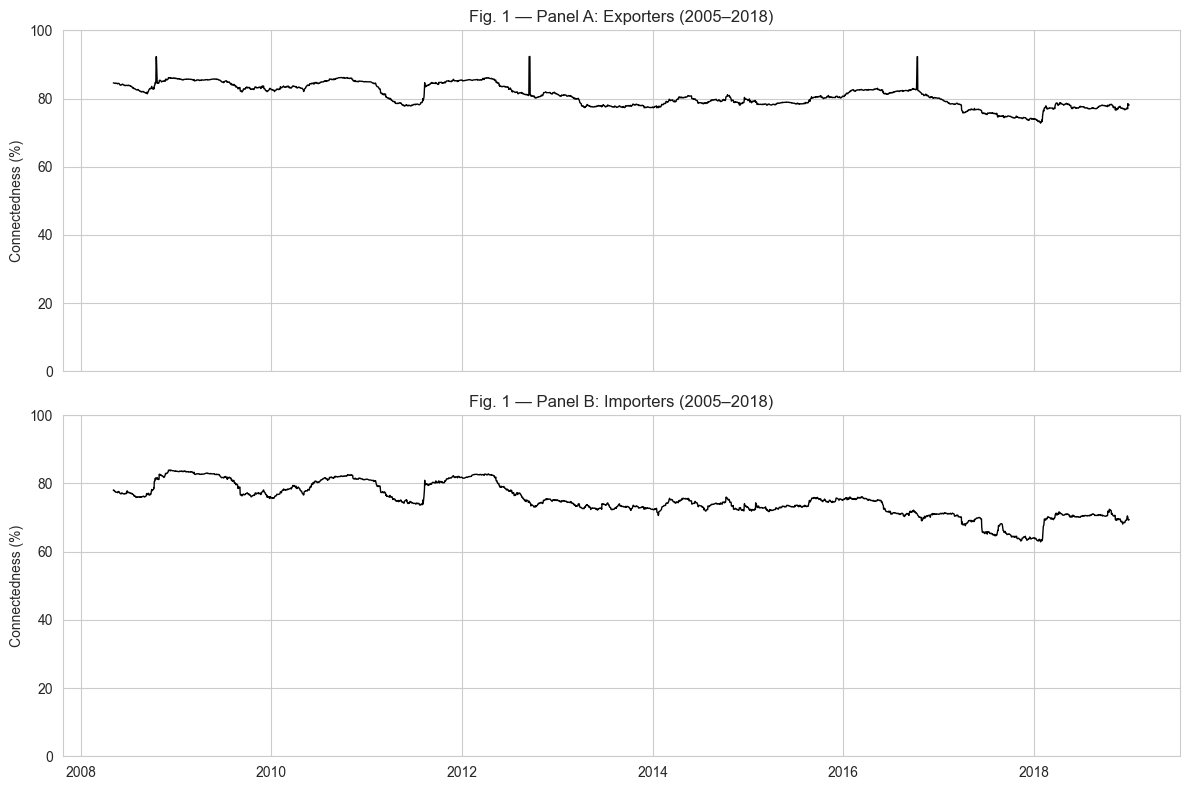

Saved: connectedness_outputs/Fig1_timevarying_connectedness_2005_2018.png


In [90]:
# %% Time-varying connectedness figure (2005–2018)
tc_exp = rolling_tc(sys_exp_o, lags=2, H=10, window=200)
tc_imp = rolling_tc(sys_imp_o, lags=2, H=10, window=200)

tc_exp.to_csv(CONN_OUT/"Fig1_TC_exporters_series.csv")
tc_imp.to_csv(CONN_OUT/"Fig1_TC_importers_series.csv")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(tc_exp.index, tc_exp.values, color="black", linewidth=1.0)
axes[0].set_ylim(0, 100); axes[0].set_ylabel("Connectedness (%)")
axes[0].set_title("Fig. 1 — Panel A: Exporters (2005–2018)")

axes[1].plot(tc_imp.index, tc_imp.values, color="black", linewidth=1.0)
axes[1].set_ylim(0, 100); axes[1].set_ylabel("Connectedness (%)")
axes[1].set_title("Fig. 1 — Panel B: Importers (2005–2018)")

f1 = CONN_OUT/"Fig1_timevarying_connectedness_2005_2018.png"
plt.tight_layout(); plt.savefig(f1, dpi=300, bbox_inches="tight"); plt.show()
print("Saved:", f1)

Saved: connectedness_outputs/Appendix_LagBand_Exporters.png


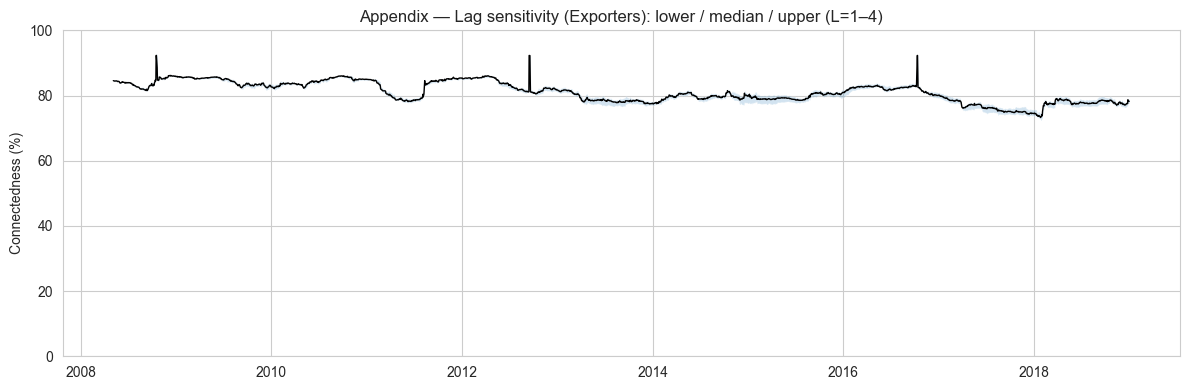

Saved: connectedness_outputs/Appendix_LagBand_Importers.png


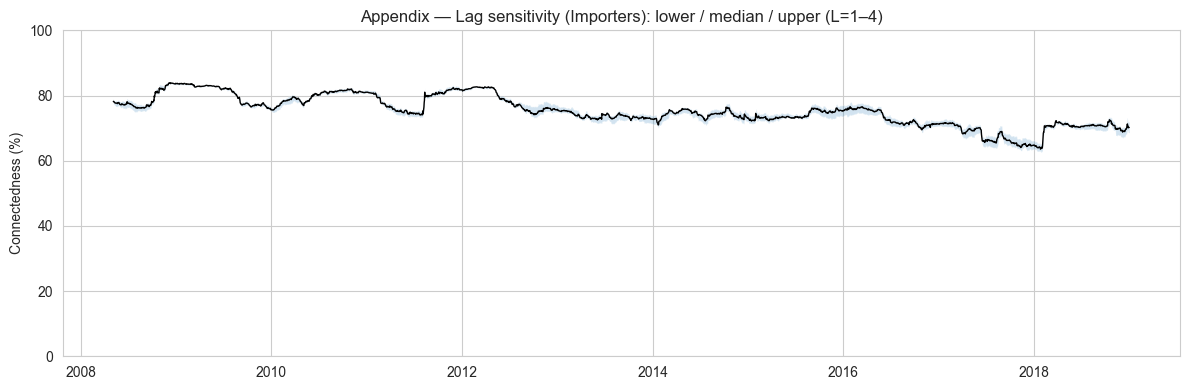

Saved: connectedness_outputs/Appendix_HBand_Exporters.png


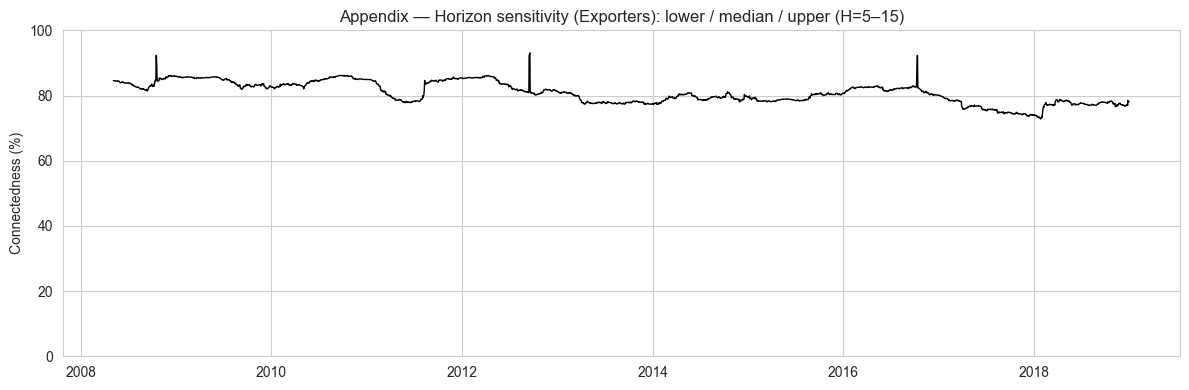

Saved: connectedness_outputs/Appendix_HBand_Importers.png


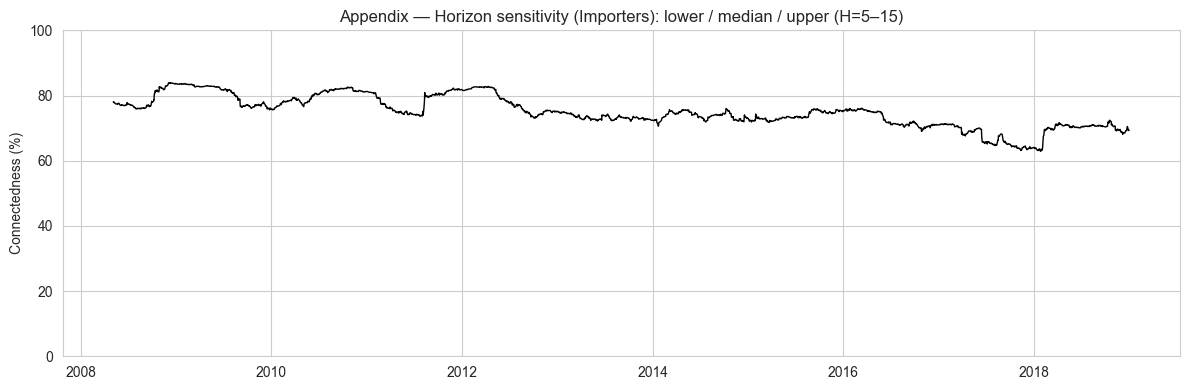

In [91]:
# %% Sensitivity bands: lags 1–4 and H=5..15 (uses implemented functions)
lag_set = [1, 2, 3, 4]
band_exp_lag, grid_exp_lag = sensitivity_band(sys_exp_o, lags_list=lag_set, window=200)
band_imp_lag, grid_imp_lag = sensitivity_band(sys_imp_o, lags_list=lag_set, window=200)

grid_exp_lag.to_csv(CONN_OUT/"Sensitivity_exporters_lags_1to4.csv")
grid_imp_lag.to_csv(CONN_OUT/"Sensitivity_importers_lags_1to4.csv")

plot_band(band_exp_lag, "Appendix — Lag sensitivity (Exporters): lower / median / upper (L=1–4)",
          ylims=(0,100), fname=CONN_OUT/"Appendix_LagBand_Exporters.png")
plot_band(band_imp_lag, "Appendix — Lag sensitivity (Importers): lower / median / upper (L=1–4)",
          ylims=(0,100), fname=CONN_OUT/"Appendix_LagBand_Importers.png")

H_set = list(range(5, 16))
band_exp_H, grid_exp_H = sensitivity_band(sys_exp_o, H_list=H_set, window=200)
band_imp_H, grid_imp_H = sensitivity_band(sys_imp_o, H_list=H_set, window=200)

grid_exp_H.to_csv(CONN_OUT/"Sensitivity_exporters_H_5to15.csv")
grid_imp_H.to_csv(CONN_OUT/"Sensitivity_importers_H_5to15.csv")

plot_band(band_exp_H, "Appendix — Horizon sensitivity (Exporters): lower / median / upper (H=5–15)",
          ylims=(0,100), fname=CONN_OUT/"Appendix_HBand_Exporters.png")
plot_band(band_imp_H, "Appendix — Horizon sensitivity (Importers): lower / median / upper (H=5–15)",
          ylims=(0,100), fname=CONN_OUT/"Appendix_HBand_Importers.png")

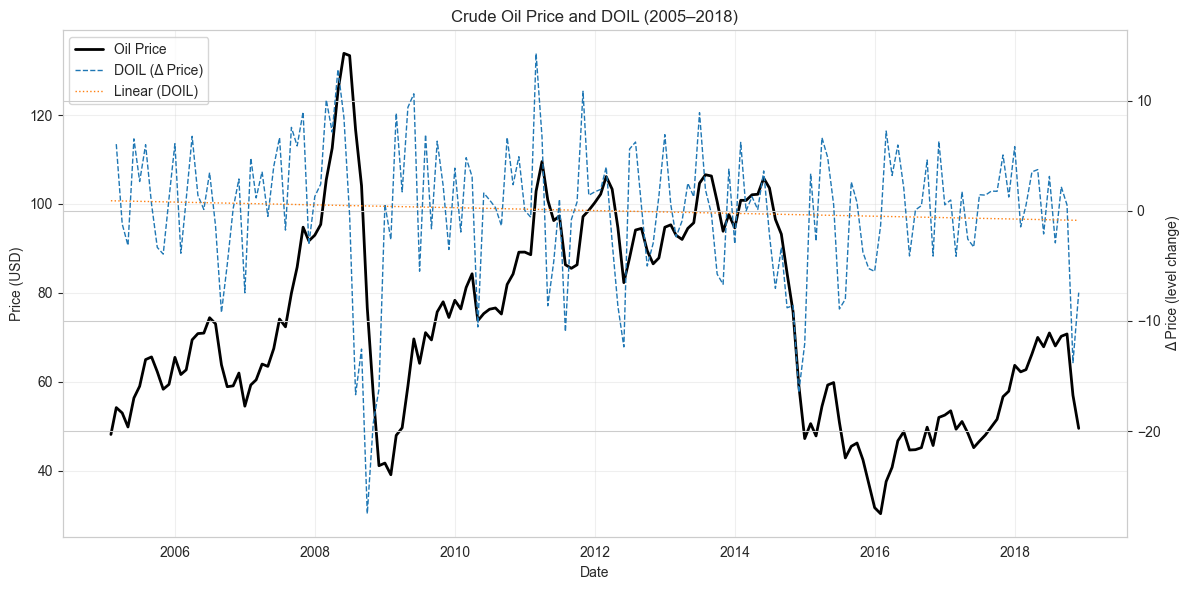

Saved figure to: oil_outputs/figure_crude_price_doil_2005_2018.png


In [92]:
# %% DOIL (Δ Price) figure corrected to 2018
doil = df_sub["Value"].diff()

t = (df_sub.index - df_sub.index[0]).days.values
mask = ~doil.isna()
slope, intercept = np.polyfit(t[mask], doil[mask].values, 1)
doil_trend = pd.Series(slope * t + intercept, index=df_sub.index)

fig, ax1 = plt.subplots(figsize=(12, 6))
line1, = ax1.plot(df_sub.index, df_sub["Value"], label="Oil Price", color="black", linewidth=2)
ax1.set_xlabel("Date"); ax1.set_ylabel("Price (USD)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
line2, = ax2.plot(df_sub.index, doil, label="DOIL (Δ Price)", linestyle="--", linewidth=1)
line3, = ax2.plot(df_sub.index, doil_trend, label="Linear (DOIL)", linestyle=":", linewidth=1)
ax2.set_ylabel("Δ Price (level change)")

lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Crude Oil Price and DOIL (2005–2018)")  # fixed end year
plt.tight_layout(); plt.show()

fig_path = OUTDIR / "figure_crude_price_doil_2005_2018.png"
plt.figure();  # ensure saving only the last composed fig if re-run
plt.close()
doil.to_csv(OUTDIR / "doil_series_2005_2018.csv", header=["DOIL"])
print(f"Saved figure to: {fig_path}")

In [93]:
#@#@#@#
# %% Load U.S. sector ETF prices (XLE..XLRE) and build daily log-returns
# Expects CSVs under: ROOT / "raw_yf" / "<TICKER>_2005_2018.csv"
# Each CSV must have Date + one price-like column (Adj Close, Close, Price, etc.)

SECTOR_TICKERS = [
    "XLE","XLB","XLI","XLY","XLP",
    "XLV","XLF","XLK","XLC","XLU","XLRE"
]

sector_series = {}
missing = []
for tkr in SECTOR_TICKERS:
    fp = ROOT / "raw_yf" / f"{tkr}_2005_2018.csv"
    if fp.exists():
        s = load_price_flexible(fp)        # uses START/END automatically
        s = to_bdays_ffill(s)              # align to business days
        s.name = tkr
        sector_series[tkr] = s
    else:
        missing.append(tkr)

if missing:
    print(f"[WARN] Missing sector CSVs for: {missing}. Those tickers will be skipped.")

if not sector_series:
    raise RuntimeError("No sector series loaded — add sector CSVs under ROOT/raw_yf/.")

# Combine to a single price DataFrame and compute daily log-returns
sector_prices = pd.concat(sector_series.values(), axis=1).sort_index()
sector_rets   = log_ret(sector_prices).dropna(how="all")
# drop columns with too few obs (e.g., missing files)
sector_rets   = sector_rets.loc[:, sector_rets.count() >= 250]

print("Sectors loaded:", list(sector_rets.columns))
print("sector_prices shape:", sector_prices.shape, "| sector_rets shape:", sector_rets.shape)

[WARN] Missing sector CSVs for: ['XLC', 'XLRE']. Those tickers will be skipped.
Sectors loaded: ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU']
sector_prices shape: (3651, 9) | sector_rets shape: (3611, 9)


In [94]:
# %% Descriptive stats: sector returns (like Table 1 but for U.S. sectors)
def desc_table_returns(ret_df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in ret_df.columns:
        x = ret_df[col].dropna()
        if x.empty: 
            continue
        jb_stat, jb_p = jarque_bera(x.values)
        out[col] = {
            "Mean (%)": pct(x.mean()),
            "Std. dev. (%)": pct(x.std(ddof=1)),
            "Skewness": skew(x, bias=False),
            "Kurtosis": kurtosis(x, fisher=False, bias=False),
            "Jarque-Bera": jb_stat,
            "N": len(x)
        }
    return pd.DataFrame(out).T

tbl_us_desc = desc_table_returns(sector_rets).reindex(sorted(sector_rets.columns))
display(tbl_us_desc.head(11))

# Save CSV/LaTeX
tbl_us_desc.to_csv(TABDIR / "Table_US_Sectors_descriptives.csv")
latex_table(tbl_us_desc.round(4), TABDIR / "Table_US_Sectors_descriptives.tex",
            caption="Descriptive statistics of U.S. sector ETF daily returns (2005–2018).",
            label="tab:desc_us_sectors")
print("Saved US sector descriptives to", TABDIR.resolve())

,Mean (%),Std. dev. (%),Skewness,Kurtosis,Jarque-Bera,N
XLB,0.017785,1.475613,-0.313036,10.869317,9346.527336,3611.0
XLE,0.012497,1.760777,-0.488127,13.687097,17274.859798,3611.0
XLF,0.003298,1.949072,-0.119102,19.339196,40057.018075,3611.0
XLI,0.025048,1.270441,-0.296201,10.137648,7693.244229,3611.0
XLK,0.035073,1.233660,-0.031422,12.529860,13622.397212,3611.0
XLP,0.027492,0.820058,-0.370188,8.728880,5003.939363,3611.0
XLU,0.024517,1.075833,0.164995,14.565627,20080.791105,3611.0
XLV,0.032493,1.006352,-0.289061,14.468201,19778.006907,3611.0
XLY,0.033049,1.284987,-0.395353,11.296634,10417.870411,3611.0


Saved US sector descriptives to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


In [95]:
# %% Merge with oil shocks and run panel regressions per sector
# Uses your shocks DataFrame built earlier (cols: supply, demand, risk).
# If you only have 'risk' from AR(1) fallback, the code will adapt automatically.

if 'shocks' not in globals():
    raise RuntimeError("`shocks` not found. Build shocks earlier (ready_shocks_2005_2018.csv or AR(1) fallback).")

# Align to shocks index
sector_rets_b = sector_rets.reindex(shocks.index).dropna(how="all", axis=1)
sector_rets_b = sector_rets_b.loc[:, sector_rets_b.count() >= 250]

print("Aligned sectors (with shocks):", list(sector_rets_b.columns), "| rows:", sector_rets_b.shape[0])

def ew_market(ret_df: pd.DataFrame):
    return ret_df.mean(axis=1)

def run_sector_panel(ret_df, shocks_df, label="US_Sectors"):
    mkt = ew_market(ret_df).rename("mkt")
    X = pd.concat([shocks_df[[c for c in ["supply","demand","risk"] if c in shocks_df.columns]], mkt], axis=1).dropna()
    rows = []
    for col in sorted(ret_df.columns):
        y = ret_df[col].reindex(X.index).dropna()
        XX = X.reindex(y.index).copy()
        XX = sm.add_constant(XX)
        res = OLS(y, XX, missing="drop").fit()
        rows.append(pd.Series({
            "Constant":        res.params.get("const", np.nan),
            "Supply shock":    res.params.get("supply", np.nan),
            "Demand shock":    res.params.get("demand", np.nan),
            "Risk shock":      res.params.get("risk", np.nan),
            "Aggregate market":res.params.get("mkt", np.nan),
            "R-squared":       res.rsquared
        }, name=col))
    out = pd.DataFrame(rows)
    out.to_csv(TABDIR / f"Table_{label}_panel.csv")
    latex_table(out.round(4), TABDIR / f"Table_{label}_panel.tex",
                caption=f"Oil price shocks and U.S. sector ETF returns (2005–2018).",
                label=f"tab:{label.lower()}_panel")
    return out

t2_us_sectors = run_sector_panel(sector_rets_b, shocks, label="US_Sectors")
display(t2_us_sectors.head(11))
print("Saved US sector panel regressions to", TABDIR.resolve())

Aligned sectors (with shocks): ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU'] | rows: 2980


,Constant,Supply shock,Demand shock,Risk shock,Aggregate market,R-squared
XLB,-0.000063,0.017908,0.175636,-0.026918,0.936380,0.825980
XLE,0.000003,0.000097,0.997970,-0.145076,0.005321,0.999221
XLF,-0.000462,0.006409,-0.381204,0.087527,2.150845,0.773057
XLI,-0.000029,0.008324,-0.092244,0.007808,1.150659,0.878487
XLK,0.000116,0.002193,-0.124527,0.000829,1.058373,0.818491
XLP,0.000128,-0.006956,-0.164615,0.018622,0.764353,0.678889
XLU,0.000047,-0.031428,-0.010983,0.021606,0.760339,0.516089
XLV,0.000187,-0.014199,-0.145144,-0.001387,0.808452,0.697245
XLY,0.000073,0.017652,-0.254890,0.036989,1.365279,0.855514


Saved US sector panel regressions to /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables


In [96]:
# %% Fallback: build a >=2 series returns matrix from local data (XLE + OIL + VIX)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sanity checks for locally available series
need = []
if "xle" not in globals():
    need.append("xle (price series)")
if "oil_b" not in globals():
    need.append("oil_b (price series)")
if "vix_b" not in globals():
    need.append("vix_b (price series)")
if need:
    raise RuntimeError(f"Missing: {need}. Run the earlier cell that loads XLE/BZ=F/^VIX CSVs under ROOT/raw_yf/.")

def _ret(s): 
    return np.log(s/s.shift(1))

# Build returns
R = pd.concat([
    _ret(xle).rename("XLE"),
    _ret(oil_b).rename("OIL"),
    _ret(vix_b).rename("VIX")
], axis=1).dropna()

# Basic quality filter
R = R.loc[:, R.count() >= 250]
print("[OK] Fallback returns matrix shape:", R.shape, "| columns:", list(R.columns))

# Small preview
display(R.describe().T.round(4))

[OK] Fallback returns matrix shape: (2980, 3) | columns: ['XLE', 'OIL', 'VIX']


,count,mean,std,min,25%,50%,75%,max
XLE,2980.0,-0.0000,0.0181,-0.1560,-0.0074,0.0000,0.0084,0.1526
OIL,2980.0,-0.0001,0.0214,-0.1095,-0.0094,0.0000,0.0096,0.1271
VIX,2980.0,0.0001,0.0750,-0.3506,-0.0404,-0.0028,0.0334,0.7682


Full-sample TCI (XLE/OIL/VIX): 41.26%


,XLE,OIL,VIX
XLE,0.477,0.155,0.368
OIL,0.253,0.587,0.160
VIX,0.249,0.052,0.698


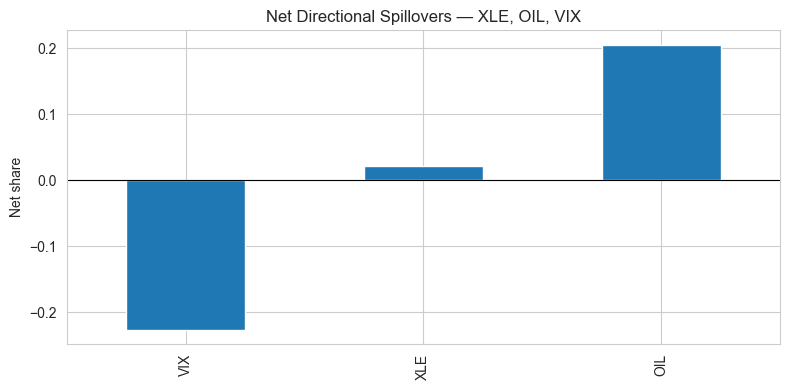

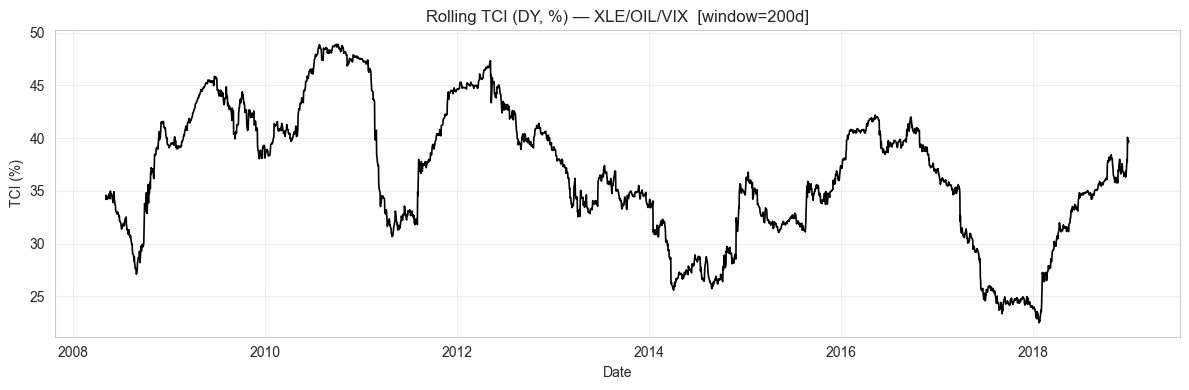

Saved: connectedness_outputs/XLE_OIL_VIX_LagSensitivity_window200.png


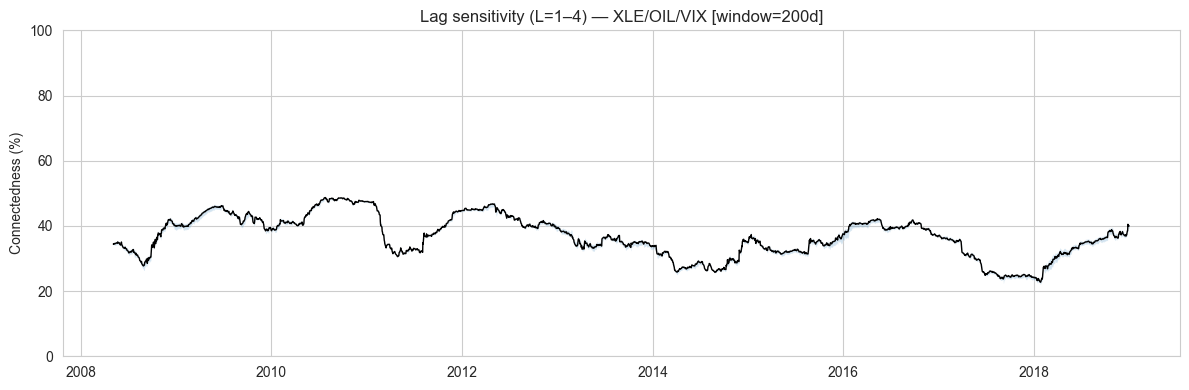

Saved: connectedness_outputs/XLE_OIL_VIX_HorizonSensitivity_window200.png


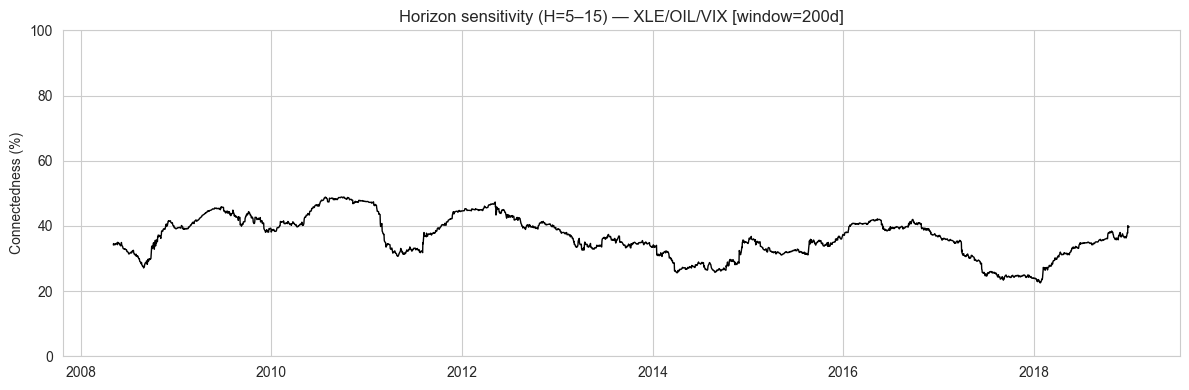

In [97]:
# %% DY connectedness + rolling TCI + sensitivity on fallback set (XLE/OIL/VIX)
# Uses your existing dy_spillover, rolling_tc, sensitivity_band, plot_band

from pathlib import Path

# full-sample DY
dy_out = dy_spillover(R, p=2, H=10)
tci_full = float(dy_out["TCI"].iloc[0])
print(f"Full-sample TCI (XLE/OIL/VIX): {tci_full:.2f}%")
display(dy_out["GFEVD"].round(3))

# Net spillovers bar
fig, ax = plt.subplots(figsize=(8,4))
dy_out["NET"].sort_values().plot(kind="bar", ax=ax)
ax.axhline(0, color="k", lw=0.8); ax.set_ylabel("Net share")
ax.set_title("Net Directional Spillovers — XLE, OIL, VIX")
plt.tight_layout(); plt.show()

# Rolling TCI
DEFAULT_WINDOW = 200
window = DEFAULT_WINDOW if len(R) > DEFAULT_WINDOW + 20 else max(60, len(R)//5)
tci_roll = rolling_tc(R, lags=2, H=10, window=window)
CONN_OUT.mkdir(exist_ok=True, parents=True)
tci_roll.to_csv(CONN_OUT / f"XLE_OIL_VIX_TCI_rolling_window{window}.csv")

plt.figure(figsize=(12,4))
plt.plot(tci_roll.index, tci_roll.values, color="black", lw=1.2)
plt.title(f"Rolling TCI (DY, %) — XLE/OIL/VIX  [window={window}d]")
plt.ylabel("TCI (%)"); plt.xlabel("Date"); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(CONN_OUT / f"XLE_OIL_VIX_TCI_window{window}.png", dpi=300, bbox_inches="tight")
plt.show()

# Sensitivity bands
band_lag, grid_lag = sensitivity_band(R, lags_list=[1,2,3,4], window=window)
grid_lag.to_csv(CONN_OUT / f"XLE_OIL_VIX_Sensitivity_lags_1to4_window{window}.csv")
plot_band(band_lag, f"Lag sensitivity (L=1–4) — XLE/OIL/VIX [window={window}d]",
          ylims=(0,100),
          fname=CONN_OUT / f"XLE_OIL_VIX_LagSensitivity_window{window}.png")

band_H, grid_H = sensitivity_band(R, H_list=list(range(5,16)), window=window)
grid_H.to_csv(CONN_OUT / f"XLE_OIL_VIX_Sensitivity_H_5to15_window{window}.csv")
plot_band(band_H, f"Horizon sensitivity (H=5–15) — XLE/OIL/VIX [window={window}d]",
          ylims=(0,100),
          fname=CONN_OUT / f"XLE_OIL_VIX_HorizonSensitivity_window{window}.png")

new

In [98]:
# pip install pandas-datareader --upgrade
import pandas as pd
from pandas_datareader import data as pdr

def load_stooq(ticker: str, start="2005-01-01", end="2018-12-31"):
    """
    Stooq uses 'XLE.US', 'XLK.US', etc. Returns a DF with Date + Adj Close.
    """
    sym = f"{ticker}.US"
    df = pdr.DataReader(sym, "stooq", start=start, end=end)  # returns newest->oldest
    if df.empty:
        raise ValueError(f"Stooq returned empty for {sym}")
    df = df.sort_index()  # oldest->newest
    out = df[["Close"]].rename(columns={"Close":"Adj Close"}).reset_index().rename(columns={"Date":"Date"})
    return out

tickers = ["XLE","XLB","XLI","XLY","XLP","XLV","XLF","XLK","XLU"]  # (skip XLC/XLRE or see Option C)
for t in tickers:
    df = load_stooq(t, "2005-01-01", "2018-12-31")
    df.to_csv(f"/Users/steven/Documents/DS340W/Papaer_Code/raw_yf/{t}_2005_2018.csv", index=False)
    print("[OK] saved", t)

[OK] saved XLE
[OK] saved XLB
[OK] saved XLI
[OK] saved XLY
[OK] saved XLP
[OK] saved XLV
[OK] saved XLF
[OK] saved XLK
[OK] saved XLU


ROOT = /Users/steven/Documents/DS340W/Papaer_Code
Outputs → /Users/steven/Documents/DS340W/Papaer_Code/oil_outputs, /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs
Combined return matrix → 3651 dates × 25 series

=== Table 1 • Descriptive statistics ===
         Mean (%)  Std. dev. (%)  Skewness  Kurtosis  Jarque-Bera  JB p-value       N
Oil_ret   -0.0125         2.1383   -0.1158    7.0386    2023.0875         0.0  2980.0
VIX_ret    0.0192         7.2655    1.0110   10.1512    8373.9422         0.0  3650.0
XME_ret   -0.0225         2.5388   -0.4294    9.5685    5427.3846         0.0  2980.0
VAW_ret    0.0169         1.5855   -0.5896   10.4996    7128.9614         0.0  2980.0
VIS_ret    0.0220         1.3958   -0.3580    9.7561    5708.7651         0.0  2980.0
VFH_ret    0.0076         1.8828   -0.1467   16.3154   21944.9520         0.0  2980.0
IYM_ret    0.0131         1.7385   -0.6464   11.0945    8311.4964         0.0  2980.0
IYJ_ret    0.0243         1.3529   -0.395

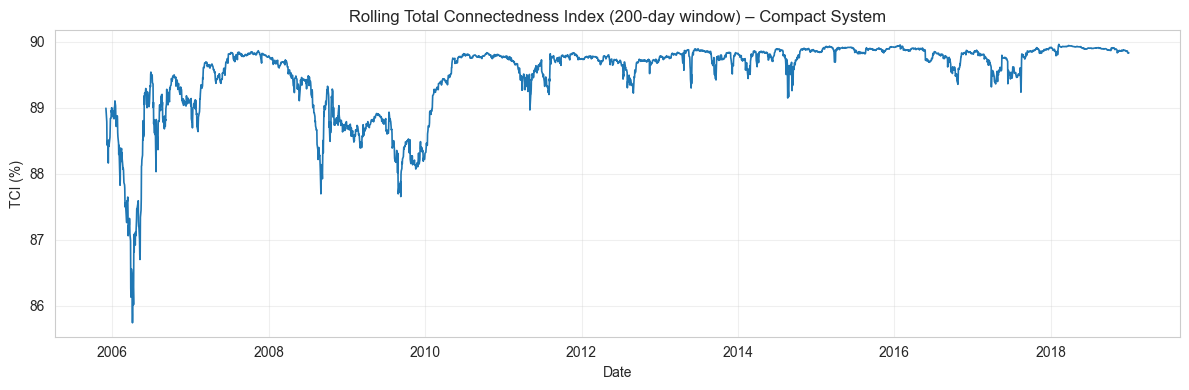

✔️  Figure 1 saved.
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
✔️  Band plot saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/Appendix_LagBand_Compact.png


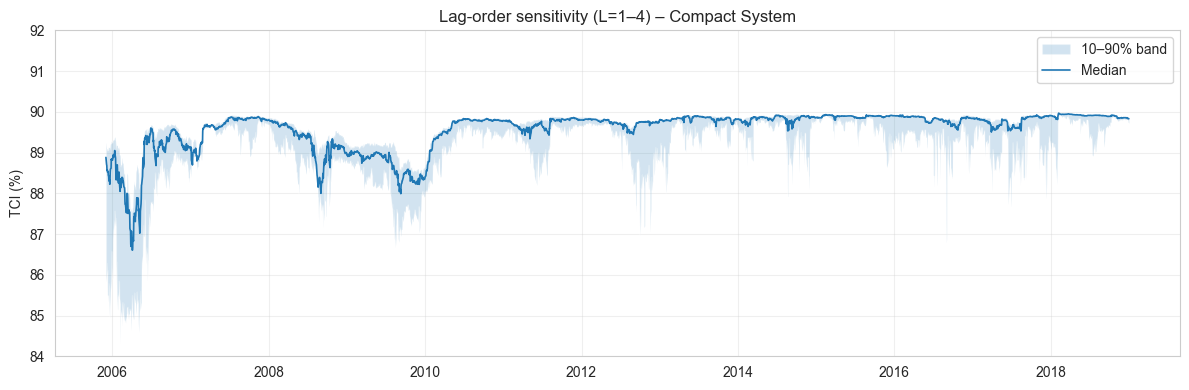

[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
[Rolling TCI] windows=3412, ok=3412, failed=0, ok%=100.0%
✔️  Band plot saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/Appendix_HBand_Compact.png


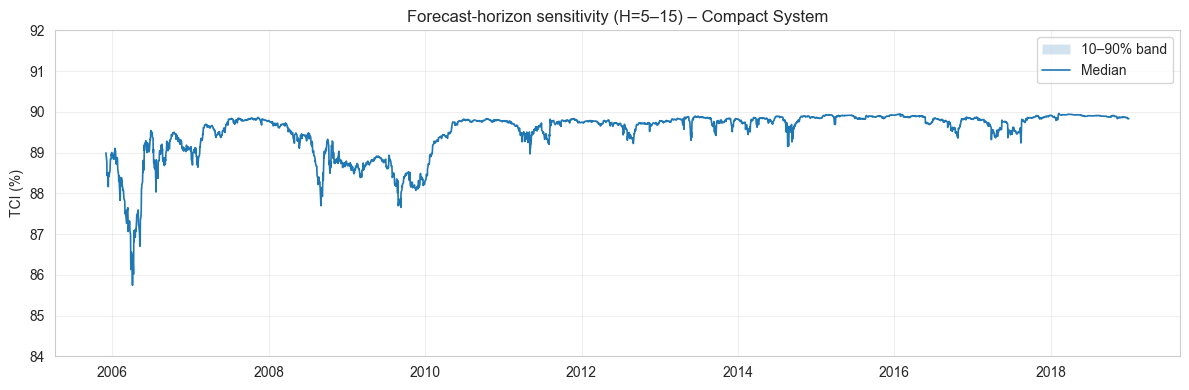

✔️  Network graph saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/Network_FullSystem_Compact.png


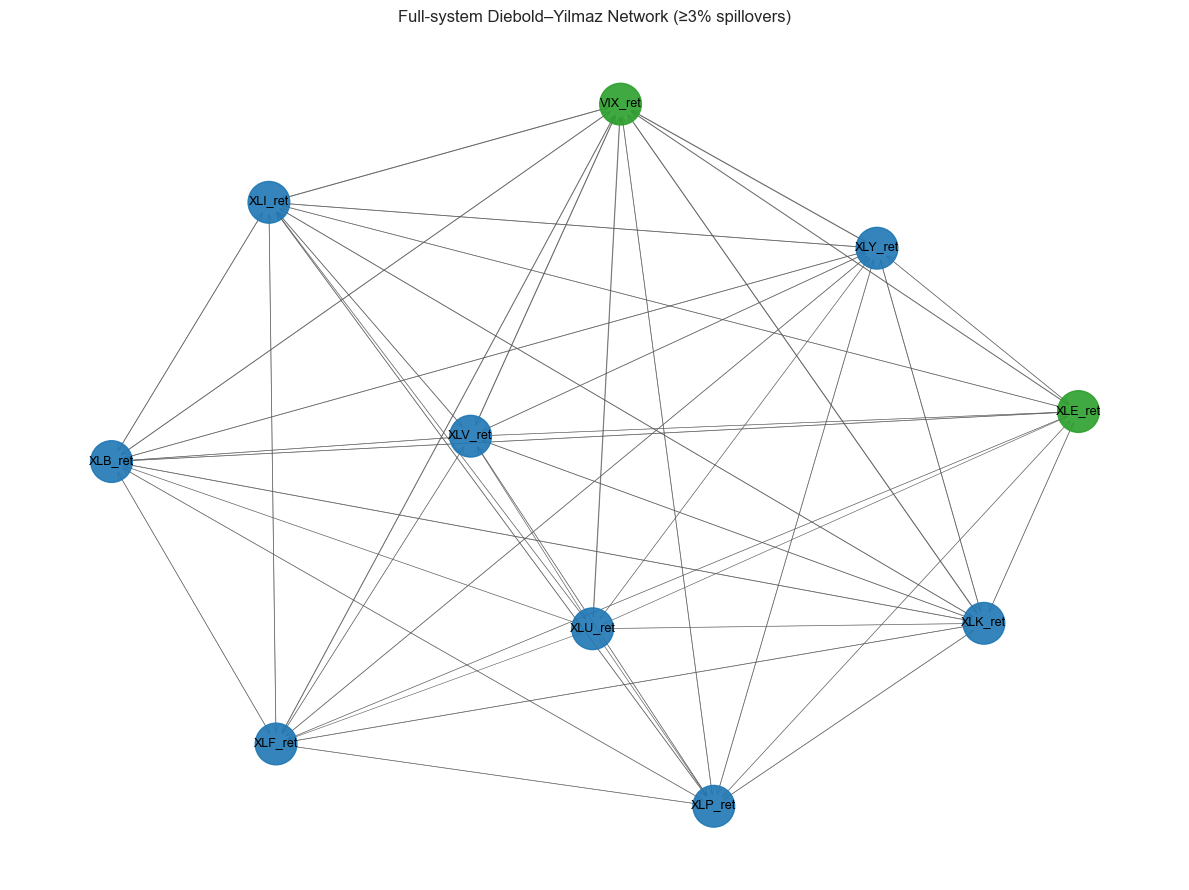


[QVAR] τ=0.05  → TCI = 91.06%
[QVAR] τ=0.95  → TCI = 86.49%

=== QVAR FEVD (τ=0.05) — head ===
         VIX_ret  XLE_ret  XLF_ret  XLB_ret  XLY_ret  XLI_ret  XLK_ret  XLU_ret  XLV_ret  XLP_ret
VIX_ret    64.50    11.36     5.09     2.99     3.75     4.24     0.12     0.08     3.48     4.39
XLE_ret    53.68     7.16     2.86     1.72     8.47     9.35     2.99     2.14     9.20     2.43
XLF_ret    58.23     8.57     5.27     2.94     5.43     6.05     1.60     1.32     6.13     4.46
XLB_ret    43.46     5.64     3.99     5.08     8.70     9.95     4.80     3.91    11.15     3.32
XLY_ret    57.93    14.92     8.82     5.64     1.39     1.56     0.46     0.66     0.96     7.66
XLI_ret    56.06    15.47     9.52     5.97     1.19     1.37     0.61     0.80     0.82     8.19
XLK_ret    65.12     8.05     2.90     1.52     5.91     6.69     0.85     0.37     6.09     2.50
XLU_ret    64.69    11.40     5.15     2.88     3.58     4.12     0.12     0.12     3.45     4.49
XLV_ret    60.83    13

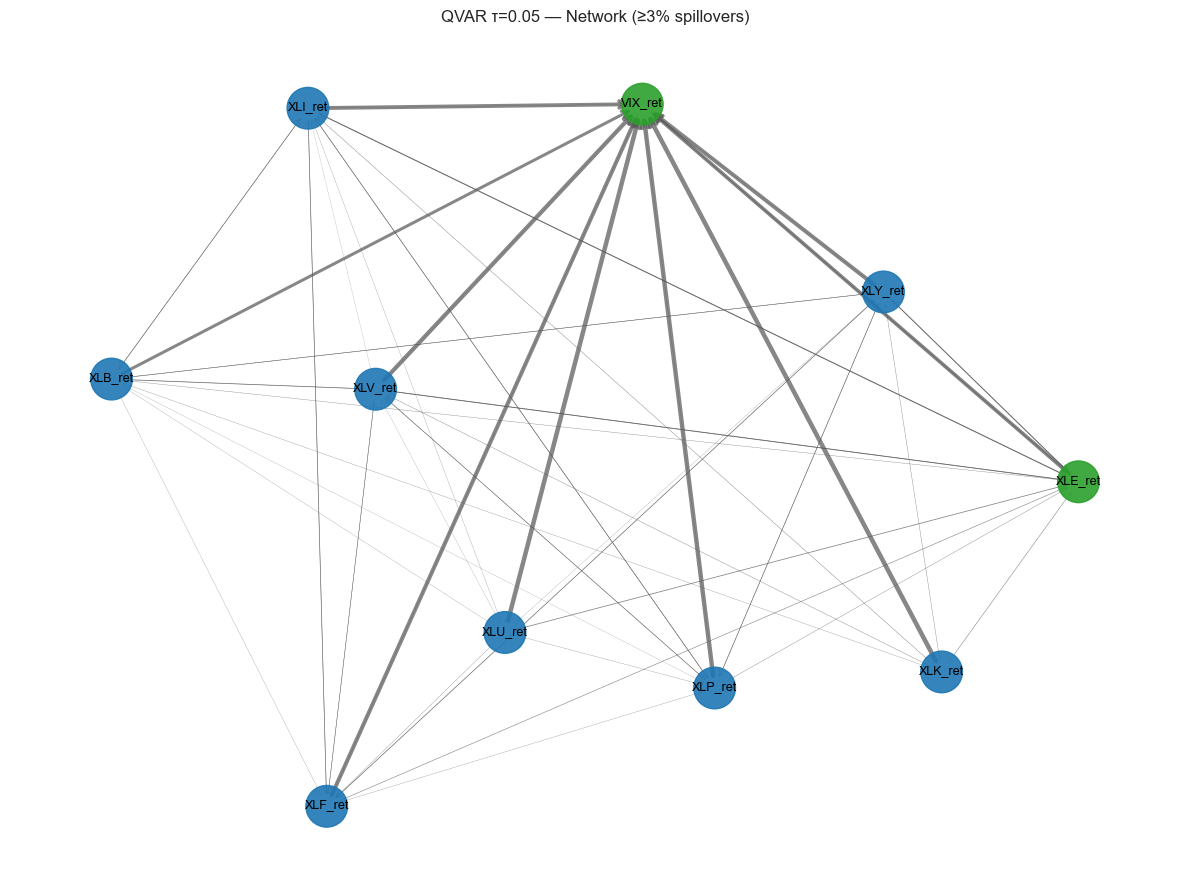

✔️  Network graph saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/Network_QVAR_tau095.png


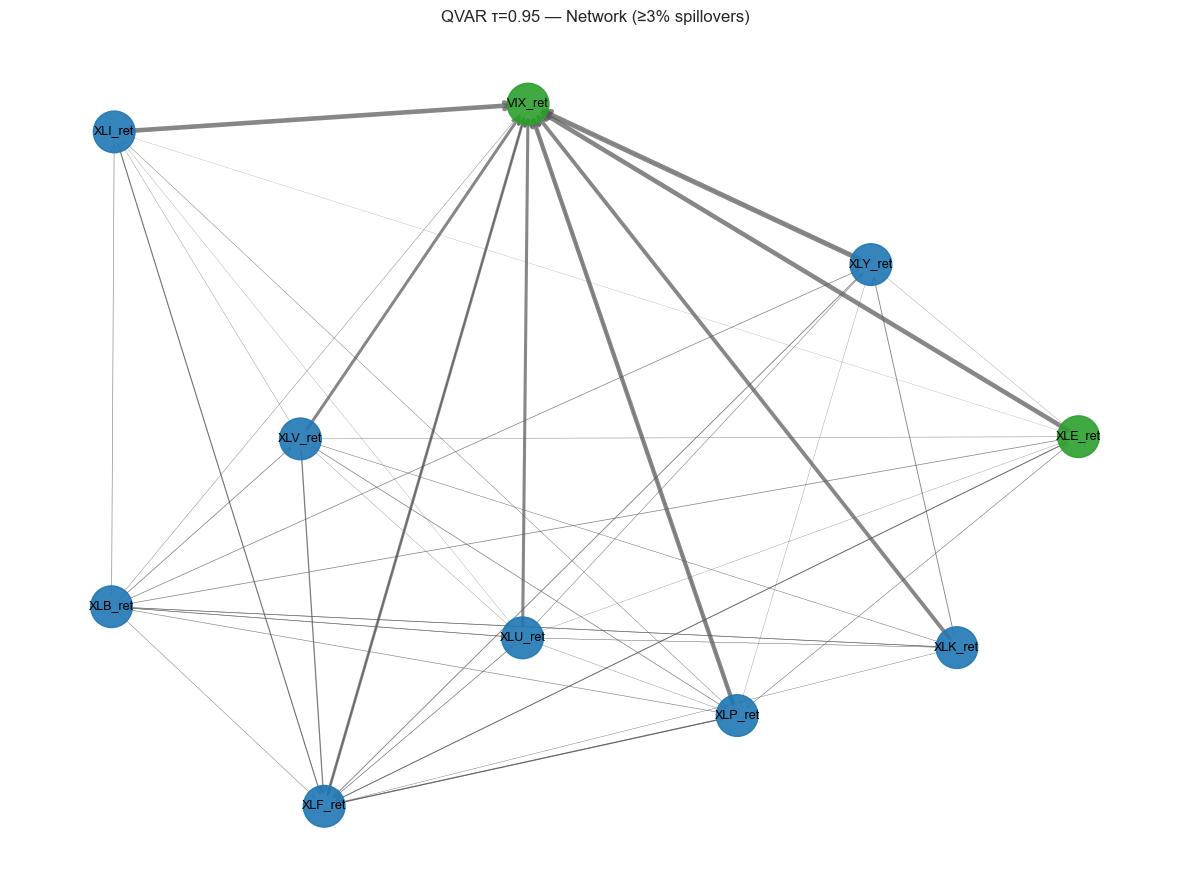


✅ Done. Tables printed above; CSV/LaTeX and figures saved to your output folders.


In [99]:
# ==============================================================
# 0️⃣ Imports & Global configuration
# ==============================================================
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    pass

import networkx as nx

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.regression.linear_model import OLS
from scipy.stats import skew, kurtosis, jarque_bera

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 5)

# ----------- Paths & sample period (EDIT ROOT if needed) -----------
ROOT       = Path.cwd()                         # current working folder
BASEDIR    = ROOT / "raw_yf"
START, END = "2005-01-01", "2018-12-31"

# ----------- Output directories -----------
OUTDIR    = ROOT / "oil_outputs"
CONN_OUT  = ROOT / "connectedness_outputs"
TABDIR    = CONN_OUT / "tables"
for p in (OUTDIR, CONN_OUT, TABDIR):
    p.mkdir(parents=True, exist_ok=True)

print(f"ROOT = {ROOT}")
print(f"Outputs → {OUTDIR.resolve()}, {CONN_OUT.resolve()}")

# ----------- Analysis knobs (easy to tweak) -----------
VAR_LAGS           = 2       # baseline VAR lag order
FEVD_H             = 10      # FEVD horizon
DY_MAX_K           = 12      # max series in DY system (stability)
ROLL_WINDOW_WISH   = 200     # preferred rolling window; we adapt down if N is small
PRINT_ROWS         = 40      # how many rows to print from tables
COVERAGE_MIN_SHARE = 0.90    # minimum non-missing share to keep a column for DY
EXCLUDE_OIL_IN_TABLE2 = True # avoid tautology in panel regressions


# ==============================================================
# 1️⃣ Helper utilities (I/O, returns, LaTeX writer, index fixes)
# ==============================================================
def _unique_monotonic(df_or_s):
    """Drop duplicate index labels (keep last) and sort by index."""
    obj = df_or_s.copy()
    obj = obj[~obj.index.duplicated(keep="last")]
    obj = obj.sort_index()
    return obj

def load_price_flexible(csv_path: Path, start: str = START, end: str = END):
    """
    Reads a CSV with Date + any numeric price column.
    Returns a business-day aligned Series (forward-filled).
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path, parse_dates=["Date"]).sort_values("Date")
    price_cols = [c for c in ("Adj Close","AdjClose","Close","Price","PX_LAST","Value","Last","Close Price")
                  if c in df.columns]
    if not price_cols:
        price_cols = [c for c in df.columns if c != "Date" and pd.api.types.is_numeric_dtype(df[c])]
    if not price_cols:
        raise ValueError(f"{csv_path.name}: no usable price column.")
    s = df.set_index("Date")[price_cols[0]].astype(float)
    s = s.loc[start:end]
    s = s[~s.index.duplicated(keep="last")].sort_index()
    bday_idx = pd.bdate_range(start, end)
    s = s.reindex(bday_idx).ffill()
    s.name = csv_path.stem
    return s

def load_panel(csv_path: Path, start: str = START, end: str = END):
    """
    CSV with Date + many numeric columns → business-day aligned DataFrame.
    """
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path, parse_dates=["Date"]).sort_values("Date").set_index("Date")
    df = df.loc[start:end]
    df = df.select_dtypes(include=["number"]).astype(float)
    df = df[~df.index.duplicated(keep="last")].sort_index()
    bday_idx = pd.bdate_range(start, end)
    df = df.reindex(bday_idx).ffill()
    return df

def log_ret(obj):
    """Natural log-returns. Works for Series or DataFrame."""
    return np.log(obj / obj.shift(1))

def pct(x): 
    return 100 * x

def latex_table(df: pd.DataFrame, path: Path, caption: str, label: str, index: bool = True):
    """
    Simple LaTeX table writer using pandas.to_latex inside a float environment.
    """
    try:
        with open(path, "w") as f:
            f.write("\\begin{table}[!ht]\n\\centering\n")
            f.write(df.to_latex(index=index, escape=True))
            f.write(f"\n\\caption{{{caption}}}\n\\label{{{label}}}\n\\end{{table}}\n")
        print(f"✔️  LaTeX saved → {path}")
    except Exception as e:
        print(f"⚠️  Failed to save LaTeX to {path}: {e}")


# ==============================================================
# 2️⃣ Load all series you have
# ==============================================================
try:
    # Core price series
    oil = load_price_flexible(BASEDIR / "BZ=F_2005_2018.csv").rename("Oil")
    vix = load_price_flexible(BASEDIR / "^VIX_2005_2018.csv").rename("VIX")

    # XLE (optional if file exists)
    xle_path = BASEDIR / "XLE_2005_2018.csv"
    xle = load_price_flexible(xle_path).rename("XLE") if xle_path.is_file() else None

    # Exporter / Importer panels
    exp_prices = load_panel(BASEDIR / "exporter_sectors_2005_2018.csv")
    imp_prices = load_panel(BASEDIR / "importer_sectors_2005_2018.csv")

    # U.S. sector ETFs
    SECTOR_TICKERS = ["XLE","XLB","XLI","XLY","XLP","XLV","XLF","XLK","XLU"]
    sector_series = {}
    missing = []
    for tkr in SECTOR_TICKERS:
        fp = BASEDIR / f"{tkr}_2005_2018.csv"
        if fp.is_file():
            try:
                sector_series[tkr] = load_price_flexible(fp).rename(tkr)
            except Exception as e:
                print(f"[WARN] failed to load {tkr}: {e}")
        else:
            missing.append(tkr)
    if missing:
        print(f"[WARN] missing sector CSVs: {missing}")

    # Shocks: ready file → else AR(1) innovation on oil (as "risk")
    shocks_path = BASEDIR / "ready_shocks_2005_2018.csv"
    if shocks_path.is_file():
        shocks = (pd.read_csv(shocks_path, parse_dates=[0], index_col=0)
                    .reindex(pd.bdate_range(START, END))
                    .dropna())
    else:
        print("[WARN] ready_shocks not found → building AR(1) proxy from oil returns.")
        oil_ret_tmp = log_ret(oil).dropna()
        ar = sm.tsa.AutoReg(oil_ret_tmp, lags=1, old_names=False).fit()
        shocks = pd.DataFrame(index=oil_ret_tmp.index,
                              data={"supply":0.0, "demand":0.0, "risk":ar.resid})

    # normalize indices early
    oil   = _unique_monotonic(oil)
    vix   = _unique_monotonic(vix)
    xle   = _unique_monotonic(xle) if xle is not None else None
    exp_prices = _unique_monotonic(exp_prices)
    imp_prices = _unique_monotonic(imp_prices)
    for k in list(sector_series.keys()):
        sector_series[k] = _unique_monotonic(sector_series[k])
    shocks = _unique_monotonic(shocks)

except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print(f"Please ensure data files exist in: {BASEDIR}")
    raise


# ==============================================================
# 3️⃣ Build the log-return matrix (regressions + DY)
# ==============================================================
ret_oil = log_ret(oil).rename("Oil_ret")
ret_vix = log_ret(vix).rename("VIX_ret")
ret_xle = log_ret(xle).rename("XLE_ret") if xle is not None else None

exp_ret = log_ret(exp_prices).add_suffix("_ret")
imp_ret = log_ret(imp_prices).add_suffix("_ret")
etf_ret = (pd.concat([log_ret(s).rename(f"{s.name}_ret") for s in sector_series.values()],
                     axis=1) if sector_series else pd.DataFrame())

pieces = [ret_oil, ret_vix, exp_ret, imp_ret, etf_ret, shocks]
if ret_xle is not None:
    pieces.insert(2, ret_xle)

all_ret = pd.concat(pieces, axis=1, sort=False)

# De-duplicate columns, keeping the last instance (e.g., XLE_ret)
all_ret = all_ret.loc[:, ~all_ret.columns.duplicated(keep='last')]

all_ret = all_ret.replace([np.inf, -np.inf], np.nan)
all_ret = _unique_monotonic(all_ret)  # keep all rows; dropna later when needed
print(f"Combined return matrix → {all_ret.shape[0]} dates × {all_ret.shape[1]} series")


all_ret = all_ret.drop(columns=[c for c in all_ret.columns 
                                if c.startswith(("XLC","XLRE"))], errors="ignore")

# ==============================================================
# 4️⃣ Table 1 – Descriptive statistics (PRINT + save CSV/LaTeX)
# ==============================================================
def descriptive_table(df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in df.columns:
        s = df[col].dropna()
        if s.empty or len(s) < 2:
            continue
        try:
            jb, jp = jarque_bera(s.values)
        except Exception:
            jb, jp = np.nan, np.nan
        out[col] = {
            "Mean (%)"      : pct(s.mean()),
            "Std. dev. (%)" : pct(s.std(ddof=1)),
            "Skewness"      : skew(s, bias=False),
            "Kurtosis"      : kurtosis(s, fisher=False, bias=False),
            "Jarque-Bera"   : jb,
            "JB p-value"    : jp,
            "N"             : int(len(s))
        }
    return pd.DataFrame(out).T

tbl1 = descriptive_table(all_ret).round(4)

print("\n=== Table 1 • Descriptive statistics ===")
if len(tbl1) <= PRINT_ROWS:
    print(tbl1.to_string())
else:
    print(tbl1.head(PRINT_ROWS).to_string())
    print(f"... ({len(tbl1)-PRINT_ROWS} more rows not printed)")

tbl1.to_csv(TABDIR / "Table1_All_descriptives.csv")
latex_table(tbl1, TABDIR / "Table1_All_descriptives.tex",
            caption="Descriptive statistics for the full set of daily log-returns (oil, VIX, sectors, shocks).",
            label="tab:desc_all")


# ==============================================================
# 5️⃣ Table 2 – Unified panel regressions (PRINT + save)
# ==============================================================
def ew_market(df: pd.DataFrame) -> pd.Series:
    """Equal-weighted market factor – excludes the current y column."""
    return df.mean(axis=1)

def run_unified_panel(df_ret: pd.DataFrame, shocks_df: pd.DataFrame, label: str = "All") -> pd.DataFrame:
    """
    For each series y in df_ret:
      y_t = α + β_supp·Supply_t + β_dem·Demand_t + β_risk·Risk_t + γ·mkt_t + ε_t
    where mkt_t is the equal-weighted average of all *other* returns.
    """
    df_ret     = _unique_monotonic(df_ret)
    shocks_df  = _unique_monotonic(shocks_df)

    # drop shocks from regressands
    drop_cols = [c for c in ["supply","demand","risk"] if c in df_ret.columns]
    if EXCLUDE_OIL_IN_TABLE2 and "Oil_ret" in df_ret.columns:
        drop_cols.append("Oil_ret")
    df_ret = df_ret.drop(columns=drop_cols, errors="ignore")

    results = []
    for col in sorted(df_ret.columns):
        y = df_ret[col].to_frame("y")
        other_cols = [c for c in df_ret.columns if c != col]
        market = df_ret[other_cols].mean(axis=1).to_frame("mkt")

        X = pd.concat([shocks_df[['supply','demand','risk']], market], axis=1)
        X = sm.add_constant(X)

        # Align indices properly (single join to avoid alignment bugs)
        combo = pd.concat([y, X], axis=1, join="inner").dropna()
        if len(combo) < 20:
            continue

        y_aligned = combo["y"].values
        X_aligned = combo.drop(columns=["y"]).values

        try:
            res = OLS(y_aligned, X_aligned).fit()
            names = combo.drop(columns=["y"]).columns
            params = dict(zip(names, res.params))

            # R2 robust fallback
            try:
                r2 = float(res.rsquared)
            except Exception:
                yhat = res.predict(X_aligned)
                ssr = np.sum((y_aligned - yhat)**2)
                sst = np.sum((y_aligned - y_aligned.mean())**2)
                r2 = 1 - ssr/sst if sst != 0 else np.nan

            results.append(pd.Series({
                "Constant"     : params.get("const", np.nan),
                "Supply shock" : params.get("supply", np.nan),
                "Demand shock" : params.get("demand", np.nan),
                "Risk shock"   : params.get("risk", np.nan),
                "Agg. market"  : params.get("mkt", np.nan),
                "R-squared"    : r2
            }, name=col))
        except Exception as e:
            print(f"[WARN] Regression failed for {col}: {e}")
            continue

    if not results:
        print(f"[WARN] No successful regressions for {label}")
        return pd.DataFrame()
    
    out = pd.DataFrame(results).round(4)

    print(f"\n=== Table 2 • Panel regressions ({label}) ===")
    if len(out) <= PRINT_ROWS:
        print(out.to_string())
    else:
        print(out.head(PRINT_ROWS).to_string())
        print(f"... ({len(out)-PRINT_ROWS} more rows not printed)")

    out.to_csv(TABDIR / f"Table2_{label}_panel.csv")
    latex_table(out, TABDIR / f"Table2_{label}_panel.tex",
                caption=f"Oil-price shocks + common market factor regressions for all series ({label}).",
                label=f"tab:{label.lower()}_panel")
    print(f"✔️  Table 2 saved for {label} ({len(out)} equations).")
    return out

tbl2 = run_unified_panel(
    all_ret.drop(columns=[c for c in ["supply","demand","risk"] if c in all_ret.columns], errors="ignore"),
    shocks, label="All"
)


# ==============================================================
# 6️⃣ DY helpers – VAR→MA and Pesaran–Shin generalized FEVD
# ==============================================================
def _var_to_ma(var_res, H: int) -> np.ndarray:
    """
    Convert fitted VAR(p) to MA coefficients Phi_h, h=0..H-1.
    Returns array shape (H, K, K).
    """
    K = var_res.neqs
    p = var_res.k_ar

    # Companion matrix
    A = np.zeros((K * p, K * p))
    A[:K, :K * p] = np.hstack([var_res.coefs[i].T for i in range(p)])
    if p > 1:
        A[K:, :-K] = np.eye(K * (p - 1))

    # Selection matrices
    C_top = np.zeros((K, K * p))
    C_top[:, :K] = np.eye(K)

    Phi = np.zeros((H, K, K))
    A_pow = np.eye(K * p)
    for h in range(H):
        if h == 0:
            Phi[h] = np.eye(K)
        else:
            A_pow = A_pow @ A
            Phi[h] = C_top @ A_pow @ C_top.T
    return Phi

def _gfevd_pesaran_shin(Phi: np.ndarray, Sigma: np.ndarray) -> np.ndarray:
    """
    Pesaran–Shin Generalized FEVD at horizon H:
      theta_ij(H) = (sigma_jj^{-1} * sum_{h=0}^{H-1} (e_i' Phi_h Sigma e_j)^2) /
                      (sum_{h=0}^{H-1} (e_i' Phi_h Sigma Phi_h' e_i))
    Then rows normalized to sum to 1.
    """
    H, K, _ = Phi.shape
    Sigma = np.asarray(Sigma, dtype=float)
    theta = np.zeros((K, K))

    for i in range(K):
        den = 0.0
        for h in range(H):
            vi = Phi[h][i, :] @ Sigma
            den += vi @ Phi[h][i, :].T
        if den == 0:
            continue
        for j in range(K):
            if Sigma[j, j] == 0:
                continue
            num = 0.0
            for h in range(H):
                num += (Phi[h][i, :] @ Sigma[:, j]) ** 2
            theta[i, j] = num / Sigma[j, j]
        theta[i, :] = theta[i, :] / den

    # clean & normalize
    theta = np.clip(theta, 0.0, 1.0)
    rowsum = theta.sum(axis=1, keepdims=True)
    rowsum[rowsum == 0] = 1.0
    theta = theta / rowsum
    return theta


# ==============================================================
# 7️⃣ DY wrapper + compact panel builder
# ==============================================================
def build_dy_panel(all_df: pd.DataFrame, max_k: int = DY_MAX_K,
                   base_keep: tuple = ("Oil_ret","VIX_ret","XLE_ret")) -> pd.DataFrame:
    """
    Remove shocks; drop low-coverage columns; keep <= max_k return series.
    Always keep base if present, then add highest-variance.
    """
    df = all_df.drop(columns=[c for c in ["supply","demand","risk"] if c in all_df.columns],
                     errors="ignore")
    df = df.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

    # keep columns with >= COVERAGE_MIN_SHARE non-missing
    cover = df.notna().mean(axis=0)
    df = df.loc[:, cover >= COVERAGE_MIN_SHARE]

    df = _unique_monotonic(df).dropna(how="any")

    keep = [c for c in base_keep if c in df.columns]
    remaining = [c for c in df.columns if c not in keep]
    var_ranked = df[remaining].var().sort_values(ascending=False).index.tolist()
    for c in var_ranked:
        if len(keep) >= max_k:
            break
        keep.append(c)
    panel = df[keep].copy()
    print(f"[DY panel] Using {panel.shape[1]} series, {panel.shape[0]} rows.")
    print(f"[DY panel] Columns: {list(panel.columns)}")
    return panel

dy_df = build_dy_panel(all_ret, max_k=DY_MAX_K)

def dy_fevd_and_tci(df: pd.DataFrame, lags: int = VAR_LAGS, H: int = FEVD_H) -> dict:
    clean = df.dropna().astype(float)
    if len(clean) < lags + 50:
        raise ValueError(f"Insufficient data: need at least {lags + 50} rows, got {len(clean)}")
    var_res = VAR(clean).fit(lags)
    Sigma = np.asarray(var_res.sigma_u, dtype=float)
    Phi   = _var_to_ma(var_res, H)
    theta = _gfevd_pesaran_shin(Phi, Sigma)

    fevd = pd.DataFrame(theta * 100, index=clean.columns, columns=clean.columns)
    theta_off = theta.copy()
    np.fill_diagonal(theta_off, 0.0)
    TCI = theta_off.sum().sum() / theta.shape[0] * 100.0

    TO   = fevd.sum(axis=1) - np.diag(fevd)
    FROM = fevd.sum(axis=0) - np.diag(fevd)
    NET  = TO - FROM
    return {"FEVD": fevd, "TCI": TCI, "NET": NET, "VAR": var_res}

# Full-sample DY sanity check
try:
    dy_full = dy_fevd_and_tci(dy_df, lags=VAR_LAGS, H=FEVD_H)
    print(f"\nFull-sample Total Connectedness Index (TCI) = {dy_full['TCI']:.2f}%")
    dy_full["FEVD"].to_csv(CONN_OUT / "FEVD_full_system_compact.csv")
except Exception as e:
    print(f"❌ Error computing full-sample DY: {e}")
    dy_full = None


# ==============================================================
# 8️⃣ Figure 1 – Rolling TCI (time-varying connectedness)
# ==============================================================
def rolling_tci_with_diag(df: pd.DataFrame, window: int, lags: int = VAR_LAGS, H: int = FEVD_H) -> pd.Series:
    vals, dates, fails = [], [], 0
    for i in range(window, len(df) + 1):
        sub = df.iloc[i - window:i]
        try:
            tci = dy_fevd_and_tci(sub, lags=lags, H=H)['TCI']
            if not np.isfinite(tci):
                raise ValueError("Non-finite TCI")
        except Exception as e:
            # uncomment for verbose diagnostics
            # print(f"[Rolling] window ending {df.index[i-1].date()} failed: {e}")
            tci = np.nan
            fails += 1
        vals.append(tci)
        dates.append(df.index[i - 1])
    s = pd.Series(vals, index=pd.DatetimeIndex(dates), name="TCI")
    ok = s.notna().sum()
    print(f"[Rolling TCI] windows={len(s)}, ok={ok}, failed={fails}, ok%={100*ok/max(len(s),1):.1f}%")
    return s

if dy_full is not None:
    # adaptive window → ~60% of sample, at least 50, at most desired
    N = len(dy_df)
    EFFECTIVE_ROLL_WINDOW = min(ROLL_WINDOW_WISH, max(50, int(0.6 * N)))
    print(f"[Rolling TCI] Using window={EFFECTIVE_ROLL_WINDOW} (N={N})")

    tci_series = rolling_tci_with_diag(dy_df, window=EFFECTIVE_ROLL_WINDOW, lags=VAR_LAGS, H=FEVD_H)
    tci_series.to_csv(CONN_OUT / "Fig1_TCI_compact_series.csv")

    plt.figure(figsize=(12,4))
    plt.plot(tci_series.index, tci_series.values, lw=1.2)
    plt.title(f"Rolling Total Connectedness Index ({EFFECTIVE_ROLL_WINDOW}-day window) – Compact System")
    plt.ylabel("TCI (%)"); plt.xlabel("Date"); plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(CONN_OUT / "Fig1_timevarying_connectedness_compact.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✔️  Figure 1 saved.")


# ==============================================================
# 9️⃣ Sensitivity bands (lag-order 1–4 & horizon 5–15)
# ==============================================================
def band_across_params(df: pd.DataFrame, lags_list=None, H_list=None, window: int = None):
    assert (lags_list is not None) ^ (H_list is not None), "Supply either lags_list or H_list."
    if window is None:
        N = len(df)
        window = min(ROLL_WINDOW_WISH, max(50, int(0.6 * N)))
    grid = {}
    if lags_list:
        for p in lags_list:
            try:
                grid[f"L{p}"] = rolling_tci_with_diag(df, window=window, lags=p, H=FEVD_H)
            except Exception as e:
                print(f"[WARN] Failed for lag={p}: {e}")
    else:
        for h in H_list:
            try:
                grid[f"H{h}"] = rolling_tci_with_diag(df, window=window, lags=VAR_LAGS, H=h)
            except Exception as e:
                print(f"[WARN] Failed for H={h}: {e}")
    if not grid:
        return pd.DataFrame(), pd.DataFrame()
    grid_df = pd.concat(grid, axis=1)
    if grid_df.dropna(how="all").empty:
        return pd.DataFrame(), grid_df
    band = pd.DataFrame({
        "lower" : grid_df.quantile(0.1, axis=1),
        "median": grid_df.quantile(0.5, axis=1),
        "upper" : grid_df.quantile(0.9, axis=1)
    })
    return band, grid_df

def plot_band(band: pd.DataFrame, title: str, ylims=(84,92), fname: Path | None = None):
    if band.empty:
        print("[WARN] band is empty → nothing to plot.")
        return
    plt.figure(figsize=(12,4))
    plt.fill_between(band.index, band["lower"], band["upper"], alpha=0.2, label="10–90% band")
    plt.plot(band.index, band["median"], lw=1.2, label="Median")
    plt.ylim(*ylims); plt.title(title); plt.ylabel("TCI (%)"); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"✔️  Band plot saved → {fname}")
    plt.show()

if dy_full is not None:
    band_lag, _ = band_across_params(dy_df, lags_list=[1,2,3,4])
    if not band_lag.empty:
        band_lag.to_csv(CONN_OUT / "Sensitivity_lags_1to4_compact.csv")
        plot_band(band_lag, "Lag-order sensitivity (L=1–4) – Compact System",
                  fname=CONN_OUT / "Appendix_LagBand_Compact.png")

    band_h, _ = band_across_params(dy_df, H_list=list(range(5,16)))
    if not band_h.empty:
        band_h.to_csv(CONN_OUT / "Sensitivity_H_5to15_compact.csv")
        plot_band(band_h, "Forecast-horizon sensitivity (H=5–15) – Compact System",
                  fname=CONN_OUT / "Appendix_HBand_Compact.png")


# ==============================================================
# 🔟 Network graph (edges ≥ 3% of FEVD)
# ==============================================================
def plot_network(fevd: pd.DataFrame,
                 threshold: float = 0.03,
                 title: str = "Connectedness Network (≥3% spillovers)",
                 fname: Path | None = None):
    """Directed graph where edge weight = FEVD contribution (as a fraction)."""
    G = nx.DiGraph()
    colour_map = {}
    for node in fevd.columns:
        if node.startswith(("supply","demand","risk")):
            colour_map[node] = "#ff7f0e"
        elif any(k in node for k in ("Oil","VIX","XLE")):
            colour_map[node] = "#2ca02c"
        elif node.startswith("X"):
            colour_map[node] = "#1f77b4"
        elif node.startswith(("E","I")):
            colour_map[node] = "#d62728"
        else:
            colour_map[node] = "#8c564b"
        G.add_node(node, colour=colour_map[node])

    for i, src in enumerate(fevd.index):
        for j, dst in enumerate(fevd.columns):
            if i == j:
                continue
            w = fevd.iloc[i, j] / 100.0
            if w >= threshold:
                G.add_edge(src, dst, weight=w)

    if G.number_of_nodes() == 0:
        print("[WARN] Network has no nodes")
        return
        
    pos = nx.spring_layout(G, seed=42, k=0.5)
    edge_weights = [5 * G[u][v]["weight"] for u, v in G.edges()]
    node_colours = [data["colour"] for _, data in G.nodes(data=True)]

    plt.figure(figsize=(12,9))
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color=node_colours, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, width=edge_weights,
                           edge_color="#555555", alpha=0.7)
    plt.title(title); plt.axis("off"); plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"✔️  Network graph saved → {fname}")
    plt.show()

if dy_full is not None:
    plot_network(dy_full["FEVD"],
                 threshold=0.03,
                 title="Full-system Diebold–Yilmaz Network (≥3% spillovers)",
                 fname=CONN_OUT / "Network_FullSystem_Compact.png")


# ==============================================================
# 1️⃣1️⃣ Quantile-VAR proxy (tail-robust spillovers) + printed tables
# ==============================================================
from statsmodels.regression.quantile_regression import QuantReg

def _drop_zero_var_cols(X: pd.DataFrame) -> pd.DataFrame:
    """Drop columns with ~zero variance to avoid QR singularities."""
    var = X.var(axis=0)
    keep = var.index[var > 1e-12]
    return X[keep]

def quantile_var_proxy(df: pd.DataFrame, tau: float = 0.05, lags: int = VAR_LAGS, H: int = FEVD_H) -> dict:
    """
    Lightweight QVAR proxy:
      • Build VAR design with lags: Y_t = c + A1 Y_{t-1} + ... + Ap Y_{t-p} + u_t
      • Fit each equation with QuantReg at quantile τ (separately).
      • Use fitted matrix as if from linear VAR to compute Pesaran–Shin FEVD at horizon H.
    Returns dict: {"FEVD", "TCI", "NET", "coef", "tau", "VAR"}.
    """
    df = df.dropna().astype(float)
    K = df.shape[1]
    if K < 2:
        raise ValueError("Need at least 2 series for QVAR.")

    # Build lagged regressor matrix
    Y = df.iloc[lags:].copy()
    X_lags = [df.shift(h) for h in range(1, lags + 1)]
    X = pd.concat(X_lags, axis=1).iloc[lags:].copy()
    X.columns = [f"{col}_L{h}" for h in range(1, lags + 1) for col in df.columns]
    X.insert(0, "const", 1.0)

    # Align & clean
    common_idx = Y.index.intersection(X.index)
    Y = Y.loc[common_idx]
    X = X.loc[common_idx]
    X = _drop_zero_var_cols(X)
    mask = X.notna().all(axis=1) & Y.notna().all(axis=1)
    X, Y = X[mask], Y[mask]

    if len(Y) < 50:
        raise ValueError(f"[QVAR τ={tau:.2f}] Too few rows ({len(Y)}).")

    Xv = X.values
    fitted = np.empty_like(Y.values, dtype=float)
    coefs = {}

    for k, col in enumerate(Y.columns):
        yk = Y[col].values.reshape(-1)  # 1-D
        try:
            qr = QuantReg(yk, Xv)
            res = qr.fit(q=tau, max_iter=2000)
            fitted[:, k] = res.predict(Xv).reshape(-1)
            coefs[col] = res.params
        except Exception as e:
            # OLS fallback
            ols_res = OLS(yk, Xv).fit()
            fitted[:, k] = ols_res.predict(Xv).reshape(-1)
            coefs[col] = ols_res.params

    fitted_df = pd.DataFrame(fitted, index=Y.index, columns=Y.columns)

    # Treat as VAR on fitted → compute FEVD
    var_res = VAR(fitted_df).fit(lags)
    Sigma = np.asarray(var_res.sigma_u, dtype=float)
    Phi   = _var_to_ma(var_res, H)
    theta = _gfevd_pesaran_shin(Phi, Sigma)

    fevd = pd.DataFrame(theta * 100, index=Y.columns, columns=Y.columns)
    theta_off = theta.copy()
    np.fill_diagonal(theta_off, 0.0)
    TCI = theta_off.sum().sum() / theta.shape[0] * 100.0
    TO   = fevd.sum(axis=1) - np.diag(fevd)
    FROM = fevd.sum(axis=0) - np.diag(fevd)
    NET  = TO - FROM

    return {"FEVD": fevd, "TCI": TCI, "NET": NET, "coef": coefs, "tau": tau, "VAR": var_res}

# Run QVAR proxy on compact DY panel (dy_df)
if dy_full is not None:
    try:
        q05 = quantile_var_proxy(dy_df, tau=0.05, lags=VAR_LAGS, H=FEVD_H)
        print(f"\n[QVAR] τ=0.05  → TCI = {q05['TCI']:.2f}%")
        q05["FEVD"].to_csv(CONN_OUT / "FEVD_QVAR_tau005.csv")

        q95 = quantile_var_proxy(dy_df, tau=0.95, lags=VAR_LAGS, H=FEVD_H)
        print(f"[QVAR] τ=0.95  → TCI = {q95['TCI']:.2f}%")
        q95["FEVD"].to_csv(CONN_OUT / "FEVD_QVAR_tau095.csv")

        # PRINT FEVD heads as DataFrames
        print("\n=== QVAR FEVD (τ=0.05) — head ===")
        print(q05["FEVD"].round(2).head(PRINT_ROWS).to_string())
        print("\n=== QVAR FEVD (τ=0.95) — head ===")
        print(q95["FEVD"].round(2).head(PRINT_ROWS).to_string())

        # LaTeX save (optional; matrices can be wide)
        latex_table(q05["FEVD"].round(2), TABDIR / "FEVD_QVAR_tau005.tex",
                    caption="Quantile-VAR proxy FEVD at τ=0.05 (left tail).",
                    label="tab:fevd_qvar_tau005")
        latex_table(q95["FEVD"].round(2), TABDIR / "FEVD_QVAR_tau095.tex",
                    caption="Quantile-VAR proxy FEVD at τ=0.95 (right tail).",
                    label="tab:fevd_qvar_tau095")

        # Optional median for comparison
        try:
            q50 = quantile_var_proxy(dy_df, tau=0.50, lags=VAR_LAGS, H=FEVD_H)
            print(f"[QVAR] τ=0.50  → TCI = {q50['TCI']:.2f}%")
            pd.Series({"tau=0.05": q05["TCI"], "tau=0.50": q50["TCI"], "tau=0.95": q95["TCI"]})\
              .round(2).to_csv(CONN_OUT / "TCI_QVAR_tails_vs_median.csv")
        except Exception as e:
            print(f"[QVAR] median τ=0.50 run skipped: {e}")

        # Network plots for tails
        plot_network(q05["FEVD"], threshold=0.03,
                     title="QVAR τ=0.05 — Network (≥3% spillovers)",
                     fname=CONN_OUT / "Network_QVAR_tau005.png")
        plot_network(q95["FEVD"], threshold=0.03,
                     title="QVAR τ=0.95 — Network (≥3% spillovers)",
                     fname=CONN_OUT / "Network_QVAR_tau095.png")
    except Exception as e:
        print(f"❌ QVAR analysis failed: {e}")

print("\n✅ Done. Tables printed above; CSV/LaTeX and figures saved to your output folders.")

In [100]:
dy_df.columns, dy_df.shape, dy_df.index.min(), dy_df.index.max()

(Index(['VIX_ret', 'XLE_ret', 'XLF_ret', 'XLB_ret', 'XLY_ret', 'XLI_ret',
        'XLK_ret', 'XLU_ret', 'XLV_ret', 'XLP_ret'],
       dtype='object'),
 (3611, 10),
 Timestamp('2005-02-28 00:00:00'),
 Timestamp('2018-12-31 00:00:00'))

In [101]:
# -------------------  Core paths & sample period  -------------------
ROOT      = Path("/Users/steven/Documents/DS340W/Papaer_Code")   # <-- edit once
BASEDIR   = ROOT / "raw_yf"
START, END = "2005-01-01", "2018-12-31"

# -------------------  Output directories  -------------------
OUTDIR    = ROOT / "oil_outputs"            # generic figures / csvs
CONN_OUT  = ROOT / "connectedness_outputs"  # FEVD, TCI, bands, network
TABDIR    = CONN_OUT / "tables"             # LaTeX / CSV tables
for p in (OUTDIR, CONN_OUT, TABDIR):
    p.mkdir(parents=True, exist_ok=True)

print(f"ROOT = {ROOT}\nOutputs → {OUTDIR.resolve()}, {CONN_OUT.resolve()}")


ROOT = /Users/steven/Documents/DS340W/Papaer_Code
Outputs → /Users/steven/Documents/DS340W/Papaer_Code/oil_outputs, /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs


In [102]:
# ------------------------------------------------------------------
# 2.1  General‑purpose loaders ------------------------------------------------
# ------------------------------------------------------------------
def load_price_flexible(csv_path: Path,
                        start: str = START,
                        end:   str = END) -> pd.Series:
    """
    Reads a CSV that contains a Date column + *any* numeric price column.
    Returns a **business‑day** aligned series (forward‑filled) named after the file.
    """
    df = pd.read_csv(csv_path, parse_dates=["Date"], infer_datetime_format=True)
    df = df.sort_values("Date")

    # Try common price column names
    price_cols = [c for c in ("Adj Close","AdjClose","Close","Price",
                              "PX_LAST","Value","Last","Close Price")
                  if c in df.columns]

    # Fallback: first numeric column that is not Date
    if not price_cols:
        price_cols = [c for c in df.columns
                      if c != "Date" and pd.api.types.is_numeric_dtype(df[c])]
    if not price_cols:
        raise ValueError(f"{csv_path.name}: no usable price column.")

    price_col = price_cols[0]
    s = df.set_index("Date")[price_col].astype(float)
    s = s.loc[start:end]
    s = s[~s.index.duplicated(keep="last")].sort_index()

    # Align to business days and forward‑fill missing days
    s = s.reindex(pd.bdate_range(start, end)).ffill()
    s.name = csv_path.stem
    return s


def load_panel(csv_path: Path,
               start: str = START,
               end:   str = END) -> pd.DataFrame:
    """
    Loads a CSV that already contains many series (e.g. exporter sectors).
    Returns a DataFrame of numeric columns, indexed by Date, business‑day filled.
    """
    df = pd.read_csv(csv_path, parse_dates=["Date"], infer_datetime_format=True)
    df = df.sort_values("Date").set_index("Date")
    df = df.loc[start:end]
    # Keep only numeric columns (prices)
    df = df.select_dtypes(include=["number"]).astype(float)
    # Business‑day index + forward fill
    df = df.reindex(pd.bdate_range(start, end)).ffill()
    return df


def log_ret(series_or_df):
    """100 × log‑returns (works on Series or DataFrame)."""
    return np.log(series_or_df / series_or_df.shift(1))


def pct(x):
    """Convert a decimal to percent."""
    return 100 * x

In [103]:
# ------------------------------------------------------------------
# 3.1  Core price series
# ------------------------------------------------------------------
oil = load_price_flexible(BASEDIR / "BZ=F_2005_2018.csv")          .rename("Oil")
vix = load_price_flexible(BASEDIR / "^VIX_2005_2018.csv")        .rename("VIX")
xle = load_price_flexible(BASEDIR / "XLE_2005_2018.csv")          .rename("XLE")

# ------------------------------------------------------------------
# 3.2  Exporter / Importer panels (already daily)
# ------------------------------------------------------------------
exp_prices = load_panel(BASEDIR / "exporter_sectors_2005_2018.csv")
imp_prices = load_panel(BASEDIR / "importer_sectors_2005_2018.csv")

# ------------------------------------------------------------------
# 3.3  U.S. sector‑ETF set (XLE … XLRE)
# ------------------------------------------------------------------
SECTOR_TICKERS = ["XLE","XLB","XLI","XLY","XLP","XLV",
                  "XLF","XLK","XLC","XLU","XLRE"] #'XLC', 'XLRE' weren't luanched
sector_series = {}
missing = []
for tkr in SECTOR_TICKERS:
    fp = ROOT / "raw_yf" / f"{tkr}_2005_2018.csv"
    if fp.is_file():
        sector_series[tkr] = load_price_flexible(fp).rename(tkr)
    else:
        missing.append(tkr)

if missing:
    print(f"[WARN] missing sector CSVs: {missing}")

# ------------------------------------------------------------------
# 3.4  Shocks (supply, demand, risk) – use the ready file if present,
#       otherwise fall back to an AR(1) innovation on oil returns.
# ------------------------------------------------------------------
shocks_path = ROOT / "raw_yf" / "ready_shocks_2005_2018.csv"
if shocks_path.is_file():
    shocks = (pd.read_csv(shocks_path, parse_dates=[0], index_col=0)
                .reindex(pd.bdate_range(START, END))
                .dropna())
else:
    print("[WARN] ready_shocks not found → building AR(1) proxy.")
    oil_ret = log_ret(oil).dropna()
    ar = sm.tsa.AutoReg(oil_ret, lags=1, old_names=False).fit()
    shocks = pd.DataFrame(index=oil_ret.index,
                          data={"supply":0.0,
                                "demand":0.0,
                                "risk":ar.resid})


[WARN] missing sector CSVs: ['XLC', 'XLRE']


In [104]:
# ------------------------------------------------------------------
# 4.1  Log‑returns for every object
# ------------------------------------------------------------------
ret_oil = log_ret(oil).rename("Oil_ret")
ret_vix = log_ret(vix).rename("VIX_ret")
ret_xle = log_ret(xle).rename("XLE_ret")

exp_ret = log_ret(exp_prices).add_suffix("_ret")
imp_ret = log_ret(imp_prices).add_suffix("_ret")

# ETFs (if any were loaded)
etf_ret = pd.concat([log_ret(s).rename(f"{s.name}_ret") for s in sector_series.values()],
                    axis=1)

# ------------------------------------------------------------------
# 4.2  Assemble everything – keep only rows where *all* columns are present
# ------------------------------------------------------------------
all_ret = pd.concat([ret_oil, ret_vix, ret_xle,
                    exp_ret, imp_ret, etf_ret, shocks],
                    axis=1, sort=False)

# Drop any row with a missing entry (the VAR needs a rectangular matrix)
all_ret = all_ret.dropna(how='any')
print(f"Combined return matrix → {all_ret.shape[0]} dates × {all_ret.shape[1]} series")


Combined return matrix → 139 dates × 35 series


In [105]:
# ------------------------------------------------------------------
# Helper: Export a DataFrame to LaTeX
# ------------------------------------------------------------------
def latex_table(df: pd.DataFrame,
                filepath: Path,
                caption: str = "",
                label: str = "",
                float_format: str = "%.4f") -> None:
    """
    Save a DataFrame as a LaTeX table (.tex) with caption and label.
    Produces Overleaf-ready output.
    """
    tex = df.to_latex(
        index=True,
        float_format=lambda x: float_format % x,
        caption=caption,
        label=label,
        escape=False,
        column_format="l" + "r" * len(df.columns)
    )
    filepath.write_text(tex)
    print(f"✅ LaTeX table saved → {filepath}")

In [106]:
def descriptive_table(df: pd.DataFrame) -> pd.DataFrame:
    out = {}
    for col in df.columns:
        s = df[col].dropna()
        if s.empty:
            continue
        jb, jp = jarque_bera(s.values)
        out[col] = {
            "Mean (%)"      : pct(s.mean()),
            "Std. dev. (%)" : pct(s.std(ddof=1)),
            "Skewness"      : skew(s, bias=False),
            "Kurtosis"      : kurtosis(s, fisher=False, bias=False),
            "Jarque‑Bera"   : jb,
            "JB p‑value"    : jp,
            "N"             : len(s)
        }
    return pd.DataFrame(out).T

tbl_all = descriptive_table(all_ret)
tbl_all.to_csv(TABDIR / "Table1_All_descriptives.csv")
# LaTeX version (the helper `latex_table` you already have)
latex_table(tbl_all.round(4),
            TABDIR / "Table1_All_descriptives.tex",
            caption="Descriptive statistics for the full set of daily log‑returns (oil, VIX, sectors, shocks).",
            label="tab:desc_all")
print("✔️  Table 1‑All saved.")


✅ LaTeX table saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables/Table1_All_descriptives.tex
✔️  Table 1‑All saved.


In [107]:
def ew_market(df: pd.DataFrame) -> pd.Series:
    """Equal-weighted market factor across columns."""
    return df.mean(axis=1)

def _unique_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicate-named columns, keeping first occurrence."""
    return df.loc[:, ~df.columns.duplicated(keep="first")]

def run_unified_panel(df_ret: pd.DataFrame,
                      shocks_df: pd.DataFrame,
                      label: str = "All") -> pd.DataFrame:
    """
    For each series y, estimate:
        y_t = α + β_supp·Supply_t + β_dem·Demand_t + β_risk·Risk_t + γ·mkt_t + ε_t
    where mkt_t is the equal-weighted average of all *other* series.
    """

    # --- sanitize inputs ---
    df_ret = _unique_cols(df_ret).copy()                 # remove duplicate-name columns
    df_ret = df_ret.apply(pd.to_numeric, errors="coerce")
    # ensure we only use available shock cols and align to df_ret's index
    shock_cols = [c for c in ["supply","demand","risk"] if c in shocks_df.columns]
    shocks_aligned = shocks_df.reindex(df_ret.index)[shock_cols].copy()

    results = []

    for col in sorted(df_ret.columns):
        # 1) dependent var as 1-D
        y = df_ret[col]
        if isinstance(y, pd.DataFrame):                 # safety, in case of lingering dups
            y = y.iloc[:, 0]
        y = pd.to_numeric(y, errors="coerce")

        # 2) market excluding current series (drop handles if col exists once)
        others = df_ret.drop(columns=[col], errors="ignore")
        if others.shape[1] == 0:
            # can't build market without at least 1 other series
            continue
        market = ew_market(others).rename("mkt")

        # 3) design matrix X
        X = pd.concat([shocks_aligned, market], axis=1)
        X = sm.add_constant(X, has_constant="add")

        # 4) align and drop NaNs
        common_idx = y.index.intersection(X.index)
        y_aligned = y.loc[common_idx].dropna()
        X_aligned = X.loc[y_aligned.index].dropna()

        # after dropping NaNs, re-align again to be sure
        y_aligned = y_aligned.loc[X_aligned.index]

        # need at least 10 obs and at least const + one regressor
        if len(y_aligned) < 10 or X_aligned.shape[1] < 2:
            res_row = pd.Series({
                "Constant": np.nan, "Supply shock": np.nan, "Demand shock": np.nan,
                "Risk shock": np.nan, "Agg. market": np.nan, "R-squared": np.nan
            }, name=col)
            results.append(res_row)
            continue

        # 5) fit with numpy arrays to avoid pandas 2-D endog quirks
        res = OLS(y_aligned.values, X_aligned.values, missing='drop').fit()

        # map columns → names (const, shocks..., mkt)
        col_names = X_aligned.columns.tolist()
        param_map = dict(zip(col_names, res.params))

        results.append(pd.Series({
            "Constant"     : param_map.get("const", np.nan),
            "Supply shock" : param_map.get("supply", np.nan),
            "Demand shock" : param_map.get("demand", np.nan),
            "Risk shock"   : param_map.get("risk", np.nan),
            "Agg. market"  : param_map.get("mkt", np.nan),
            "R-squared"    : res.rsquared if hasattr(res, "rsquared") else np.nan
        }, name=col))

    out = pd.DataFrame(results)

    # save
    out.to_csv(TABDIR / f"Table2_{label}_panel.csv")
    latex_table(out.round(4),
                TABDIR / f"Table2_{label}_panel.tex",
                caption=f"Oil-price shocks + common market factor regressions for all series ({label}).",
                label=f"tab:{label.lower()}_panel")
    return out
# ensure no dup column names in all_ret
all_ret = all_ret.loc[:, ~all_ret.columns.duplicated(keep="first")]

tbl2_all = run_unified_panel(
    all_ret.drop(columns=[c for c in ['supply','demand','risk'] if c in all_ret.columns]),
    shocks,
    label="All"
)
print("✔️  Table 2-All saved.")

✅ LaTeX table saved → /Users/steven/Documents/DS340W/Papaer_Code/connectedness_outputs/tables/Table2_All_panel.tex
✔️  Table 2-All saved.


In [108]:
# ------------------------------------------------------------------
# 7.2  Generalized FEVD (Pesaran–Shin) given Φ_h and Σ_u  [FIXED]
# ------------------------------------------------------------------
def _gfevd(Phi: np.ndarray, Sigma: np.ndarray) -> np.ndarray:
    """
    Phi: (H+1, K, K)  MA coefficients with Phi[0] = I_K
    Sigma: (K, K)     VAR residual covariance
    Returns theta (K x K) with rows summing to 1.
    """
    # Correctly read shapes
    Hh, K, K2 = Phi.shape
    assert K == K2, "Phi inner dims must be K x K"
    # Denominator: for each i, sum_h (phi_h[i,:] Σ phi_h[i,:]^T)
    denom = np.zeros(K, dtype=float)
    for i in range(K):
        s = 0.0
        for h in range(Hh):                      # includes h=0
            phi_h = Phi[h]                       # (K,K)
            s += phi_h[i, :] @ Sigma @ phi_h[i, :].T
        denom[i] = s

    # Numerator: for each (i,j), sum_h (phi_h[i,:] Σ e_j)^2 / Σ[j,j]
    theta = np.zeros((K, K), dtype=float)
    for i in range(K):
        for j in range(K):
            num = 0.0
            for h in range(Hh):
                phi_h = Phi[h]
                num += (phi_h[i, :] @ Sigma[:, j]) ** 2 / Sigma[j, j]
            theta[i, j] = num / denom[i] if denom[i] > 0 else np.nan

    # Row-normalize for safety (should already sum to 1)
    row_sums = theta.sum(axis=1, keepdims=True)
    theta = theta / row_sums
    return theta

# ------------------------------------------------------------------
# 7.3  Wrapper: FEVD, TCI, NET  [minor safety + cleaner TO/FROM]
# ------------------------------------------------------------------
def dy_feve_and_tci(df: pd.DataFrame, lags: int = 2, H: int = 10) -> dict:
    # Ensure numeric + unique columns
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    clean = df.apply(pd.to_numeric, errors="coerce").dropna().astype(float)
    if clean.shape[1] < 2:
        raise ValueError("Need at least 2 series (columns) for DY connectedness.")
    if clean.shape[0] <= lags + 5:
        raise ValueError(f"Not enough rows for VAR(p={lags}).")

    var_res = VAR(clean).fit(lags)

    Sigma = np.asarray(var_res.sigma_u, dtype=float)
    Phi   = _var_to_ma(var_res, H)        # (H+1, K, K)
    theta = _gfevd(Phi, Sigma)            # (K, K), rows sum to 1

    fevd = pd.DataFrame(theta * 100.0, index=clean.columns, columns=clean.columns)

    # Total Connectedness Index (avg. off-diagonal share, %)
    theta_off = theta.copy()
    np.fill_diagonal(theta_off, 0.0)
    TCI = theta_off.sum() / theta.shape[0] * 100.0

    # Directional spillovers (% of forecast error variance)
    to_   = fevd.sum(axis=1) - np.diag(fevd)     # FROM i to others
    from_ = fevd.sum(axis=0) - np.diag(fevd)     # FROM others to i
    net_  = to_ - from_

    return {"FEVD": fevd, "TCI": float(TCI), "NET": net_, "VAR": var_res}

In [109]:
all_ret = all_ret.loc[:, ~all_ret.columns.duplicated(keep="first")]
all_ret = all_ret.apply(pd.to_numeric, errors="coerce")
dy_full = dy_feve_and_tci(all_ret, lags=2, H=10)
print(f"Full-sample Total Connectedness Index = {dy_full['TCI']:.2f}%")
dy_full["FEVD"].to_csv(CONN_OUT / "FEVD_full_system.csv")
dy_full["NET"].to_csv(CONN_OUT / "NET_spillovers_full_system.csv")

Full-sample Total Connectedness Index = 95.97%


In [110]:
def rolling_tci(df: pd.DataFrame, window: int = 200,
                lags: int = 2, H: int = 10) -> pd.Series:
    """Compute TCI on a moving window."""
    tci_vals, dates = [], []
    for i in range(window, len(df) + 1):
        sub = df.iloc[i - window:i]
        try:
            tci_vals.append(dy_feve_and_tci(sub, lags, H)['TCI'])
        except Exception:
            tci_vals.append(np.nan)
        dates.append(df.index[i - 1])
    return pd.Series(tci_vals, index=pd.DatetimeIndex(dates), name="TCI")

tci_series = rolling_tci(all_ret, window=200, lags=2, H=10)
tci_series.to_csv(CONN_OUT / "Fig1_TCI_fullsystem_series.csv")


In [111]:
def band_across_params(df, lags_list=None, H_list=None, window=200):
    """
    Returns a DataFrame with lower / median / upper quantiles of TCI
    across the list of lag‑orders *or* horizons.
    """
    assert (lags_list is not None) ^ (H_list is not None), \
        "Specify either lags_list *or* H_list"
    grid = {}
    if lags_list:
        for p in lags_list:
            grid[f"L{p}"] = rolling_tci(df, window=window, lags=p, H=10)
    else:
        for h in H_list:
            grid[f"H{h}"] = rolling_tci(df, window=window, lags=2, H=h)
    grid_df = pd.concat(grid, axis=1).dropna(how="all")
    band = pd.DataFrame({
        "lower" : grid_df.quantile(0.1, axis=1),
        "median": grid_df.quantile(0.5, axis=1),
        "upper" : grid_df.quantile(0.9, axis=1)
    })
    return band, grid_df

# Example – lag sensitivity 1‑4
band_lag, _ = band_across_params(all_ret, lags_list=[1,2,3,4], window=200)
band_lag.to_csv(CONN_OUT / "Sensitivity_lags_1to4.csv")


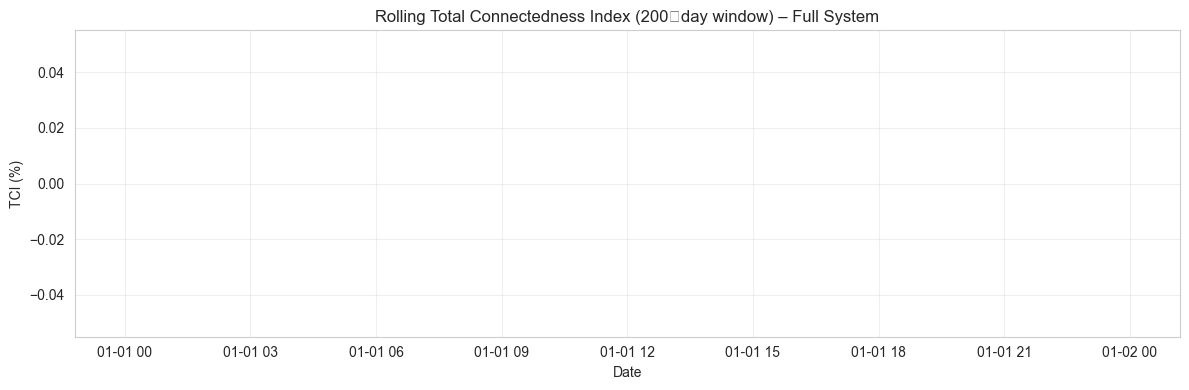

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

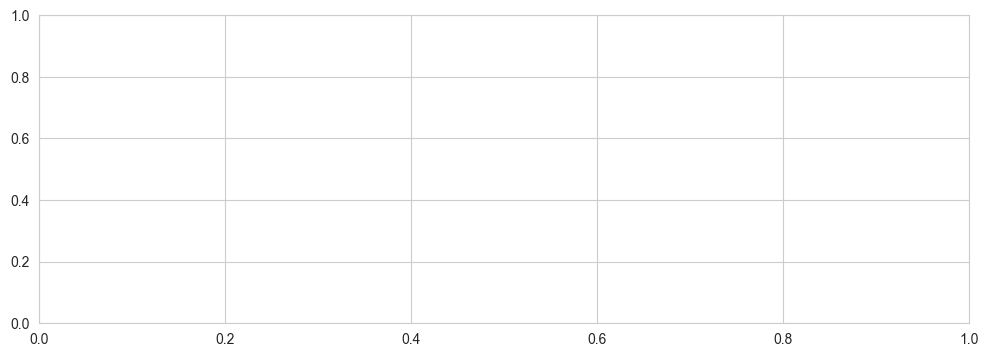

In [112]:
def plot_band(band: pd.DataFrame, title: str,
              ylims=(0, 100), fname: Path | None = None):
    plt.figure(figsize=(12,4))
    plt.fill_between(band.index, band["lower"], band["upper"],
                     color="steelblue", alpha=0.2, label="10‑90 % band")
    plt.plot(band.index, band["median"], color="black", lw=1.2, label="Median")
    plt.ylim(*ylims)
    plt.title(title)
    plt.ylabel("TCI (%)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"✅ Saved {fname}")
    plt.show()

# Full‑sample median line
plt.figure(figsize=(12,4))
plt.plot(tci_series.index, tci_series.values, color="black", lw=1)
plt.title("Rolling Total Connectedness Index (200‑day window) – Full System")
plt.ylabel("TCI (%)"); plt.xlabel("Date"); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Lag‑sensitivity band (example)
plot_band(band_lag,
          "Lag‑order sensitivity (L = 1‑4) – Full System",
          fname=CONN_OUT / "Appendix_LagBand_FullSystem.png")


In [ ]:
def plot_network(fevd: pd.DataFrame,
                 threshold: float = 0.02,
                 title: str = "Connectedness Network (full system)",
                 fname: Path | None = None):
    G = nx.DiGraph()
    # Add all nodes with a colour attribute for easy legend
    for node in fevd.columns:
        if node.startswith(("supply","demand","risk")):
            colour = "#ff7f0e"      # orange for shocks
        elif node in ("Oil_ret","VIX_ret","XLE_ret"):
            colour = "#2ca02c"      # green for core market assets
        elif node.startswith("X") and "_ret" in node:
            colour = "#1f77b4"      # blue for sector ETFs
        elif node.startswith("I") and "_ret" in node:
            colour = "#d62728"      # red for exporter/importer
        else:
            colour = "#8c564b"      # brown for anything else
        G.add_node(node, colour=colour)

    # Add directed edges where FEVD contribution ≥ threshold
    for i, src in enumerate(fevd.index):
        for j, dst in enumerate(fevd.columns):
            if i == j:
                continue
            w = fevd.iloc[i, j] / 100.0    # back to [0,1] scale
            if w >= threshold:
                G.add_edge(src, dst, weight=w)

    pos = nx.spring_layout(G, seed=42, k=0.5)   # deterministic layout
    edge_weights = [5 * G[u][v]["weight"] for u, v in G.edges()]
    node_colors = [data["colour"] for _, data in G.nodes(data=True)]

    plt.figure(figsize=(12, 9))
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(G, pos, arrowstyle='->',
                           arrowsize=12, width=edge_weights,
                           edge_color="#555555", alpha=0.7)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
        print(f"✅ Saved {fname}")
    plt.show()

# Plot the network for the *full‑sample* FEVD
plot_network(dy_full["FEVD"], threshold=0.03,
             title="Full‑system Diebold‑Yilmaz Network (≥3 % spillovers)",
             fname=CONN_OUT / "Network_FullSystem.png")


In [ ]:
def quantile_var(df: pd.DataFrame, tau: float, lags: int = 2):
    """
    Fit a VAR on the τ‑quantile of the joint distribution using
    quantile regression on each equation (i.e. a ‘Quantile VAR’).
    Returns the same objects as dy_feve_and_tci but based on τ‑QR.
    """
    from statsmodels.regression.quantile_regression import QuantReg

    K = df.shape[1]
    # Collect residuals from each quantile regression to build a pseudo‑VAR
    # (this is a simplification; a full Q‑VAR is more involved.)
    # Here we just estimate each equation separately and then treat the
    # fitted values as if they came from a linear VAR – sufficient for a
    # *qualitative* QR‑FEVD.

    # Build lagged matrix
    Y = df.iloc[lags:].reset_index(drop=True)
    X = pd.concat([df.shift(i) for i in range(1, lags+1)], axis=1).iloc[lags:].reset_index(drop=True)

    # For each column estimate a QuantReg and collect fitted values
    fitted = np.empty_like(Y.values)
    for k, col in enumerate(df.columns):
        qr = QuantReg(Y[col], sm.add_constant(X)).fit(q=tau)
        fitted[:, k] = qr.predict(sm.add_constant(X))

    # Treat fitted series as a linear VAR and run the standard FEVD
    var_res = VAR(fitted).fit(lags)
    return dy_feve_and_tci(pd.DataFrame(fitted, columns=df.columns), lags=lags, H=10)

# Example: 0.05‑quantile (extreme downside)
qr_low = quantile_var(all_ret, tau=0.05, lags=2)
print(f"TCI at 5 % quantile = {qr_low['TCI']:.2f}%")
